<a href="https://colab.research.google.com/github/Roger-G/Data-augmentation/blob/master/Classification_bi-LSTM%20(various%20ratio).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import package

In [ ]:
import re
from sklearn.utils import resample
import unicodedata
import torch
from sklearn.metrics import precision_recall_fscore_support as score
import torch.nn as nn
from torch.autograd import Variable
import seaborn as sns
from torch import optim
import torch.nn.functional as F
import pickle
import csv
import torch.utils.data as Data
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

from tqdm import trange
import pandas as pd
import torchtext.vocab as Vocab
import collections
import numpy as np
import os
import os.path as path

from sklearn.model_selection import train_test_split
from torchtext import data, datasets
PAD, BOS, EOS = '<pad>', '<bos>', '<eos>'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from google.colab import drive
drive.mount('/content/drive')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import torch.optim as optim


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data process

In [ ]:
class Preprocessor():
    
  def __init__(self, data, max_seq_len, vocab):
    self.data = data
    self.max_seq_len = max_seq_len
    self.vocab = vocab
    self.PAD, self.BOS, self.EOS = '<pad>', '<bos>', '<eos>'
    self.all_tokens = []
    self.all_seqs = []

  def process_one_seq(self, seq_tokens):
    self.all_tokens.extend(seq_tokens) # add seq_tokens into one list, like extend the list, [..., seq_tokens].
    seq_tokens = [self.PAD] * (self.max_seq_len - len(seq_tokens)) + seq_tokens
    self.all_seqs.append(seq_tokens) # add seq_tokens become a list element, [...,[seq_tokens]].
      
  def build_data(self):
    if self.vocab:
      indices = [[self.vocab.stoi[w] for w in seq] for seq in self.all_seqs] # use its vocab_dic to represent the sentence. 
    else:
      tokens_dic = collections.Counter(self.all_tokens) 
      self.vocab = Vocab.Vocab(tokens_dic, specials=[self.PAD])
      indices = [[self.vocab.stoi[w] for w in seq] for seq in self.all_seqs] # use its vocab_dic to represent the sentence. 
    return torch.tensor(indices)
  
  @staticmethod
  def normalizeString(s):
    s = s.str.lower()
    s = s.str.replace(r"<br />",r" ")
    s = s.str.replace(r'(\W)(?=\1)', '')
    s = s.str.replace(r"([.!?])", r" \1")
    s = s.str.replace(r"[^a-zA-Z.!?]+", r" ")
    return s

  def read_data(self):
    df = self.data.copy()
    df = df.dropna()
    df['sentence'] = self.normalizeString(df['sentence'])
    df.reset_index(inplace=True, drop=True)
    k = len(df)
    target = []

    for line in range(k):
      in_seq_tokens = df['sentence'][line].split(' ')
      if len(in_seq_tokens) > self.max_seq_len - 1:
        continue
      self.process_one_seq(in_seq_tokens)
      target.append(df.label[line])

    in_data = self.build_data() # in_tokens is the list where contains every word, in_seqs is a list where its element are the sentence in French.

    return Data.TensorDataset(in_data, torch.tensor(target))

## Loading data, path and figure

In [ ]:
class Loader():


  def path_setting(self, task_name, tech_name):
    abspath = '/content/drive/My Drive/Data/'
    model_path = path.join(abspath, tech_name + '/save_model')
    dataset_path = path.join(abspath, tech_name + '/datasets/{}/'.format(task_name))
    save_path = path.join(abspath, tech_name + '/aug_data/{}/'.format(task_name))
    
    return model_path, dataset_path, save_path

  @staticmethod
  def load_data(path_, FILE_NAME, ratio, tech_name):

    df_train = pd.read_csv(os.path.join(path_,'train.tsv'), sep='\t',  error_bad_lines=False)
    df_train = df_train.dropna()
    num = int(len(df_train) * ratio)
    df_train = df_train[ : num ]
    num_DA = max(df_train.label.value_counts()) - min(df_train.label.value_counts())

    if FILE_NAME != 'oversampling':
      df = pd.read_csv(os.path.join(path_, FILE_NAME + '.tsv'), sep='\t',  error_bad_lines=False)    
      df = df.dropna()
      if FILE_NAME == 'train' or tech_name == 'EDA':
        df = df[ : num]
      # num_DA = max(df.label.value_counts()) - min(df.label.value_counts())
    
    else:
      # 选出差额， 补到原数据上面
      print('num_DA', num_DA)
      df_over_samp = resample(df_train[df_train.label==0], n_samples=num_DA, random_state=100, replace=True)
      df = pd.concat([df_over_samp, df_train])

    if FILE_NAME != 'train' and FILE_NAME != 'dev' and FILE_NAME != 'oversampling' and FILE_NAME != 'test':
      try:
        df_over_samp = resample(df, n_samples=num_DA, replace = False, random_state=10) 
      except ValueError:
        df_over_samp = resample(df, n_samples=num_DA, replace = True, random_state=10) 

      df = pd.concat([df_train, df_over_samp]) 
    
    else: 
      pass

    df = df.sample(frac = 1, replace=False, random_state=102).reset_index().drop(columns = ['index'])
    # print('label counts', df.label.value_counts())
    return df

class utils():
  
  def __init__(self, EPOCHS):
    self.EPOCHS = EPOCHS

  def acc_loss(self, list_train_acc, list_val_acc, list_train_loss, list_val_loss):
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    sns.lineplot(ax=ax1, data=pd.DataFrame(list(zip(list_train_acc, list_val_acc)), columns=['training acc', 'validation acc'], index = range(1, len(list_val_acc)+1)))
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.locator_params(integer=True)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.lineplot(ax=ax2, data=pd.DataFrame(list(zip(list_train_loss, list_val_loss)), columns=['training loss', 'validation loss'], index = range(1, len(list_val_loss)+1)))
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.locator_params(integer=True)
    plt.show()
  
  @staticmethod
  def draw_final(eval_dic, test_list_name):
    
    for eval_name, eval_list in eval_dic.items():
      sns.set(style="white", context="talk")
      plt.figure(figsize=(7, 4)) 
      g = sns.barplot(x=np.array(eval_list), y=np.array(test_list_name), palette="deep")
      ax=g
    
      for p in ax.patches:
        ax.annotate("%.2f" % p.get_width(), (p.get_width(), p.get_y() + p.get_height() / 2.),
          fontsize=10, color='gray', xytext=(10, 0), textcoords='offset points')

      ax.axhline(0, color="k", clip_on=False)
      ax.set_xlabel(eval_name)
      # ax.set_ylabel("Methods")
    plt.show()

  @staticmethod
  def eval_matrix(list_array_value):
    fig = plt.figure(figsize=(7, 4))
  
    for i, array_value in enumerate(list_array_value):
      df = pd.DataFrame(array_value, columns=["0", "1", "2"], index=range(1,len(array_value)+1))
      ax = fig.add_subplot(1, 3, i+1)
      sns.lineplot(data=df, palette="tab10", ax=ax)
      ax.set(xlabel='Epochs', ylabel=['precision', 'recall', 'fscore'][i])

    plt.show()
  
  @staticmethod
  def draw_other_final(list_array_dic, test_list): 

    for eval_name, list_array in list_array_dic.items():
      fig1 = plt.figure(figsize=(5, 3))
      barWidth = 0.03
      colors = ['#486093', '#BF7651', '#4F8F5B', '#A4484E', '#72659A', '#7A6553', '#C47FB2']
      # Set position of bar on X axis
      r1 = np.arange(len(list_array[0]))
      plt.bar(r1, list_array[0], color=colors[0], width=barWidth, edgecolor='white', label=test_list[0])
      for i in range(1, len(list_array)):
        r1 = [x + barWidth for x in r1] 
        plt.bar(r1, list_array[i], color=colors[i], width=barWidth, edgecolor='white', label=test_list[i])  
    
      # Add xticks on the middle of the group bars
      plt.xlabel('class', fontweight='bold')
      plt.xticks([r + barWidth for r in range(len(list_array[0]))], ['negative', 'neutral', 'positive'])
      plt.ylabel(eval_name)
      # Create legend & Show graphic
      plt.legend()
      plt.show()
    


## Model building

In [ ]:
class SentimentRNN(nn.Module):
  def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, num_direct,n_layers, drop_p=0.8):
    super().__init__()
    
    self.output_size = output_size
    self.n_layers = n_layers  
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=drop_p, bidirectional=num_direct, num_layers=n_layers)
    self.fc = nn.Linear(hidden_dim*2 , output_size)
    self.out = nn.Softmax(dim=1)

  
  def forward(self, x):
    # x (batch_size, seq_length) 
    x = self.embedding(x)
    output, hidden = self.lstm(x)
    # print('output', output.shape)
    output = self.fc(output[-1,:,:])
    #print('last output', output.shape)

    return output



## Train

In [ ]:
class Trainer():

  def __init__(self, model, batch_size, patient, learning_rate, N_EPOCHS, file_name):
    self.model = model
    self.batch_size = batch_size
    self.patient = patient
    self.lr = learning_rate
    self.epochs = N_EPOCHS
    self.file_name = file_name
  
  
  def get_predictions(self, dataset):
    predictions = None
    correct = 0
    total = 0
    loss_list = []
    loss = nn.CrossEntropyLoss()

    with torch.no_grad():
      label_list = list()
      pred_list = list()

      for batch in dataset:

        batch = tuple(t.to(device) for t in batch)
        X, Y = batch[:][0], batch[:][1]
        labels = Y.tolist()
        y_pred = self.model(X.permute(1, 0)).squeeze(1)
        pred = [ten.index(max(ten)) for ten in y_pred.tolist()]
        correct += sum([1 for i in range(len(labels)) if pred[i]==labels[i]])
        batch_loss = loss(y_pred, Y.to(device, dtype=torch.int64))
        loss_list.append(batch_loss.item())
        total += len(labels)
        
        label_list.extend(labels)
        pred_list.extend(pred)

    # got all the evalution results for every class.
    self.precision, self.recall, self.fscore, _ = score(label_list, pred_list) # 每个 class 单独的参数
    # the second score function is to get average score of evaluation matrix.
    self.precision_avg, self.recall_avg, self.fscore_avg, _ = score(label_list, pred_list, average='macro' ) 
    acc = correct / total

    return acc, np.mean(loss_list)


  def train(self, corpus_indices, corpus_indices_valid, corpus_indices_test, model_path):

    best_acc = 0
    best_loss = float('inf')
    loss = nn.CrossEntropyLoss()
    
    data_iter = Data.DataLoader(corpus_indices, self.batch_size, shuffle=True)
    data_iter_dev = Data.DataLoader(corpus_indices_valid , self.batch_size, shuffle=True)
    data_iter_test = Data.DataLoader(corpus_indices_test , len(corpus_indices_test), shuffle=True)
    
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
    draw_train_loss = []
    draw_train_acc = []
    draw_val_loss = []
    draw_val_acc = []
    model_sel = []
    patient = 0
    precision_list = [0, 0, 0] 
    recall_list = [0, 0, 0] 
    fscore_list = [0, 0, 0] 
    fscore_avg_list = []
    precision_avg_list = []
    recall_avg_list = []
    
    for epoch in range(self.epochs):

      self.model.train()
      for batch in data_iter:
        batch = tuple(t.to(device) for t in batch)
        X, Y = batch[:][0], batch[:][1]
        y_pred = self.model(X.permute(1, 0)).squeeze(1)
        batch__train_loss = loss(y_pred, Y.to(device, dtype=torch.int64))
        batch__train_loss.backward()
        optimizer.step()

      torch.cuda.empty_cache()
      self.model.eval()
      train_acc, train_loss = self.get_predictions(data_iter)
      dev_acc, dev_loss = self.get_predictions(data_iter_dev)

      if best_loss > dev_loss:
        best_loss = dev_loss
        best_acc = dev_acc
        patient = 0
        model_sel = []  

      model_sel.append(self.model)
      patient += 1
      print('[epoch %d] train_loss: %.4f, train_acc:%.4f, val Loss: : %.4f, val_acc: %.3f' % 
            (epoch + 1, train_loss, train_acc, dev_loss, dev_acc))
      
      if patient > self.patient:
        # torch.save(self.model[0], path.join(model_path,'{}_lstm_cls.pt'.format(self.file_name)))
        break

      draw_train_loss.append(train_loss) #计算每个train epoch 的loss和acc 和 val的epoch的loss和acc
      draw_train_acc.append(train_acc)
      draw_val_loss.append(dev_loss)
      draw_val_acc.append(dev_acc)
    
    self.model = model_sel[0]

    test_acc, test_loss = self.get_predictions(data_iter_dev)
    # torch.save(self.model, path.join(model_path,'{}_lstm_cls.pt'.format(self.file_name)))
    draw = utils(len(draw_train_acc))
    draw.acc_loss(draw_train_acc, draw_val_acc, draw_train_loss, draw_val_loss)

    return self.model, test_acc, test_loss, self.precision, self.recall, self.fscore, self.precision_avg, self.recall_avg, self.fscore_avg


## Execute

### execute

In [ ]:
def Execute(test_list, task_name, tech_name, ratio):
  # vocab_size = vocab_length + 1 #+1 for the padding 0
  output_size = 3
  embedding_dim = 200
  hidden_dim = 128
  num_direct = True
  n_layers = 1
  acc_list = []
  batch_size = 64
  patient = 3
  N_EPOCHS = 30
  lr = 1e-5
  acc_list = []
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_avg_fs = []
  list_avg_prec = []
  list_avg_recall = []
  model_list = []

  loader = Loader()
  model_path, dataset_path, save_path = loader.path_setting(task_name, tech_name)
  # print('start to loading test dataset')
  df_dev = loader.load_data(save_path, 'dev', ratio, tech_name)
  df_test = loader.load_data(save_path, 'test', ratio, tech_name)
  
  if tech_name == 'Bert_ data augmentation-master' and task_name == 'rt-polaritydata':
    path_ = path.join(save_path, 'replacement')
  else:
    path_ = save_path

  for file_name in test_list:

    print('-' * 70)
    print('Start to make classification use the data : {}'.format(file_name))
    print('-' * 70)
    # DA and oversampling data"
    df_train = loader.load_data(path_, file_name, ratio, tech_name) 
    df_vocab = pd.concat([df_train, df_dev], axis=0) # I didn't add the test dataset because I think it's happends that we could see the test dataset in practice.
    preprocessor = Preprocessor(df_vocab, 30, None)
    preprocessor.read_data() # in order to get a vocab including all words both in train and test set, preprocessor.vocab
    corpus_indices_train = Preprocessor(df_train, 30, preprocessor.vocab).read_data()
    corpus_indices_valid = Preprocessor(df_dev, 30, preprocessor.vocab).read_data()
    corpus_indices_test = Preprocessor(df_test, 30, preprocessor.vocab).read_data()
    model = SentimentRNN(len(preprocessor.vocab)+1, output_size, embedding_dim, hidden_dim, num_direct, n_layers)
    model.to(device)
    
    trainer = Trainer(model, batch_size, patient, lr, N_EPOCHS, file_name)
    model_, acc, loss, precision, recall, fscore, precision_avg, recall_avg, fscore_avg = trainer.train(corpus_indices_train,
                                                                         corpus_indices_valid, corpus_indices_test, model_path)
    print('-' * 70)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)
    model_list.append(model_)
    acc_list.append(acc)
    loss_list.append(loss)

    list_avg_fs.append(fscore_avg)
    list_avg_prec.append(precision_avg)
    list_avg_recall.append(recall_avg)
  
  print('acc_list', acc_list)
  print('loss_list', loss_list)
  print('precision_list', precision_list)
  print('recall_list', recall_list)
  print('fscore_list', fscore_list)
  print('average recall', list_avg_recall)
  print('average fs', list_avg_fs)
  print('average precision', list_avg_prec)
  
  utils.draw_final({
                      # 'loss': loss_list,
                    # 'accuracy': acc_list,
                    'recall_macro': list_avg_recall, 'precision_macro': list_avg_prec, 'fscore_macro': list_avg_fs}, test_list)
  # utils.draw_other_final( {
                    
  #                   'precision_list': precision_list,
  #                   'recall': recall_list, 
  #                   'fscore': fscore_list, 
  #                   }, test_list)



### minium epoch is 10 and the early stop point is the loss after the lowest loss

### Backtrans(various ratio) (test set)

#### sub_twitter

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ratio 0.2
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0674, train_acc:0.4369, val Loss: : 1.0679, val_acc: 0.439
[epoch 2] train_loss: 1.0418, train_acc:0.4845, val Loss: : 1.0455, val_acc: 0.469
[epoch 3] train_loss: 1.0155, train_acc:0.5273, val Loss: : 1.0230, val_acc: 0.487
[epoch 4] train_loss: 0.9891, train_acc:0.5544, val Loss: : 0.9997, val_acc: 0.498
[epoch 5] train_loss: 0.9607, train_acc:0.5726, val Loss: : 0.9750, val_acc: 0.510
[epoch 6] train_loss: 0.9285, train_acc:0.5807, val Loss: : 0.9484, val_acc: 0.518
[epoch 7] train_loss: 0.9013, train_acc:0.5729, val Loss: : 0.9212, val_acc: 0.517
[epoch 8] train_loss: 0.8770, train_acc:0.5665, val Loss: : 0.9020, val_acc: 0.522
[epoch 9] train_loss: 0.8804, train_acc:0.5736, val Loss: : 0.9057, val_acc: 0.522


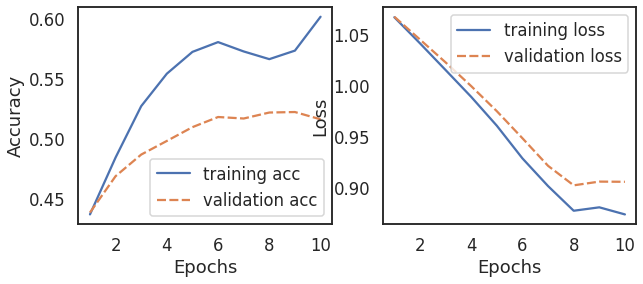

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 2351
[epoch 1] train_loss: 1.0877, train_acc:0.3893, val Loss: : 1.0881, val_acc: 0.405
[epoch 2] train_loss: 1.0672, train_acc:0.4896, val Loss: : 1.0864, val_acc: 0.405
[epoch 3] train_loss: 1.0458, train_acc:0.5434, val Loss: : 1.0844, val_acc: 0.409
[epoch 4] train_loss: 1.0228, train_acc:0.5685, val Loss: : 1.0825, val_acc: 0.403
[epoch 5] train_loss: 0.9973, train_acc:0.5814, val Loss: : 1.0787, val_acc: 0.406
[epoch 6] train_loss: 0.9688, train_acc:0.5959, val Loss: : 1.0745, val_acc: 0.410
[epoch 7] train_loss: 0.9373, train_acc:0.6097, val Loss: : 1.0660, val_acc: 0.419
[epoch 8] train_loss: 0.9029, train_acc:0.6244, val Loss: : 1.0523, val_acc: 0.435
[epoch 9] train_loss: 0.8637, train_acc:0.6442, val Lo

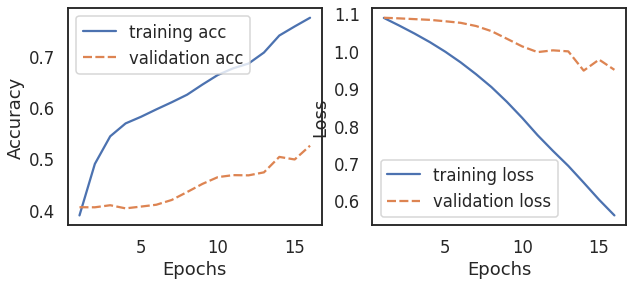

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : negative_aug
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0769, train_acc:0.3931, val Loss: : 1.0869, val_acc: 0.399
[epoch 2] train_loss: 1.0510, train_acc:0.4374, val Loss: : 1.0821, val_acc: 0.417
[epoch 3] train_loss: 1.0312, train_acc:0.4598, val Loss: : 1.0778, val_acc: 0.421
[epoch 4] train_loss: 1.0149, train_acc:0.4859, val Loss: : 1.0716, val_acc: 0.434
[epoch 5] train_loss: 0.9993, train_acc:0.5079, val Loss: : 1.0639, val_acc: 0.439
[epoch 6] train_loss: 0.9828, train_acc:0.5255, val Loss: : 1.0555, val_acc: 0.445
[epoch 7] train_loss: 0.9646, train_acc:0.5466, val Loss: : 1.0451, val_acc: 0.456
[epoch 8] train_loss: 0.9436, train_acc:0.5679, val Loss: : 1.0369, val_acc: 0.460
[epoch 9] train_loss: 0.9186, train_acc:0.5859, val Loss: : 1.0283

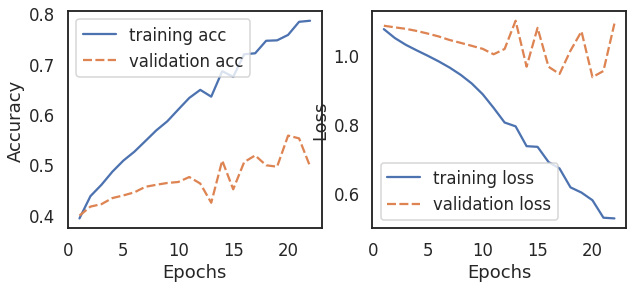

----------------------------------------------------------------------
acc_list [0.5036075036075036, 0.5177045177045178, 0.47863247863247865]
loss_list [0.9027822613716125, 0.9577510952949524, 1.0774939060211182]
precision_list [array([0.        , 0.52920093, 0.47515237]), array([0.17275156, 0.59112646, 0.54463852]), array([0.13671875, 0.60966543, 0.58542445])]
recall_list [array([0.        , 0.56455241, 0.52242268]), array([0.284041  , 0.50044984, 0.57860825]), array([0.46120059, 0.40575798, 0.56520619])]
fscore_list [array([0.        , 0.54630537, 0.49766757]), array([0.21483942, 0.54202192, 0.56110972]), array([0.21091396, 0.48723835, 0.57513769])]
average recall [0.362325029023347, 0.4543663618617999, 0.4773882519746336]
average fs [0.3479909773381534, 0.4393236903978153, 0.42442999994025693]
average precision [0.33478443174677736, 0.43617218150842, 0.44393621008629774]


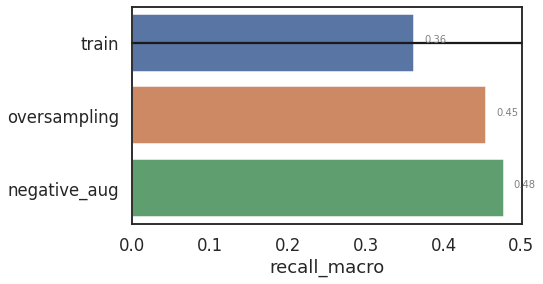

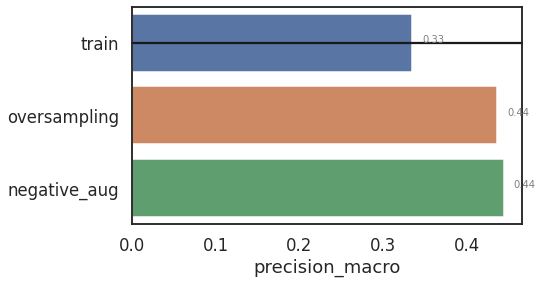

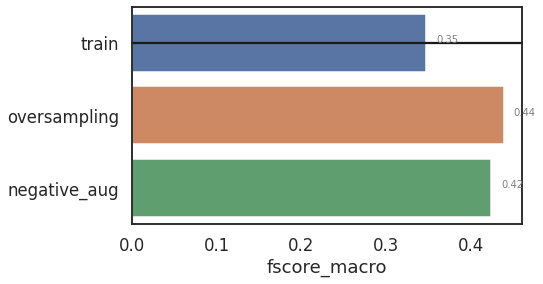

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ratio 0.4
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0658, train_acc:0.4502, val Loss: : 1.0692, val_acc: 0.446
[epoch 2] train_loss: 1.0075, train_acc:0.5254, val Loss: : 1.0136, val_acc: 0.497
[epoch 3] train_loss: 0.9459, train_acc:0.5495, val Loss: : 0.9552, val_acc: 0.514
[epoch 4] train_loss: 0.8993, train_acc:0.5359, val Loss: : 0.9081, val_acc: 0.514
[epoch 5] train_loss: 0.8926, train_acc:0.5673, val Loss: : 0.9077, val_acc: 0.522
[epoch 6] train_loss: 0.8807, train_acc:0.5596, val Loss: : 0.9068, val_acc: 0.501
[epoch 7] train_loss: 0.8618, train_acc:0.5932, val Loss: : 0.8965, val_acc: 0.523
[epoch 8] train_loss: 0.8449, train_acc:0.6014, val Loss: : 0.8945, val_acc: 0.533
[epoch 9] train_loss: 0.8365, train_acc:0.5997, val Loss: : 0.8971, val_acc: 0.541


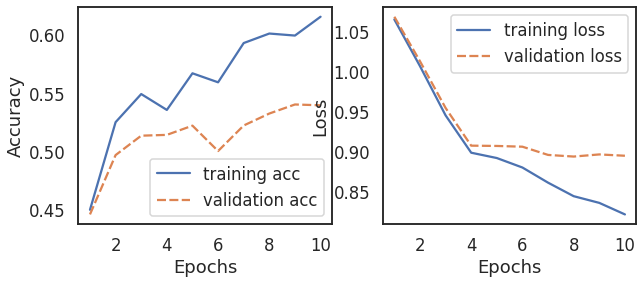

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 4802
[epoch 1] train_loss: 1.0724, train_acc:0.4538, val Loss: : 1.0891, val_acc: 0.396
[epoch 2] train_loss: 1.0376, train_acc:0.5229, val Loss: : 1.0939, val_acc: 0.364
[epoch 3] train_loss: 0.9951, train_acc:0.5515, val Loss: : 1.0903, val_acc: 0.371
[epoch 4] train_loss: 0.9398, train_acc:0.5814, val Loss: : 1.0638, val_acc: 0.409
[epoch 5] train_loss: 0.8666, train_acc:0.6178, val Loss: : 1.0436, val_acc: 0.437
[epoch 6] train_loss: 0.7999, train_acc:0.6408, val Loss: : 0.9935, val_acc: 0.480
[epoch 7] train_loss: 0.7355, train_acc:0.6821, val Loss: : 0.9260, val_acc: 0.521
[epoch 8] train_loss: 0.6772, train_acc:0.7107, val Loss: : 0.9800, val_acc: 0.498
[epoch 9] train_loss: 0.6326, train_acc:0.7246, val Lo

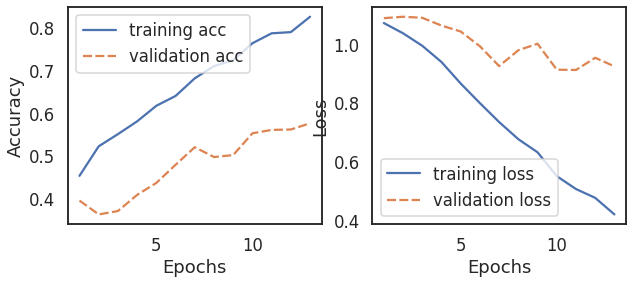

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : negative_aug
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0507, train_acc:0.4325, val Loss: : 1.0887, val_acc: 0.383
[epoch 2] train_loss: 1.0172, train_acc:0.4721, val Loss: : 1.0685, val_acc: 0.430
[epoch 3] train_loss: 0.9889, train_acc:0.5026, val Loss: : 1.0416, val_acc: 0.459
[epoch 4] train_loss: 0.9537, train_acc:0.5350, val Loss: : 1.0177, val_acc: 0.472
[epoch 5] train_loss: 0.8951, train_acc:0.5827, val Loss: : 1.0083, val_acc: 0.468
[epoch 6] train_loss: 0.8316, train_acc:0.6175, val Loss: : 0.9475, val_acc: 0.507
[epoch 7] train_loss: 0.7867, train_acc:0.6448, val Loss: : 1.0237, val_acc: 0.471
[epoch 8] train_loss: 0.7503, train_acc:0.6768, val Loss: : 0.9724, val_acc: 0.501
[epoch 9] train_loss: 0.6852, train_acc:0.7042, val Loss: : 0.9569

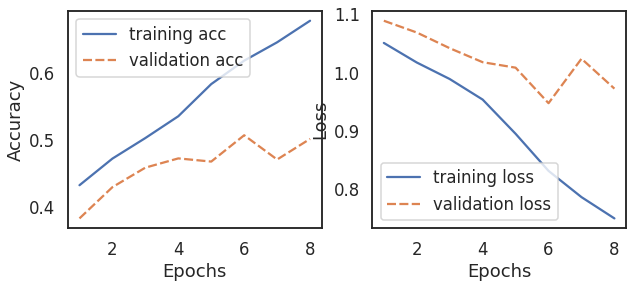

----------------------------------------------------------------------
acc_list [0.5424575424575424, 0.5394605394605395, 0.5308025308025308]
loss_list [0.8964762091636658, 0.979430615901947, 0.9566067457199097]
precision_list [array([0.        , 0.54900938, 0.53136531]), array([0.19631336, 0.55712154, 0.67987322]), array([0.16314455, 0.58033149, 0.59466828])]
recall_list [array([0.        , 0.71052632, 0.44536082]), array([0.31185944, 0.75573549, 0.33170103]), array([0.28257687, 0.59064327, 0.50592784])]
fscore_list [array([0.        , 0.61941176, 0.48457656]), array([0.24095023, 0.64140498, 0.4458687 ]), array([0.20685959, 0.58544198, 0.54672051])]
average recall [0.38529571351058056, 0.4664319890454908, 0.45971599222320764]
average fs [0.3679961070238527, 0.44274130256773153, 0.44634069496251155]
average precision [0.36012489947631493, 0.4777693732958732, 0.44604810727044164]


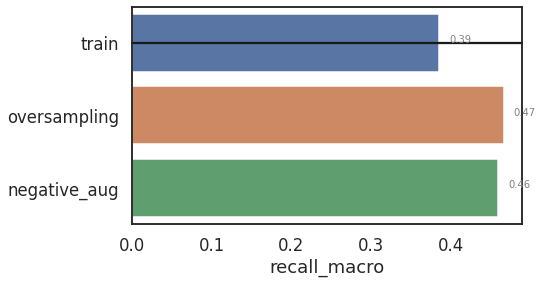

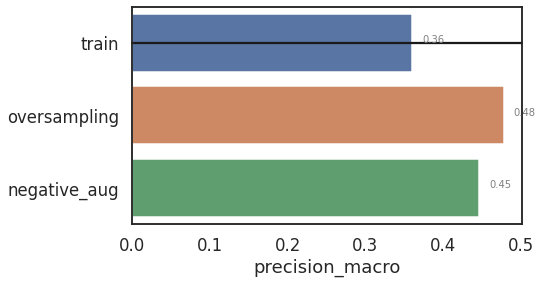

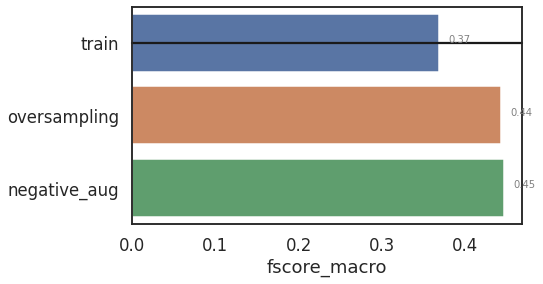

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ratio 0.6
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0325, train_acc:0.5035, val Loss: : 1.0349, val_acc: 0.490
[epoch 2] train_loss: 0.9471, train_acc:0.5393, val Loss: : 0.9520, val_acc: 0.523
[epoch 3] train_loss: 0.8993, train_acc:0.5447, val Loss: : 0.9036, val_acc: 0.527
[epoch 4] train_loss: 0.8784, train_acc:0.5650, val Loss: : 0.8991, val_acc: 0.516
[epoch 5] train_loss: 0.8565, train_acc:0.5857, val Loss: : 0.8893, val_acc: 0.546
[epoch 6] train_loss: 0.8372, train_acc:0.6026, val Loss: : 0.8874, val_acc: 0.550
[epoch 7] train_loss: 0.8143, train_acc:0.6193, val Loss: : 0.8828, val_acc: 0.552
[epoch 8] train_loss: 0.7849, train_acc:0.6393, val Loss: : 0.8754, val_acc: 0.574
[epoch 9] train_loss: 0.7522, train_acc:0.6656, val Loss: : 0.8683, val_acc: 0.591


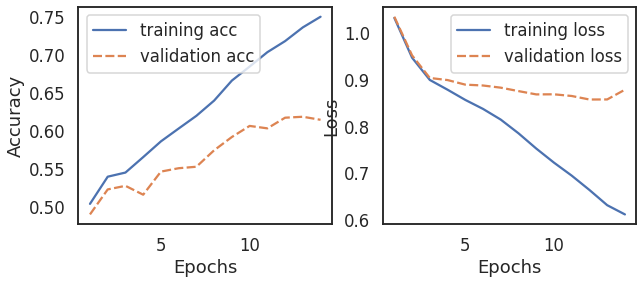

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 7128
[epoch 1] train_loss: 1.0647, train_acc:0.4651, val Loss: : 1.0962, val_acc: 0.358
[epoch 2] train_loss: 1.0138, train_acc:0.5107, val Loss: : 1.0751, val_acc: 0.402
[epoch 3] train_loss: 0.9332, train_acc:0.5618, val Loss: : 1.0087, val_acc: 0.463
[epoch 4] train_loss: 0.8594, train_acc:0.6027, val Loss: : 1.0897, val_acc: 0.420
[epoch 5] train_loss: 0.7779, train_acc:0.6514, val Loss: : 1.0400, val_acc: 0.461
[epoch 6] train_loss: 0.7021, train_acc:0.6897, val Loss: : 1.0262, val_acc: 0.489


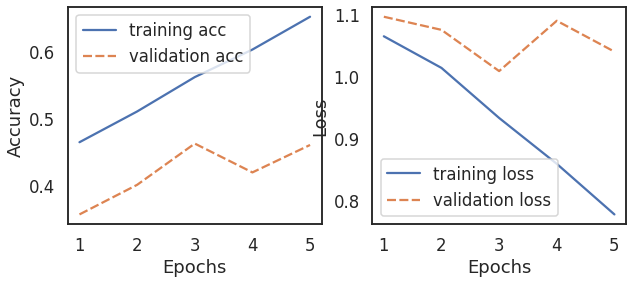

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : negative_aug
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0388, train_acc:0.4484, val Loss: : 1.0809, val_acc: 0.415
[epoch 2] train_loss: 1.0005, train_acc:0.4859, val Loss: : 1.0511, val_acc: 0.446
[epoch 3] train_loss: 0.9449, train_acc:0.5418, val Loss: : 1.0228, val_acc: 0.459
[epoch 4] train_loss: 0.8521, train_acc:0.5981, val Loss: : 1.0363, val_acc: 0.446
[epoch 5] train_loss: 0.7620, train_acc:0.6618, val Loss: : 0.9289, val_acc: 0.532
[epoch 6] train_loss: 0.6904, train_acc:0.6919, val Loss: : 0.9068, val_acc: 0.573
[epoch 7] train_loss: 0.6299, train_acc:0.7280, val Loss: : 0.9000, val_acc: 0.561
[epoch 8] train_loss: 0.5807, train_acc:0.7512, val Loss: : 0.8648, val_acc: 0.582
[epoch 9] train_loss: 0.5249, train_acc:0.7793, val Loss: : 0.8454

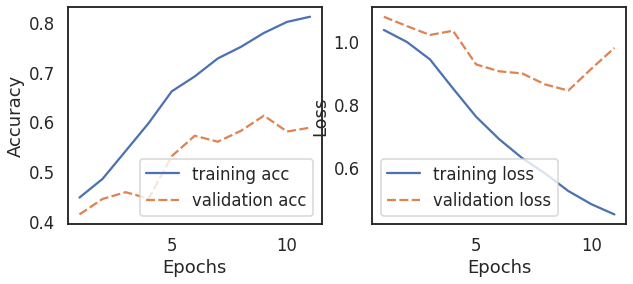

----------------------------------------------------------------------
acc_list [0.6183816183816184, 0.49916749916749914, 0.6182706182706182]
loss_list [0.8611666560173035, 1.0015177726745605, 0.8749232292175293]
precision_list [array([0.20661157, 0.61370952, 0.63903521]), array([0.16301921, 0.60465116, 0.61636751]), array([0.2519084 , 0.63363052, 0.66525064])]
recall_list [array([0.03660322, 0.72896986, 0.59407216]), array([0.53440703, 0.47368421, 0.52216495]), array([0.24158126, 0.68735942, 0.60541237])]
fscore_list [array([0.06218905, 0.66639252, 0.61573394]), array([0.24982888, 0.53121453, 0.56536905]), array([0.24663677, 0.65940231, 0.63392255])]
average recall [0.4532150821935723, 0.5100853955994573, 0.5114510181621185]
average fs [0.44810516974389286, 0.4488041552907968, 0.5133205425453508]
average precision [0.4864521014247944, 0.46134595871974077, 0.5169298515275974]


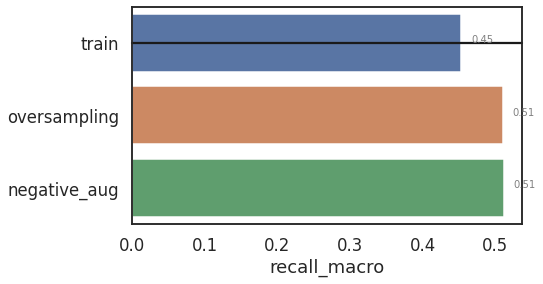

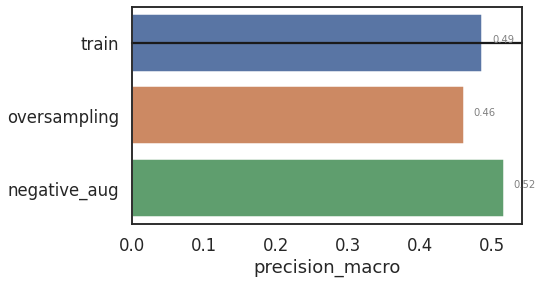

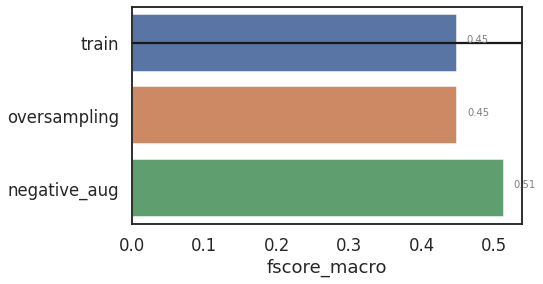

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ratio 0.8
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9934, train_acc:0.5279, val Loss: : 0.9975, val_acc: 0.513
[epoch 2] train_loss: 0.8946, train_acc:0.5470, val Loss: : 0.9006, val_acc: 0.528
[epoch 3] train_loss: 0.8747, train_acc:0.5704, val Loss: : 0.8933, val_acc: 0.533
[epoch 4] train_loss: 0.8527, train_acc:0.5914, val Loss: : 0.8868, val_acc: 0.546
[epoch 5] train_loss: 0.8257, train_acc:0.6153, val Loss: : 0.8807, val_acc: 0.555
[epoch 6] train_loss: 0.7872, train_acc:0.6434, val Loss: : 0.8649, val_acc: 0.585
[epoch 7] train_loss: 0.7485, train_acc:0.6697, val Loss: : 0.8520, val_acc: 0.613
[epoch 8] train_loss: 0.7184, train_acc:0.6897, val Loss: : 0.8566, val_acc: 0.607
[epoch 9] train_loss: 0.6832, train_acc:0.7148, val Loss: : 0.8443, val_acc: 0.607


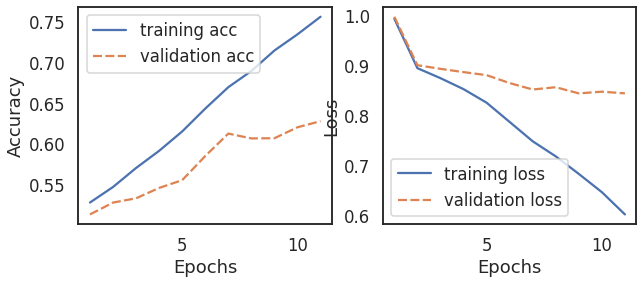

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 9488
[epoch 1] train_loss: 1.0568, train_acc:0.4763, val Loss: : 1.0937, val_acc: 0.380
[epoch 2] train_loss: 0.9869, train_acc:0.5338, val Loss: : 1.0680, val_acc: 0.418
[epoch 3] train_loss: 0.8723, train_acc:0.5921, val Loss: : 0.9926, val_acc: 0.474
[epoch 4] train_loss: 0.7835, train_acc:0.6546, val Loss: : 1.0124, val_acc: 0.468
[epoch 5] train_loss: 0.7162, train_acc:0.6759, val Loss: : 0.8823, val_acc: 0.558
[epoch 6] train_loss: 0.6023, train_acc:0.7446, val Loss: : 0.9090, val_acc: 0.556
[epoch 7] train_loss: 0.5471, train_acc:0.7628, val Loss: : 0.9149, val_acc: 0.557
[epoch 8] train_loss: 0.4831, train_acc:0.8027, val Loss: : 0.8651, val_acc: 0.603
[epoch 9] train_loss: 0.4503, train_acc:0.8138, val Lo

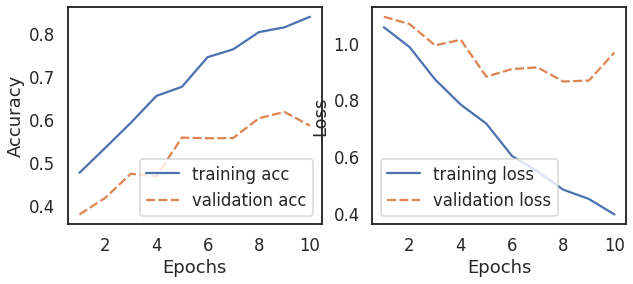

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : negative_aug
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0276, train_acc:0.4572, val Loss: : 1.0744, val_acc: 0.413
[epoch 2] train_loss: 0.9682, train_acc:0.5185, val Loss: : 1.0241, val_acc: 0.456
[epoch 3] train_loss: 0.8547, train_acc:0.6016, val Loss: : 0.9529, val_acc: 0.491
[epoch 4] train_loss: 0.7587, train_acc:0.6576, val Loss: : 0.9630, val_acc: 0.503
[epoch 5] train_loss: 0.6763, train_acc:0.6937, val Loss: : 0.9490, val_acc: 0.550
[epoch 6] train_loss: 0.6242, train_acc:0.7243, val Loss: : 0.9634, val_acc: 0.537
[epoch 7] train_loss: 0.5567, train_acc:0.7528, val Loss: : 0.9443, val_acc: 0.570
[epoch 8] train_loss: 0.5056, train_acc:0.7836, val Loss: : 0.9346, val_acc: 0.566
[epoch 9] train_loss: 0.4598, train_acc:0.8055, val Loss: : 0.9785

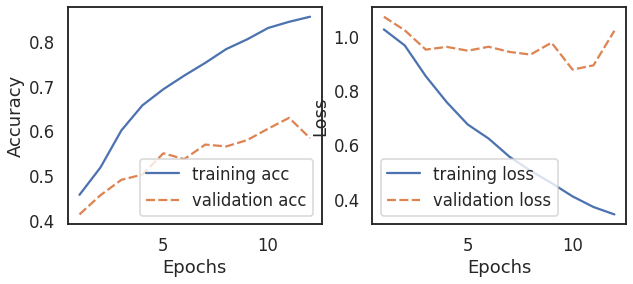

----------------------------------------------------------------------
acc_list [0.6233766233766234, 0.6087246087246088, 0.6193806193806194]
loss_list [0.8563966155052185, 0.9303221702575684, 0.9079009890556335]
precision_list [array([0.27692308, 0.59280598, 0.72161172]), array([0.25848564, 0.62758189, 0.66028986]), array([0.24342105, 0.64496395, 0.64853556])]
recall_list [array([0.05270864, 0.8562753 , 0.45695876]), array([0.28989751, 0.6765632 , 0.5871134 ]), array([0.21669107, 0.66396761, 0.63917526])]
fscore_list [array([0.08856089, 0.70058888, 0.55957077]), array([0.27329193, 0.65115272, 0.62155525]), array([0.22927963, 0.65432783, 0.64382139])]
average recall [0.4553142349634995, 0.5178580386406048, 0.5066113126273489]
average fs [0.4495735150742828, 0.5153333000031216, 0.509142949520629]
average precision [0.5304469259934846, 0.515452461671924, 0.5123068558902822]


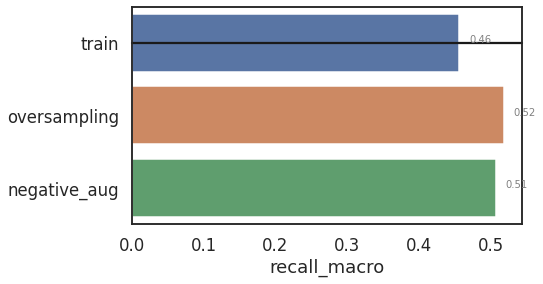

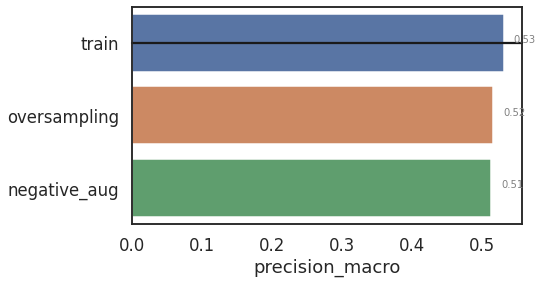

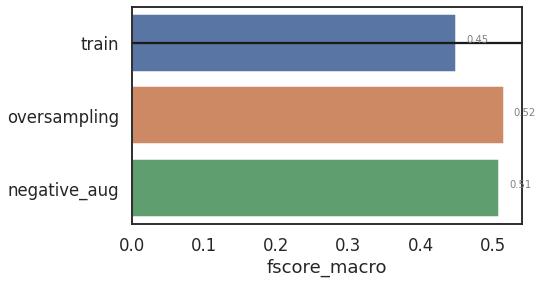

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ratio 1
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9813, train_acc:0.5205, val Loss: : 0.9818, val_acc: 0.507
[epoch 2] train_loss: 0.9088, train_acc:0.5508, val Loss: : 0.9096, val_acc: 0.521
[epoch 3] train_loss: 0.8707, train_acc:0.5687, val Loss: : 0.8859, val_acc: 0.539
[epoch 4] train_loss: 0.8465, train_acc:0.5917, val Loss: : 0.8801, val_acc: 0.545
[epoch 5] train_loss: 0.8099, train_acc:0.6246, val Loss: : 0.8669, val_acc: 0.572
[epoch 6] train_loss: 0.7692, train_acc:0.6560, val Loss: : 0.8627, val_acc: 0.594
[epoch 7] train_loss: 0.7220, train_acc:0.6892, val Loss: : 0.8426, val_acc: 0.615
[epoch 8] train_loss: 0.6826, train_acc:0.7117, val Loss: : 0.8325, val_acc: 0.627
[epoch 9] train_loss: 0.6560, train_acc:0.7255, val Loss: : 0.8582, val_acc: 0.617
[e

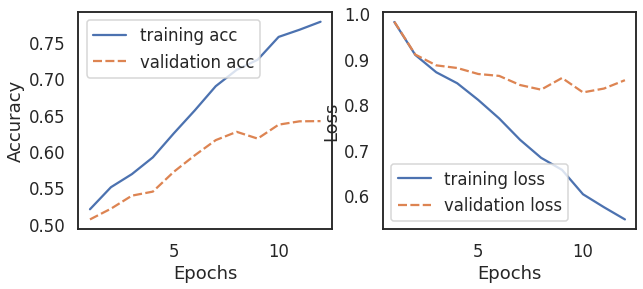

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 11850
[epoch 1] train_loss: 1.0492, train_acc:0.4744, val Loss: : 1.0921, val_acc: 0.369
[epoch 2] train_loss: 0.9422, train_acc:0.5494, val Loss: : 1.0326, val_acc: 0.461
[epoch 3] train_loss: 0.8219, train_acc:0.6268, val Loss: : 0.9657, val_acc: 0.491
[epoch 4] train_loss: 0.7189, train_acc:0.6862, val Loss: : 0.9734, val_acc: 0.513
[epoch 5] train_loss: 0.6343, train_acc:0.7188, val Loss: : 0.8571, val_acc: 0.587
[epoch 6] train_loss: 0.5623, train_acc:0.7550, val Loss: : 0.8852, val_acc: 0.573
[epoch 7] train_loss: 0.4814, train_acc:0.8016, val Loss: : 0.8820, val_acc: 0.593
[epoch 8] train_loss: 0.4242, train_acc:0.8215, val Loss: : 0.8805, val_acc: 0.624


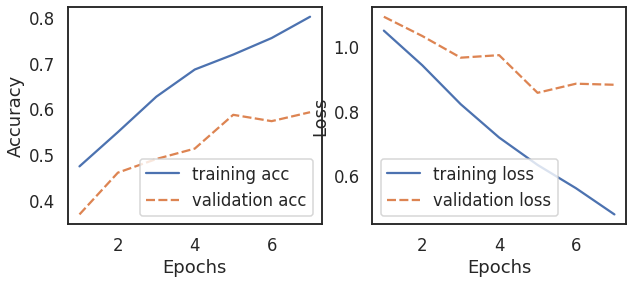

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : negative_aug
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0188, train_acc:0.4602, val Loss: : 1.0629, val_acc: 0.431
[epoch 2] train_loss: 0.9094, train_acc:0.5599, val Loss: : 0.9768, val_acc: 0.478
[epoch 3] train_loss: 0.7973, train_acc:0.6267, val Loss: : 0.9628, val_acc: 0.509
[epoch 4] train_loss: 0.7057, train_acc:0.6688, val Loss: : 0.9176, val_acc: 0.551
[epoch 5] train_loss: 0.6121, train_acc:0.7277, val Loss: : 0.8993, val_acc: 0.565
[epoch 6] train_loss: 0.5411, train_acc:0.7611, val Loss: : 0.8903, val_acc: 0.593
[epoch 7] train_loss: 0.4859, train_acc:0.7908, val Loss: : 0.8998, val_acc: 0.592
[epoch 8] train_loss: 0.4323, train_acc:0.8151, val Loss: : 0.9032, val_acc: 0.604
[epoch 9] train_loss: 0.3767, train_acc:0.8433, val Loss: : 0.8949

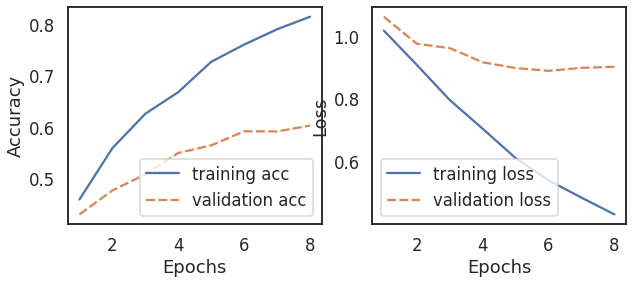

----------------------------------------------------------------------
acc_list [0.6335886335886336, 0.6098346098346098, 0.6021756021756022]
loss_list [0.8690307140350342, 0.8789770603179932, 0.9047055244445801]
precision_list [array([0.20087336, 0.62924583, 0.66769403]), array([0.27698864, 0.63448126, 0.64245359]), array([0.23458038, 0.6231259 , 0.68517931])]
recall_list [array([0.06734993, 0.73751687, 0.61417526]), array([0.28550512, 0.65474584, 0.61546392]), array([0.33967789, 0.68241116, 0.5564433 ])]
fscore_list [array([0.10087719, 0.67909289, 0.63981743]), array([0.28118241, 0.64445428, 0.62866921]), array([0.27751196, 0.65142244, 0.61413739])]
average recall [0.47301401787377767, 0.5185716269776967, 0.5261774489063015]
average fs [0.47326250137654435, 0.5181019678075139, 0.5143572634012903]
average precision [0.499271073508051, 0.5179744944729227, 0.5142951969748091]


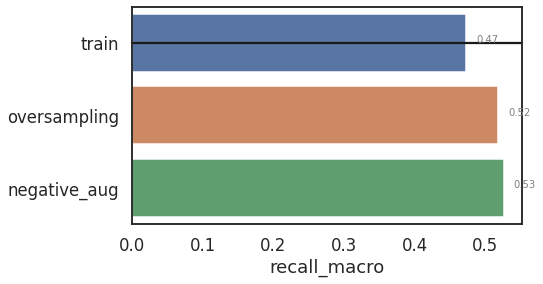

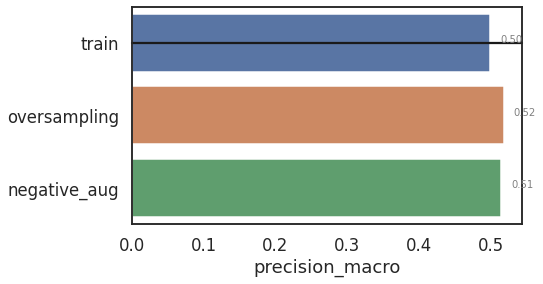

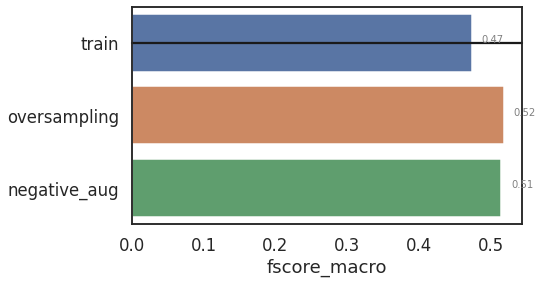

In [ ]:
task_name = 'sub_twitter'
tech_name = 'Back_trans'
test_list = [
      'train',
      'oversampling',
      'negative_aug',

           ]
      
ratios = [0.2, 0.4, 0.6, 0.8, 1]
for ratio in ratios:
  print('<'*50)
  print('ratio', ratio)
  Execute(test_list, task_name, tech_name, ratio)

### *EDA*(various ratio) (test set)

#### New subtwitter

ratio 0.2
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0726, train_acc:0.4368, val Loss: : 1.0723, val_acc: 0.434
[epoch 2] train_loss: 1.0464, train_acc:0.4878, val Loss: : 1.0485, val_acc: 0.462
[epoch 3] train_loss: 1.0180, train_acc:0.5287, val Loss: : 1.0261, val_acc: 0.489
[epoch 4] train_loss: 0.9901, train_acc:0.5552, val Loss: : 1.0019, val_acc: 0.498
[epoch 5] train_loss: 0.9593, train_acc:0.5662, val Loss: : 0.9783, val_acc: 0.511
[epoch 6] train_loss: 0.9290, train_acc:0.5773, val Loss: : 0.9489, val_acc: 0.522
[epoch 7] train_loss: 0.9025, train_acc:0.5735, val Loss: : 0.9280, val_acc: 0.523
[epoch 8] train_loss: 0.8861, train_acc:0.5605, val Loss: : 0.9075, val_acc: 0.519
[epoch 9] train_loss: 0.8872, train_acc:0.5707, val Loss: : 0.9101, val_acc: 0.525


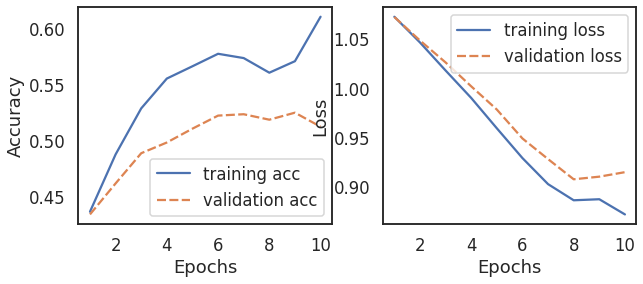

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 2351
[epoch 1] train_loss: 1.0869, train_acc:0.4018, val Loss: : 1.0890, val_acc: 0.405
[epoch 2] train_loss: 1.0674, train_acc:0.4860, val Loss: : 1.0895, val_acc: 0.400
[epoch 3] train_loss: 1.0460, train_acc:0.5382, val Loss: : 1.0902, val_acc: 0.386
[epoch 4] train_loss: 1.0233, train_acc:0.5595, val Loss: : 1.0894, val_acc: 0.384


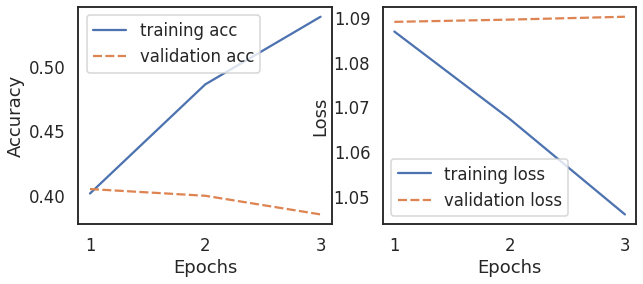

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_del_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0893, train_acc:0.3996, val Loss: : 1.1005, val_acc: 0.335
[epoch 2] train_loss: 1.0692, train_acc:0.4803, val Loss: : 1.0992, val_acc: 0.339
[epoch 3] train_loss: 1.0483, train_acc:0.5142, val Loss: : 1.0992, val_acc: 0.348
[epoch 4] train_loss: 1.0260, train_acc:0.5403, val Loss: : 1.0986, val_acc: 0.353
[epoch 5] train_loss: 1.0017, train_acc:0.5558, val Loss: : 1.0971, val_acc: 0.365
[epoch 6] train_loss: 0.9745, train_acc:0.5707, val Loss: : 1.0941, val_acc: 0.373
[epoch 7] train_loss: 0.9443, train_acc:0.5911, val Loss: : 1.0875, val_acc: 0.383
[epoch 8] train_loss: 0.9103, train_acc:0.6110, val Loss: : 1.0801, val_acc: 0.397
[epoch 9] train_loss: 0.8722, train_acc:0.6291, val Loss: : 1.0640, v

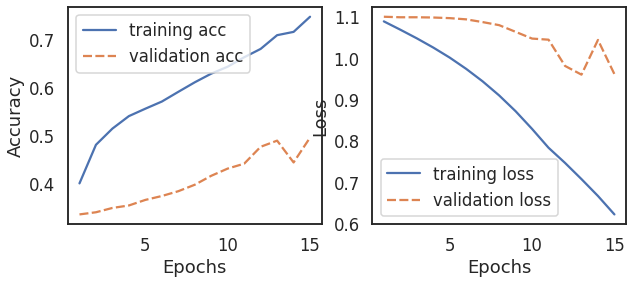

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_del_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0880, train_acc:0.3932, val Loss: : 1.0939, val_acc: 0.359
[epoch 2] train_loss: 1.0685, train_acc:0.4930, val Loss: : 1.0958, val_acc: 0.354
[epoch 3] train_loss: 1.0481, train_acc:0.5282, val Loss: : 1.0980, val_acc: 0.343
[epoch 4] train_loss: 1.0259, train_acc:0.5444, val Loss: : 1.1009, val_acc: 0.338


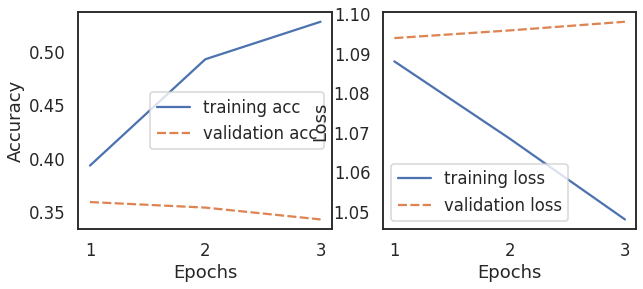

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_del_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0801, train_acc:0.4268, val Loss: : 1.0987, val_acc: 0.351
[epoch 2] train_loss: 1.0556, train_acc:0.4940, val Loss: : 1.1018, val_acc: 0.335
[epoch 3] train_loss: 1.0303, train_acc:0.5246, val Loss: : 1.1039, val_acc: 0.334
[epoch 4] train_loss: 1.0035, train_acc:0.5488, val Loss: : 1.1046, val_acc: 0.342


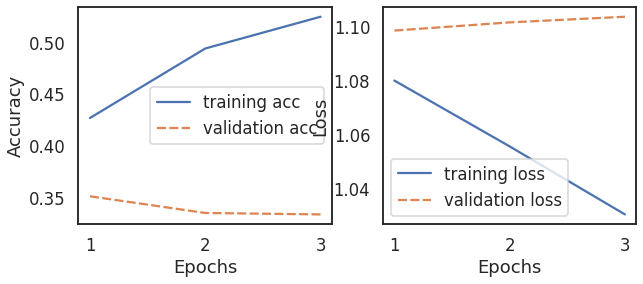

----------------------------------------------------------------------
acc_list [0.5086715227193895, 0.3964620187304891, 0.5081512313562262, 0.36038848421782865, 0.36264308012486995]
loss_list [0.9009283781051636, 1.0864733457565308, 0.9589440822601318, 1.0953618288040161, 1.0963122844696045]
precision_list [array([0.        , 0.53376835, 0.48019252]), array([0.07860262, 0.51574468, 0.53605016]), array([0.16966581, 0.560134  , 0.56215676]), array([0.08300589, 0.52965235, 0.49210823]), array([0.09051517, 0.50832224, 0.54890511])]
recall_list [array([0.        , 0.57605634, 0.51652728]), array([0.30361446, 0.64014085, 0.13620072]), array([0.31807229, 0.58873239, 0.44842692]), array([0.40722892, 0.36478873, 0.34767025]), array([0.45301205, 0.53767606, 0.14974114])]
fscore_list [array([0.        , 0.55410669, 0.49769762]), array([0.12487611, 0.57124902, 0.21721181]), array([0.22129086, 0.57407725, 0.49889233]), array([0.1379029 , 0.43202669, 0.40746791]), array([0.15088283, 0.52258727, 0.2

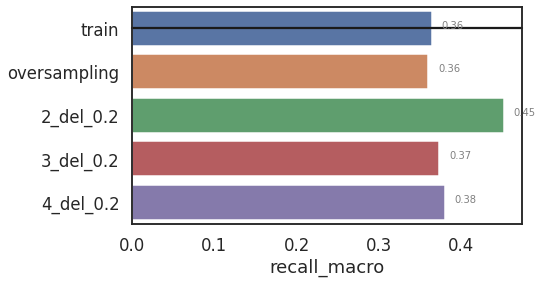

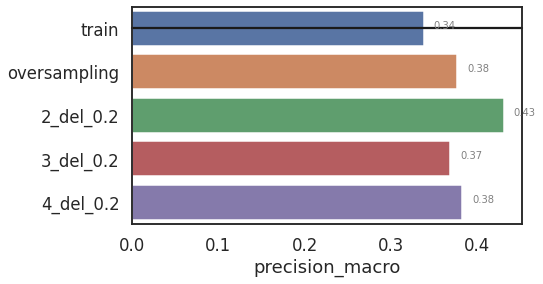

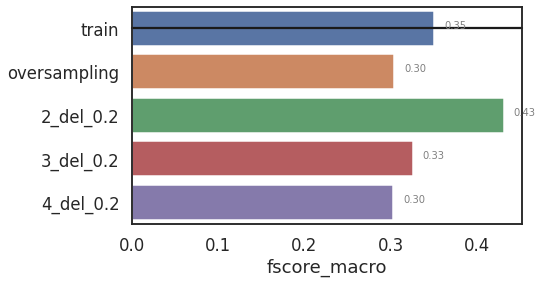

ratio 0.4
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0632, train_acc:0.4698, val Loss: : 1.0660, val_acc: 0.464
[epoch 2] train_loss: 1.0074, train_acc:0.5386, val Loss: : 1.0151, val_acc: 0.514
[epoch 3] train_loss: 0.9460, train_acc:0.5575, val Loss: : 0.9579, val_acc: 0.527
[epoch 4] train_loss: 0.8919, train_acc:0.5498, val Loss: : 0.9071, val_acc: 0.523
[epoch 5] train_loss: 0.8849, train_acc:0.5770, val Loss: : 0.9070, val_acc: 0.527
[epoch 6] train_loss: 0.8702, train_acc:0.5751, val Loss: : 0.9061, val_acc: 0.505
[epoch 7] train_loss: 0.8487, train_acc:0.6028, val Loss: : 0.8942, val_acc: 0.527
[epoch 8] train_loss: 0.8392, train_acc:0.6023, val Loss: : 0.8961, val_acc: 0.535
[epoch 9] train_loss: 0.8218, train_acc:0.6148, val Loss: : 0.8961, val_acc: 0.536


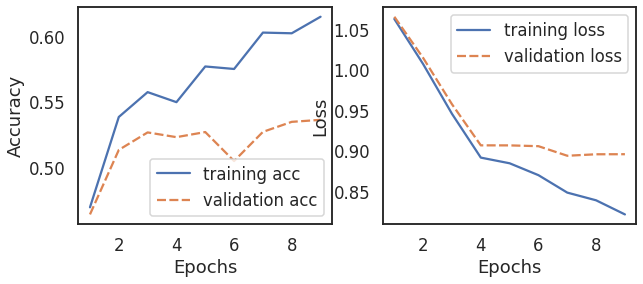

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 4802
[epoch 1] train_loss: 1.0735, train_acc:0.4472, val Loss: : 1.0942, val_acc: 0.383
[epoch 2] train_loss: 1.0398, train_acc:0.5081, val Loss: : 1.0919, val_acc: 0.373
[epoch 3] train_loss: 0.9986, train_acc:0.5406, val Loss: : 1.0845, val_acc: 0.392
[epoch 4] train_loss: 0.9443, train_acc:0.5802, val Loss: : 1.0694, val_acc: 0.419
[epoch 5] train_loss: 0.8750, train_acc:0.6063, val Loss: : 1.0380, val_acc: 0.451
[epoch 6] train_loss: 0.8058, train_acc:0.6451, val Loss: : 1.0116, val_acc: 0.479
[epoch 7] train_loss: 0.7279, train_acc:0.6863, val Loss: : 0.9671, val_acc: 0.500
[epoch 8] train_loss: 0.6590, train_acc:0.7196, val Loss: : 0.9554, val_acc: 0.523
[epoch 9] train_loss: 0.5894, train_acc:0.7522, val Lo

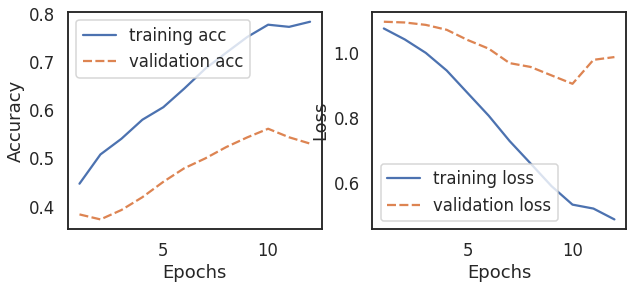

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_del_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0739, train_acc:0.4437, val Loss: : 1.1058, val_acc: 0.303
[epoch 2] train_loss: 1.0392, train_acc:0.5057, val Loss: : 1.1049, val_acc: 0.331
[epoch 3] train_loss: 0.9971, train_acc:0.5397, val Loss: : 1.0983, val_acc: 0.369
[epoch 4] train_loss: 0.9393, train_acc:0.5745, val Loss: : 1.0813, val_acc: 0.405
[epoch 5] train_loss: 0.8704, train_acc:0.6114, val Loss: : 1.0227, val_acc: 0.471
[epoch 6] train_loss: 0.8001, train_acc:0.6508, val Loss: : 0.9796, val_acc: 0.483
[epoch 7] train_loss: 0.7640, train_acc:0.6727, val Loss: : 0.9424, val_acc: 0.507
[epoch 8] train_loss: 0.6994, train_acc:0.6941, val Loss: : 1.0105, val_acc: 0.478
[epoch 9] train_loss: 0.6497, train_acc:0.7171, val Loss: : 0.9012, v

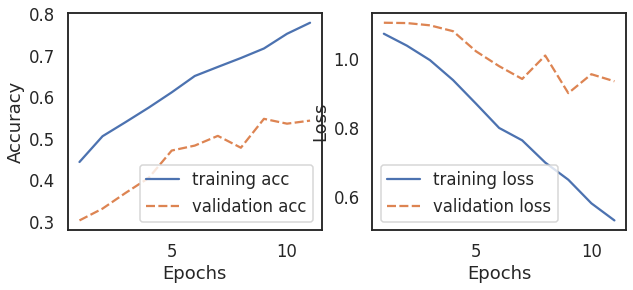

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_del_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0740, train_acc:0.4312, val Loss: : 1.1175, val_acc: 0.253
[epoch 2] train_loss: 1.0391, train_acc:0.4989, val Loss: : 1.1111, val_acc: 0.325
[epoch 3] train_loss: 0.9985, train_acc:0.5369, val Loss: : 1.1043, val_acc: 0.367
[epoch 4] train_loss: 0.9443, train_acc:0.5735, val Loss: : 1.0858, val_acc: 0.402
[epoch 5] train_loss: 0.8663, train_acc:0.6078, val Loss: : 1.0877, val_acc: 0.427
[epoch 6] train_loss: 0.8199, train_acc:0.6234, val Loss: : 1.1259, val_acc: 0.424
[epoch 7] train_loss: 0.7442, train_acc:0.6694, val Loss: : 1.0482, val_acc: 0.461
[epoch 8] train_loss: 0.6939, train_acc:0.6970, val Loss: : 0.9188, val_acc: 0.539
[epoch 9] train_loss: 0.6233, train_acc:0.7292, val Loss: : 0.9624, v

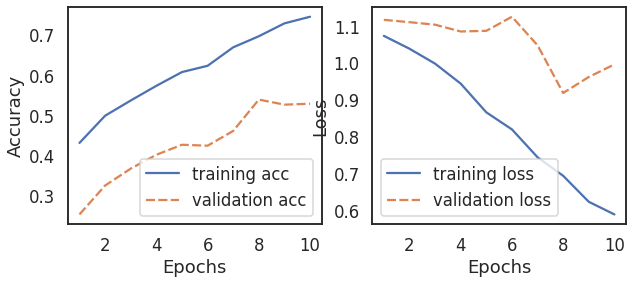

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_del_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0693, train_acc:0.4497, val Loss: : 1.0992, val_acc: 0.347
[epoch 2] train_loss: 1.0338, train_acc:0.5009, val Loss: : 1.1118, val_acc: 0.337
[epoch 3] train_loss: 0.9936, train_acc:0.5320, val Loss: : 1.1174, val_acc: 0.364
[epoch 4] train_loss: 0.9387, train_acc:0.5602, val Loss: : 1.1282, val_acc: 0.382


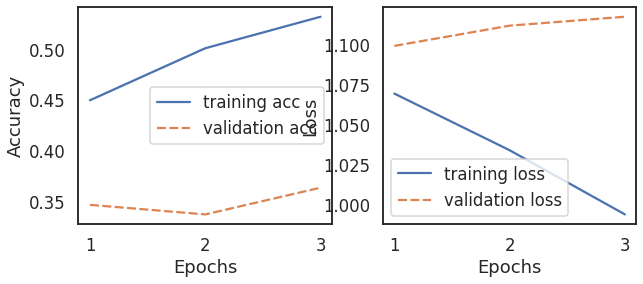

----------------------------------------------------------------------
acc_list [0.5392385392385393, 0.5688755688755689, 0.5608835608835608, 0.5201465201465202, 0.3540903540903541]
loss_list [0.8946101665496826, 0.9288703799247742, 0.928975522518158, 0.9711080193519592, 1.1402034759521484]
precision_list [array([0.5       , 0.54922644, 0.52217195]), array([0.25806452, 0.56675838, 0.67973547]), array([0.19525351, 0.58025608, 0.64797623]), array([0.1656051 , 0.61633987, 0.55231195]), array([0.0986911 , 0.53357438, 0.56719818])]
recall_list [array([0.00439239, 0.70265407, 0.44613402]), array([0.26939971, 0.78767431, 0.37087629]), array([0.26500732, 0.70332883, 0.44974227]), array([0.3045388 , 0.42420153, 0.66804124]), array([0.55197657, 0.46468736, 0.19252577])]
fscore_list [array([0.00870827, 0.61653839, 0.48116748]), array([0.26361032, 0.6592    , 0.47990662]), array([0.22484472, 0.63589222, 0.53095999]), array([0.21454358, 0.50253131, 0.60468914]), array([0.16744393, 0.49675403, 0.2874

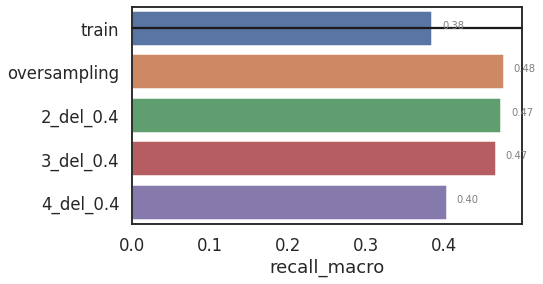

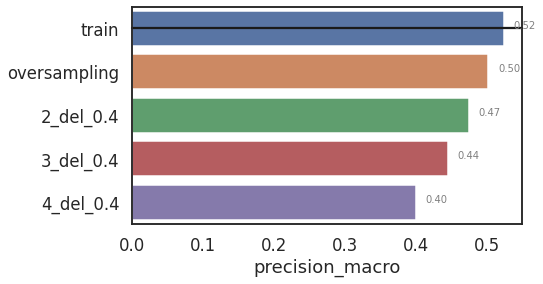

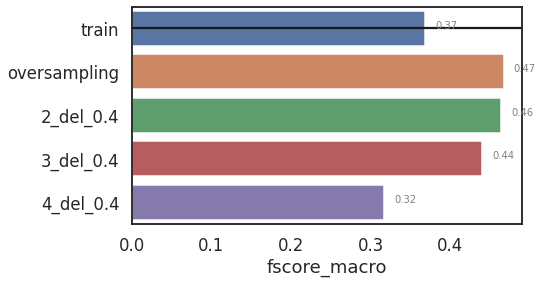

ratio 0.6
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0234, train_acc:0.5194, val Loss: : 1.0253, val_acc: 0.507
[epoch 2] train_loss: 0.9398, train_acc:0.5466, val Loss: : 0.9462, val_acc: 0.525
[epoch 3] train_loss: 0.8961, train_acc:0.5663, val Loss: : 0.9037, val_acc: 0.532
[epoch 4] train_loss: 0.8692, train_acc:0.5857, val Loss: : 0.8933, val_acc: 0.538
[epoch 5] train_loss: 0.8498, train_acc:0.5959, val Loss: : 0.8890, val_acc: 0.548
[epoch 6] train_loss: 0.8281, train_acc:0.6151, val Loss: : 0.8856, val_acc: 0.551
[epoch 7] train_loss: 0.8011, train_acc:0.6354, val Loss: : 0.8784, val_acc: 0.567
[epoch 8] train_loss: 0.7698, train_acc:0.6566, val Loss: : 0.8732, val_acc: 0.579
[epoch 9] train_loss: 0.7455, train_acc:0.6719, val Loss: : 0.8751, val_acc: 0.596


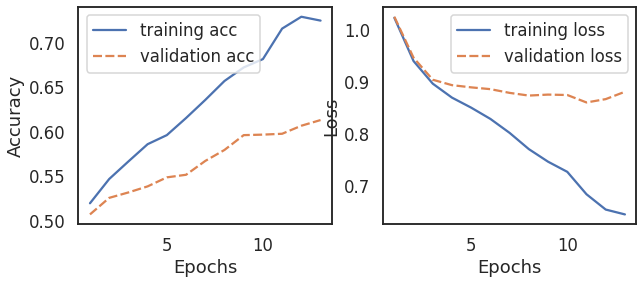

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 7128
[epoch 1] train_loss: 1.0650, train_acc:0.4603, val Loss: : 1.0954, val_acc: 0.354
[epoch 2] train_loss: 1.0180, train_acc:0.5064, val Loss: : 1.0845, val_acc: 0.389
[epoch 3] train_loss: 0.9447, train_acc:0.5623, val Loss: : 1.0574, val_acc: 0.435
[epoch 4] train_loss: 0.8529, train_acc:0.6105, val Loss: : 1.0019, val_acc: 0.486
[epoch 5] train_loss: 0.7668, train_acc:0.6577, val Loss: : 0.9809, val_acc: 0.499
[epoch 6] train_loss: 0.7008, train_acc:0.6928, val Loss: : 0.9915, val_acc: 0.503
[epoch 7] train_loss: 0.6062, train_acc:0.7420, val Loss: : 0.9384, val_acc: 0.546
[epoch 8] train_loss: 0.5660, train_acc:0.7578, val Loss: : 0.9739, val_acc: 0.535
[epoch 9] train_loss: 0.5179, train_acc:0.7782, val Lo

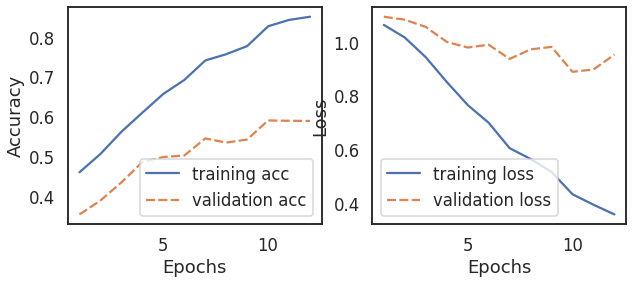

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_del_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0605, train_acc:0.4684, val Loss: : 1.1019, val_acc: 0.336
[epoch 2] train_loss: 1.0080, train_acc:0.5148, val Loss: : 1.0972, val_acc: 0.365
[epoch 3] train_loss: 0.9140, train_acc:0.5749, val Loss: : 1.0930, val_acc: 0.411
[epoch 4] train_loss: 0.8525, train_acc:0.6009, val Loss: : 1.1098, val_acc: 0.418
[epoch 5] train_loss: 0.7580, train_acc:0.6617, val Loss: : 0.9577, val_acc: 0.497
[epoch 6] train_loss: 0.6930, train_acc:0.6942, val Loss: : 0.9184, val_acc: 0.527
[epoch 7] train_loss: 0.6271, train_acc:0.7271, val Loss: : 0.9336, val_acc: 0.541
[epoch 8] train_loss: 0.5692, train_acc:0.7472, val Loss: : 0.9941, val_acc: 0.543
[epoch 9] train_loss: 0.5198, train_acc:0.7771, val Loss: : 0.9608, v

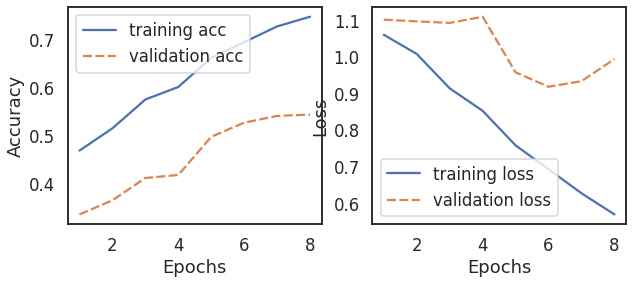

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_del_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0647, train_acc:0.4581, val Loss: : 1.1025, val_acc: 0.330
[epoch 2] train_loss: 1.0191, train_acc:0.5068, val Loss: : 1.1090, val_acc: 0.354
[epoch 3] train_loss: 0.9438, train_acc:0.5566, val Loss: : 1.0933, val_acc: 0.395
[epoch 4] train_loss: 0.8706, train_acc:0.5988, val Loss: : 0.9697, val_acc: 0.490
[epoch 5] train_loss: 0.7846, train_acc:0.6477, val Loss: : 0.9434, val_acc: 0.508
[epoch 6] train_loss: 0.7207, train_acc:0.6817, val Loss: : 0.9176, val_acc: 0.537
[epoch 7] train_loss: 0.6553, train_acc:0.7126, val Loss: : 0.9079, val_acc: 0.547
[epoch 8] train_loss: 0.5654, train_acc:0.7543, val Loss: : 0.9565, val_acc: 0.554
[epoch 9] train_loss: 0.5408, train_acc:0.7615, val Loss: : 1.0192, v

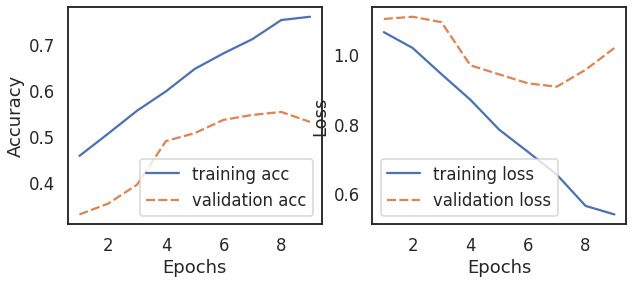

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_del_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0536, train_acc:0.4737, val Loss: : 1.1005, val_acc: 0.355
[epoch 2] train_loss: 0.9991, train_acc:0.5135, val Loss: : 1.1321, val_acc: 0.329
[epoch 3] train_loss: 0.9041, train_acc:0.5843, val Loss: : 1.0939, val_acc: 0.421
[epoch 4] train_loss: 0.8442, train_acc:0.6281, val Loss: : 0.9593, val_acc: 0.519
[epoch 5] train_loss: 0.7979, train_acc:0.6590, val Loss: : 0.9242, val_acc: 0.535
[epoch 6] train_loss: 0.6850, train_acc:0.7059, val Loss: : 0.9482, val_acc: 0.541
[epoch 7] train_loss: 0.6236, train_acc:0.7302, val Loss: : 0.9886, val_acc: 0.532
[epoch 8] train_loss: 0.5919, train_acc:0.7438, val Loss: : 0.9595, val_acc: 0.552


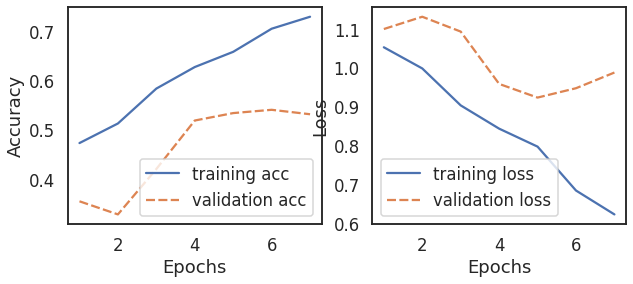

----------------------------------------------------------------------
acc_list [0.6134976134976134, 0.5845265845265846, 0.4986124986124986, 0.554001554001554, 0.535020535020535]
loss_list [0.8628550171852112, 0.985171377658844, 1.0266767740249634, 0.9430917501449585, 0.972196102142334]
precision_list [array([0.31666667, 0.61844738, 0.61174386]), array([0.18157895, 0.62249646, 0.67737526]), array([0.15041906, 0.59885536, 0.63802622]), array([0.18412162, 0.62052877, 0.5996975 ]), array([0.14647887, 0.6426799 , 0.58190149])]
recall_list [array([0.02781845, 0.69523167, 0.62293814]), array([0.30307467, 0.69208277, 0.51082474]), array([0.49926794, 0.51776878, 0.47654639]), array([0.31918009, 0.53846154, 0.61314433]), array([0.3045388 , 0.46603689, 0.65463918])]
fscore_list [array([0.05114401, 0.65459551, 0.61729026]), array([0.22709819, 0.65544786, 0.58242727]), array([0.23118644, 0.55536791, 0.54558867]), array([0.23352973, 0.5765896 , 0.60634637]), array([0.19781265, 0.54028683, 0.6161309

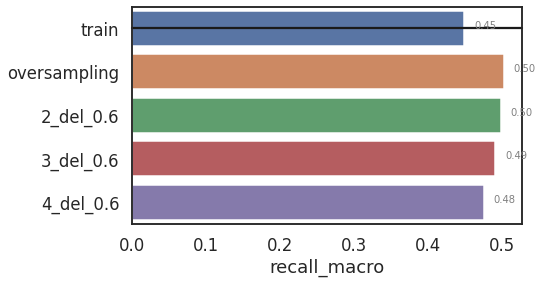

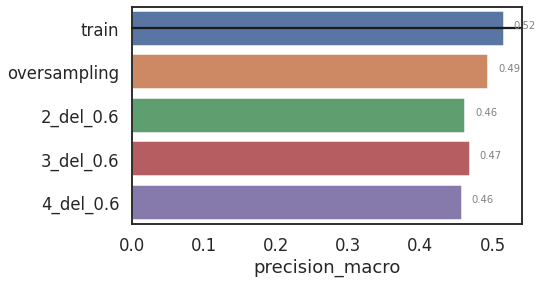

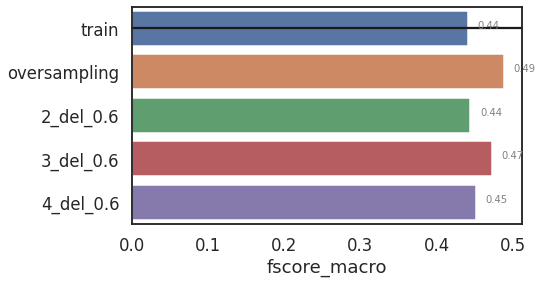

ratio 0.8
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0269, train_acc:0.4992, val Loss: : 1.0315, val_acc: 0.474
[epoch 2] train_loss: 0.9057, train_acc:0.5480, val Loss: : 0.9116, val_acc: 0.529
[epoch 3] train_loss: 0.8884, train_acc:0.5651, val Loss: : 0.9003, val_acc: 0.527
[epoch 4] train_loss: 0.8628, train_acc:0.5806, val Loss: : 0.8895, val_acc: 0.545
[epoch 5] train_loss: 0.8418, train_acc:0.6013, val Loss: : 0.8857, val_acc: 0.545
[epoch 6] train_loss: 0.8122, train_acc:0.6229, val Loss: : 0.8759, val_acc: 0.553
[epoch 7] train_loss: 0.7746, train_acc:0.6533, val Loss: : 0.8660, val_acc: 0.584
[epoch 8] train_loss: 0.7425, train_acc:0.6709, val Loss: : 0.8676, val_acc: 0.602
[epoch 9] train_loss: 0.6980, train_acc:0.7025, val Loss: : 0.8489, val_acc: 0.610


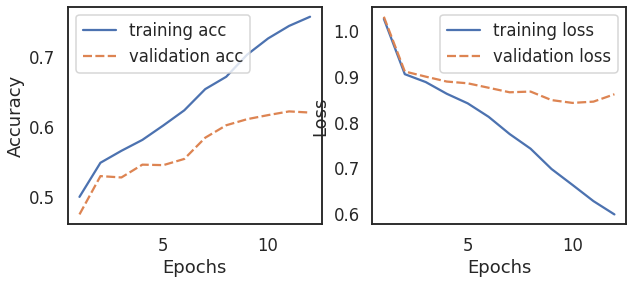

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 9488
[epoch 1] train_loss: 1.0592, train_acc:0.4756, val Loss: : 1.0869, val_acc: 0.393
[epoch 2] train_loss: 0.9884, train_acc:0.5248, val Loss: : 1.0770, val_acc: 0.412
[epoch 3] train_loss: 0.8804, train_acc:0.5862, val Loss: : 1.0262, val_acc: 0.471
[epoch 4] train_loss: 0.7781, train_acc:0.6531, val Loss: : 1.0068, val_acc: 0.481
[epoch 5] train_loss: 0.6808, train_acc:0.7016, val Loss: : 0.8908, val_acc: 0.567
[epoch 6] train_loss: 0.6006, train_acc:0.7375, val Loss: : 0.9505, val_acc: 0.550
[epoch 7] train_loss: 0.5108, train_acc:0.7899, val Loss: : 0.9018, val_acc: 0.577
[epoch 8] train_loss: 0.4444, train_acc:0.8191, val Loss: : 0.8985, val_acc: 0.600


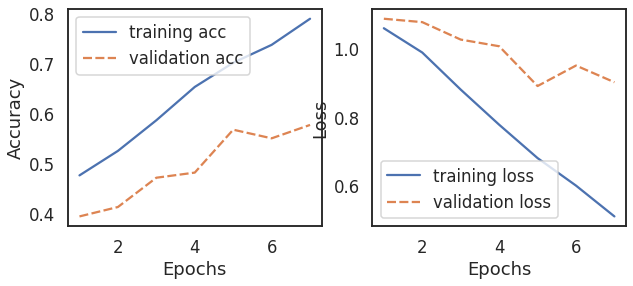

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_del_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0557, train_acc:0.4738, val Loss: : 1.1040, val_acc: 0.329
[epoch 2] train_loss: 0.9761, train_acc:0.5341, val Loss: : 1.0778, val_acc: 0.408
[epoch 3] train_loss: 0.8653, train_acc:0.5952, val Loss: : 1.0619, val_acc: 0.430
[epoch 4] train_loss: 0.7943, train_acc:0.6400, val Loss: : 1.0334, val_acc: 0.461
[epoch 5] train_loss: 0.6898, train_acc:0.6989, val Loss: : 0.9348, val_acc: 0.535
[epoch 6] train_loss: 0.6150, train_acc:0.7310, val Loss: : 0.9218, val_acc: 0.569
[epoch 7] train_loss: 0.5506, train_acc:0.7698, val Loss: : 0.9153, val_acc: 0.564
[epoch 8] train_loss: 0.5088, train_acc:0.7851, val Loss: : 0.9942, val_acc: 0.552
[epoch 9] train_loss: 0.4377, train_acc:0.8211, val Loss: : 0.9556, v

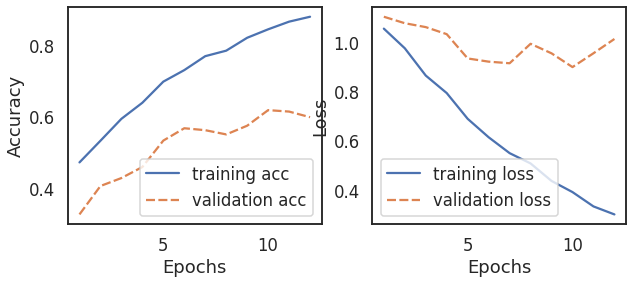

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_del_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0462, train_acc:0.4696, val Loss: : 1.1133, val_acc: 0.311
[epoch 2] train_loss: 0.9579, train_acc:0.5370, val Loss: : 1.1210, val_acc: 0.373
[epoch 3] train_loss: 0.8687, train_acc:0.5995, val Loss: : 0.9560, val_acc: 0.494
[epoch 4] train_loss: 0.7621, train_acc:0.6528, val Loss: : 0.9857, val_acc: 0.482
[epoch 5] train_loss: 0.6968, train_acc:0.6856, val Loss: : 1.0228, val_acc: 0.489
[epoch 6] train_loss: 0.6252, train_acc:0.7224, val Loss: : 1.0423, val_acc: 0.527


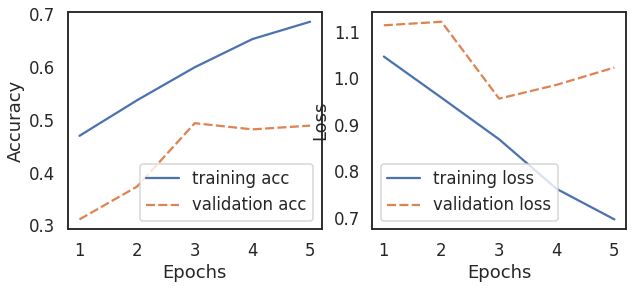

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_del_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0426, train_acc:0.4712, val Loss: : 1.1138, val_acc: 0.310
[epoch 2] train_loss: 0.9516, train_acc:0.5421, val Loss: : 1.1180, val_acc: 0.377
[epoch 3] train_loss: 0.8946, train_acc:0.5770, val Loss: : 0.9329, val_acc: 0.516
[epoch 4] train_loss: 0.7889, train_acc:0.6385, val Loss: : 0.9245, val_acc: 0.516
[epoch 5] train_loss: 0.6876, train_acc:0.6925, val Loss: : 0.9551, val_acc: 0.522
[epoch 6] train_loss: 0.6308, train_acc:0.7242, val Loss: : 0.9981, val_acc: 0.517
[epoch 7] train_loss: 0.5684, train_acc:0.7527, val Loss: : 1.0134, val_acc: 0.551


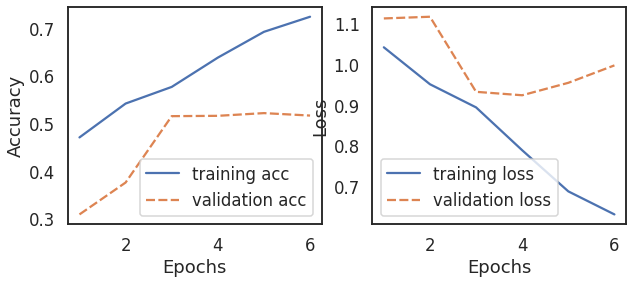

----------------------------------------------------------------------
acc_list [0.5965145965145965, 0.5857475857475858, 0.6113886113886113, 0.4913974913974914, 0.5433455433455433]
loss_list [0.8868357539176941, 0.895935595035553, 0.9797837734222412, 1.0603561401367188, 0.9984410405158997]
precision_list [array([0.16908213, 0.6428396 , 0.59394341]), array([0.21860149, 0.63858447, 0.68377693]), array([0.23794212, 0.6262146 , 0.65661972]), array([0.1465721 , 0.59590599, 0.67501989]), array([0.17160162, 0.61868421, 0.61482675])]
recall_list [array([0.10248902, 0.58861898, 0.69252577]), array([0.47144949, 0.62910481, 0.55618557]), array([0.21669107, 0.68128655, 0.6007732 ]), array([0.54465593, 0.53036437, 0.43737113]), array([0.37335286, 0.52878992, 0.58994845])]
fscore_list [array([0.12762078, 0.61453563, 0.6394574 ]), array([0.2987013 , 0.6338092 , 0.61341671]), array([0.22681992, 0.65259076, 0.62745626]), array([0.23098417, 0.56122813, 0.53081013]), array([0.2351314 , 0.57021586, 0.6021

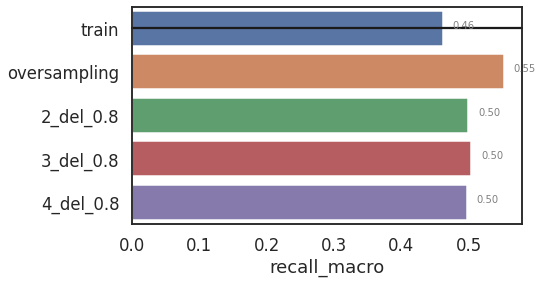

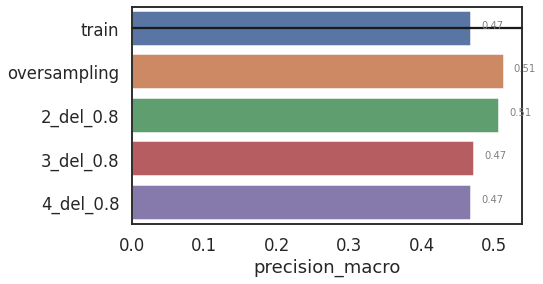

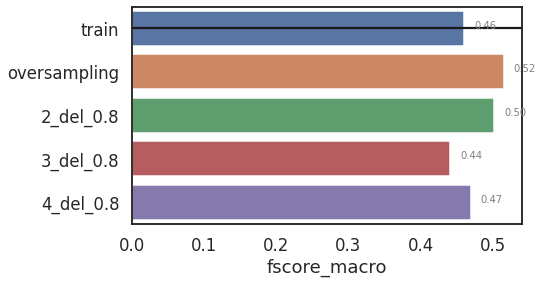

ratio 1
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9778, train_acc:0.5299, val Loss: : 0.9803, val_acc: 0.519
[epoch 2] train_loss: 0.9081, train_acc:0.5531, val Loss: : 0.9127, val_acc: 0.528
[epoch 3] train_loss: 0.8681, train_acc:0.5729, val Loss: : 0.8878, val_acc: 0.538
[epoch 4] train_loss: 0.8440, train_acc:0.5972, val Loss: : 0.8819, val_acc: 0.544
[epoch 5] train_loss: 0.8074, train_acc:0.6269, val Loss: : 0.8670, val_acc: 0.567
[epoch 6] train_loss: 0.7616, train_acc:0.6588, val Loss: : 0.8484, val_acc: 0.612
[epoch 7] train_loss: 0.7167, train_acc:0.6868, val Loss: : 0.8337, val_acc: 0.625
[epoch 8] train_loss: 0.6838, train_acc:0.7121, val Loss: : 0.8363, val_acc: 0.627
[epoch 9] train_loss: 0.6451, train_acc:0.7275, val Loss: : 0.8302, val_acc: 0.638
[e

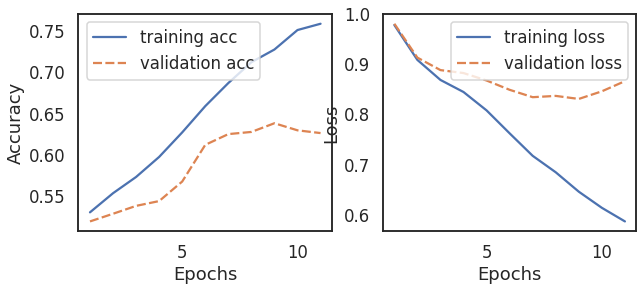

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 11850
[epoch 1] train_loss: 1.0493, train_acc:0.4713, val Loss: : 1.0966, val_acc: 0.369
[epoch 2] train_loss: 0.9449, train_acc:0.5547, val Loss: : 1.0483, val_acc: 0.443
[epoch 3] train_loss: 0.8198, train_acc:0.6232, val Loss: : 0.9341, val_acc: 0.505
[epoch 4] train_loss: 0.7030, train_acc:0.6900, val Loss: : 0.9210, val_acc: 0.542
[epoch 5] train_loss: 0.6097, train_acc:0.7386, val Loss: : 0.8877, val_acc: 0.564
[epoch 6] train_loss: 0.5307, train_acc:0.7801, val Loss: : 0.8668, val_acc: 0.593
[epoch 7] train_loss: 0.4578, train_acc:0.8075, val Loss: : 0.8935, val_acc: 0.603
[epoch 8] train_loss: 0.4005, train_acc:0.8349, val Loss: : 0.8950, val_acc: 0.617
[epoch 9] train_loss: 0.3531, train_acc:0.8550, val L

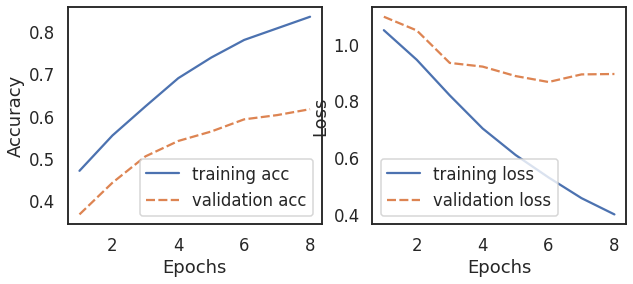

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_del_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0456, train_acc:0.4732, val Loss: : 1.1118, val_acc: 0.328
[epoch 2] train_loss: 0.9395, train_acc:0.5578, val Loss: : 1.0939, val_acc: 0.427
[epoch 3] train_loss: 0.8205, train_acc:0.6232, val Loss: : 1.0280, val_acc: 0.463
[epoch 4] train_loss: 0.7199, train_acc:0.6811, val Loss: : 0.8954, val_acc: 0.555
[epoch 5] train_loss: 0.6189, train_acc:0.7321, val Loss: : 0.9466, val_acc: 0.547
[epoch 6] train_loss: 0.5651, train_acc:0.7604, val Loss: : 0.8457, val_acc: 0.607
[epoch 7] train_loss: 0.4863, train_acc:0.7941, val Loss: : 0.8896, val_acc: 0.594
[epoch 8] train_loss: 0.4459, train_acc:0.8077, val Loss: : 0.9229, val_acc: 0.589
[epoch 9] train_loss: 0.3846, train_acc:0.8422, val Loss: : 0.9270, val

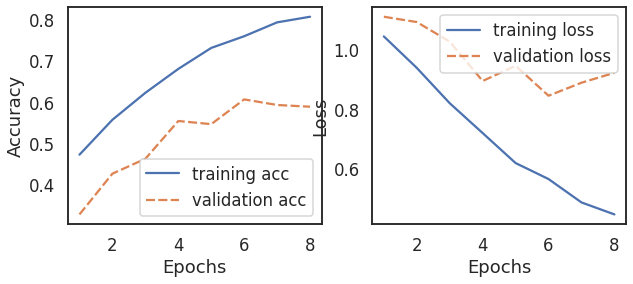

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_del_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0393, train_acc:0.4747, val Loss: : 1.1146, val_acc: 0.329
[epoch 2] train_loss: 0.9314, train_acc:0.5594, val Loss: : 1.0776, val_acc: 0.435
[epoch 3] train_loss: 0.8169, train_acc:0.6186, val Loss: : 0.9110, val_acc: 0.526
[epoch 4] train_loss: 0.7115, train_acc:0.6823, val Loss: : 0.9794, val_acc: 0.508
[epoch 5] train_loss: 0.6401, train_acc:0.7199, val Loss: : 0.8713, val_acc: 0.582
[epoch 6] train_loss: 0.5351, train_acc:0.7744, val Loss: : 0.8888, val_acc: 0.582
[epoch 7] train_loss: 0.4809, train_acc:0.7963, val Loss: : 0.9432, val_acc: 0.582
[epoch 8] train_loss: 0.4198, train_acc:0.8261, val Loss: : 0.9057, val_acc: 0.603


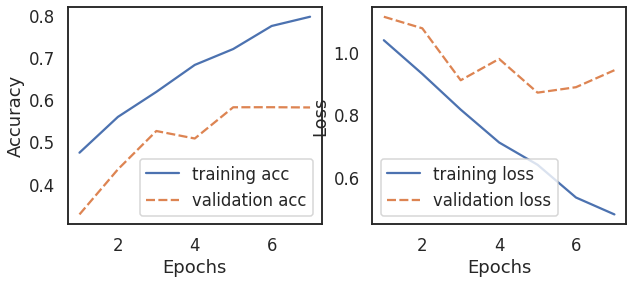

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_del_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0315, train_acc:0.4838, val Loss: : 1.1086, val_acc: 0.329
[epoch 2] train_loss: 0.8883, train_acc:0.5815, val Loss: : 1.0499, val_acc: 0.437
[epoch 3] train_loss: 0.8320, train_acc:0.6172, val Loss: : 0.9136, val_acc: 0.514
[epoch 4] train_loss: 0.7355, train_acc:0.6806, val Loss: : 0.9336, val_acc: 0.548
[epoch 5] train_loss: 0.6260, train_acc:0.7256, val Loss: : 0.8912, val_acc: 0.578
[epoch 6] train_loss: 0.5678, train_acc:0.7576, val Loss: : 0.8669, val_acc: 0.603
[epoch 7] train_loss: 0.4937, train_acc:0.7958, val Loss: : 0.8701, val_acc: 0.609
[epoch 8] train_loss: 0.4267, train_acc:0.8260, val Loss: : 0.9132, val_acc: 0.607
[epoch 9] train_loss: 0.3868, train_acc:0.8433, val Loss: : 0.9487, val

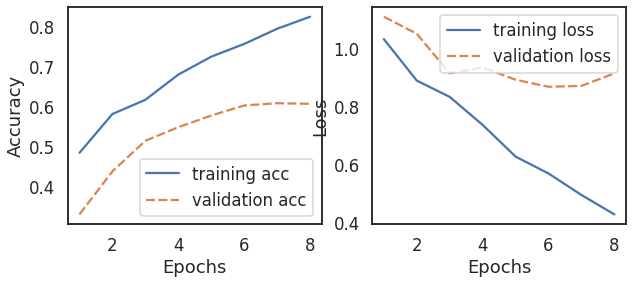

----------------------------------------------------------------------
acc_list [0.6302586302586303, 0.5934065934065934, 0.6108336108336109, 0.5887445887445888, 0.5763125763125763]
loss_list [0.8799952864646912, 0.9470006823539734, 0.9203355312347412, 0.9141159653663635, 0.9882472157478333]
precision_list [array([0.34210526, 0.64091007, 0.62629839]), array([0.22659733, 0.65074257, 0.66574662]), array([0.23622047, 0.61164695, 0.736     ]), array([0.21690141, 0.63771237, 0.63957503]), array([0.19417476, 0.6369863 , 0.64991625])]
recall_list [array([0.05710102, 0.67161493, 0.68376289]), array([0.4465593 , 0.59131804, 0.62164948]), array([0.30746706, 0.75596041, 0.49793814]), array([0.33821376, 0.5994152 , 0.62061856]), array([0.3806735 , 0.58569501, 0.6       ])]
fscore_list [array([0.097867  , 0.65590335, 0.65377033]), array([0.30064071, 0.61960877, 0.64294282]), array([0.26717557, 0.67618952, 0.59400461]), array([0.26430206, 0.61797101, 0.62995422]), array([0.25717112, 0.61026482, 0.623

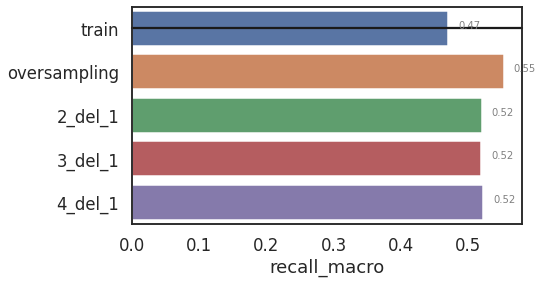

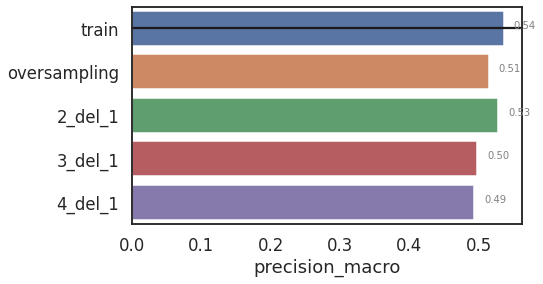

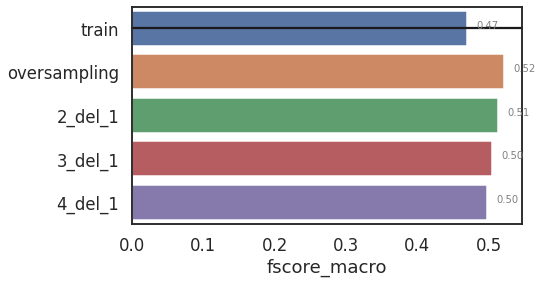

CPU times: user 16min 22s, sys: 20.1 s, total: 16min 42s
Wall time: 16min 39s


In [ ]:
%%time
      
task_name = 'sub_twitter'
tech_name = 'EDA'
ratios = [0.2, 0.4, 0.6, 0.8, 1]
for ratio in ratios:
  print('ratio', ratio)
  if ratio == 0.2:
    test_list = ['train',
                 'oversampling',
                 '2_del_0.2',
      '3_del_0.2',
      '4_del_0.2',
      ]
    print('<'*50)
    # print('ratio', ratio)
  if ratio == 0.4:
    test_list = ['train',
                 'oversampling',
                 '2_del_0.4',
      '3_del_0.4',
      '4_del_0.4',
      ]
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.6:
    test_list = ['train',
                 'oversampling',
                 '2_del_0.6',
      '3_del_0.6',
      '4_del_0.6',
      ]
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.8:
    test_list = ['train',
                 'oversampling',
                 '2_del_0.8',
      '3_del_0.8',
      '4_del_0.8',
      ]
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 1:
    test_list = ['train',
                 'oversampling',
                 '2_del_1',
      '3_del_1',
      '4_del_1',
      ]

    print('<'*50)

  Execute(test_list, task_name, tech_name, ratio)

## Pretrain BERT

### *Fasttext_augmentation* (various ratio) (test set)

#### New

ratio 0.2
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0852, train_acc:0.4026, val Loss: : 1.0877, val_acc: 0.398
[epoch 2] train_loss: 1.0577, train_acc:0.4975, val Loss: : 1.0635, val_acc: 0.461
[epoch 3] train_loss: 1.0289, train_acc:0.5422, val Loss: : 1.0393, val_acc: 0.490
[epoch 4] train_loss: 0.9997, train_acc:0.5672, val Loss: : 1.0148, val_acc: 0.502
[epoch 5] train_loss: 0.9713, train_acc:0.5837, val Loss: : 0.9893, val_acc: 0.514
[epoch 6] train_loss: 0.9377, train_acc:0.5976, val Loss: : 0.9626, val_acc: 0.517
[epoch 7] train_loss: 0.9070, train_acc:0.6052, val Loss: : 0.9349, val_acc: 0.518
[epoch 8] train_loss: 0.8767, train_acc:0.6088, val Loss: : 0.9092, val_acc: 0.523
[epoch 9] train_loss: 0.8620, train_acc:0.6075, val Loss: : 0.8986, val_acc: 0.521


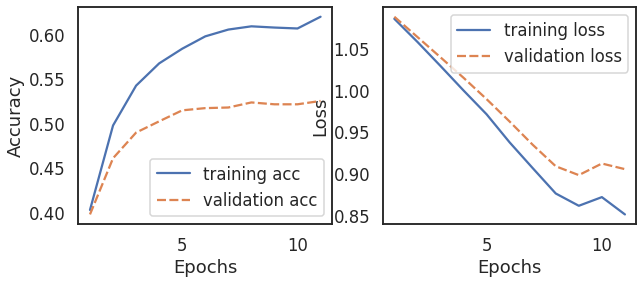

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 2351
[epoch 1] train_loss: 1.0859, train_acc:0.4052, val Loss: : 1.0990, val_acc: 0.349
[epoch 2] train_loss: 1.0649, train_acc:0.4936, val Loss: : 1.0941, val_acc: 0.367
[epoch 3] train_loss: 1.0426, train_acc:0.5315, val Loss: : 1.0874, val_acc: 0.381
[epoch 4] train_loss: 1.0185, train_acc:0.5481, val Loss: : 1.0816, val_acc: 0.397
[epoch 5] train_loss: 0.9918, train_acc:0.5625, val Loss: : 1.0737, val_acc: 0.410
[epoch 6] train_loss: 0.9627, train_acc:0.5816, val Loss: : 1.0658, val_acc: 0.418
[epoch 7] train_loss: 0.9300, train_acc:0.6023, val Loss: : 1.0542, val_acc: 0.425
[epoch 8] train_loss: 0.8927, train_acc:0.6227, val Loss: : 1.0416, val_acc: 0.439
[epoch 9] train_loss: 0.8520, train_acc:0.6317, val Lo

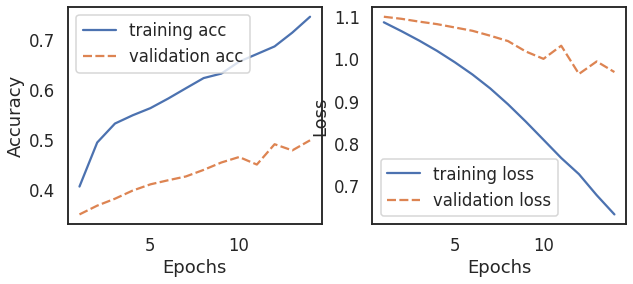

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0851, train_acc:0.4226, val Loss: : 1.1044, val_acc: 0.319
[epoch 2] train_loss: 1.0637, train_acc:0.4835, val Loss: : 1.0955, val_acc: 0.357
[epoch 3] train_loss: 1.0408, train_acc:0.5337, val Loss: : 1.0875, val_acc: 0.380
[epoch 4] train_loss: 1.0158, train_acc:0.5620, val Loss: : 1.0804, val_acc: 0.394
[epoch 5] train_loss: 0.9883, train_acc:0.5841, val Loss: : 1.0706, val_acc: 0.405
[epoch 6] train_loss: 0.9579, train_acc:0.5991, val Loss: : 1.0593, val_acc: 0.416
[epoch 7] train_loss: 0.9244, train_acc:0.6113, val Loss: : 1.0450, val_acc: 0.431
[epoch 8] train_loss: 0.8866, train_acc:0.6255, val Loss: : 1.0270, val_acc: 0.448
[epoch 9] train_loss: 0.8429, train_acc:0.6451, val Loss: : 0.9955, v

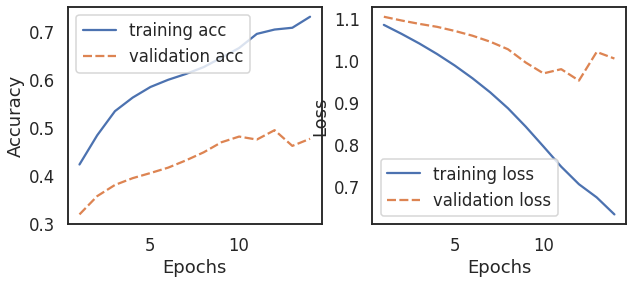

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0847, train_acc:0.4172, val Loss: : 1.0991, val_acc: 0.347
[epoch 2] train_loss: 1.0608, train_acc:0.4895, val Loss: : 1.0908, val_acc: 0.364
[epoch 3] train_loss: 1.0358, train_acc:0.5371, val Loss: : 1.0813, val_acc: 0.389
[epoch 4] train_loss: 1.0084, train_acc:0.5673, val Loss: : 1.0704, val_acc: 0.414
[epoch 5] train_loss: 0.9784, train_acc:0.5824, val Loss: : 1.0582, val_acc: 0.430
[epoch 6] train_loss: 0.9455, train_acc:0.6000, val Loss: : 1.0430, val_acc: 0.445
[epoch 7] train_loss: 0.9092, train_acc:0.6192, val Loss: : 1.0233, val_acc: 0.451
[epoch 8] train_loss: 0.8671, train_acc:0.6344, val Loss: : 0.9945, val_acc: 0.471
[epoch 9] train_loss: 0.8234, train_acc:0.6500, val Loss: : 0.9512, v

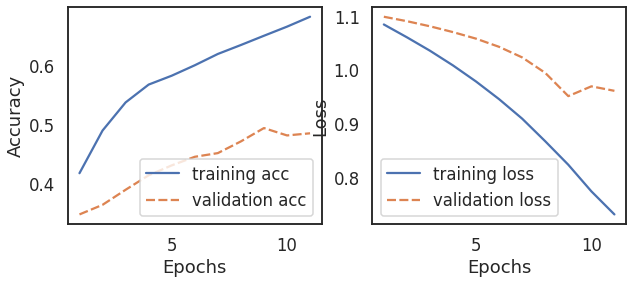

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0861, train_acc:0.4057, val Loss: : 1.0926, val_acc: 0.378
[epoch 2] train_loss: 1.0634, train_acc:0.5022, val Loss: : 1.0852, val_acc: 0.395
[epoch 3] train_loss: 1.0392, train_acc:0.5367, val Loss: : 1.0769, val_acc: 0.408
[epoch 4] train_loss: 1.0127, train_acc:0.5637, val Loss: : 1.0678, val_acc: 0.421
[epoch 5] train_loss: 0.9828, train_acc:0.5862, val Loss: : 1.0566, val_acc: 0.432
[epoch 6] train_loss: 0.9496, train_acc:0.5999, val Loss: : 1.0420, val_acc: 0.441
[epoch 7] train_loss: 0.9112, train_acc:0.6125, val Loss: : 1.0193, val_acc: 0.458
[epoch 8] train_loss: 0.8684, train_acc:0.6190, val Loss: : 0.9870, val_acc: 0.475
[epoch 9] train_loss: 0.8247, train_acc:0.6335, val Loss: : 0.9594, v

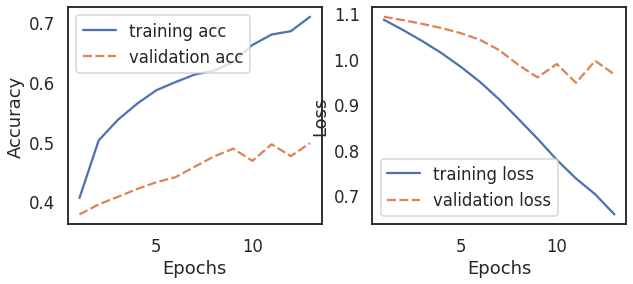

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0852, train_acc:0.4106, val Loss: : 1.0835, val_acc: 0.415
[epoch 2] train_loss: 1.0643, train_acc:0.4863, val Loss: : 1.0816, val_acc: 0.419
[epoch 3] train_loss: 1.0421, train_acc:0.5390, val Loss: : 1.0816, val_acc: 0.411
[epoch 4] train_loss: 1.0178, train_acc:0.5631, val Loss: : 1.0799, val_acc: 0.405
[epoch 5] train_loss: 0.9910, train_acc:0.5747, val Loss: : 1.0775, val_acc: 0.402
[epoch 6] train_loss: 0.9614, train_acc:0.5890, val Loss: : 1.0744, val_acc: 0.402
[epoch 7] train_loss: 0.9292, train_acc:0.6023, val Loss: : 1.0667, val_acc: 0.411
[epoch 8] train_loss: 0.8918, train_acc:0.6163, val Loss: : 1.0546, val_acc: 0.423
[epoch 9] train_loss: 0.8510, train_acc:0.6372, val Loss: : 1.0389, v

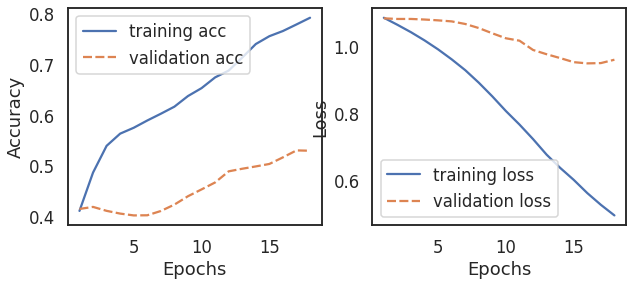

----------------------------------------------------------------------
acc_list [0.5205905205905206, 0.5048285048285048, 0.4933954933954934, 0.4862914862914863, 0.49894549894549894, 0.5533355533355533]
loss_list [0.9013603329658508, 0.9754229187965393, 0.9711476564407349, 0.972659170627594, 0.9494554996490479, 0.9447448253631592]
precision_list [array([0.        , 0.54460285, 0.49182727]), array([0.16394716, 0.554586  , 0.57582846]), array([0.14527027, 0.57509558, 0.52053807]), array([0.16135204, 0.56450803, 0.54353486]), array([0.1595941 , 0.54739238, 0.54219205]), array([0.18524333, 0.59069056, 0.57007376])]
recall_list [array([0.        , 0.6014395 , 0.51958763]), array([0.30893119, 0.64327485, 0.3806701 ]), array([0.25183016, 0.47368421, 0.55850515]), array([0.3704246 , 0.50584795, 0.48427835]), array([0.25329429, 0.59491678, 0.43221649]), array([0.1727672 , 0.60796221, 0.55773196])]
fscore_list [array([0.        , 0.5716118 , 0.50532648]), array([0.2142132 , 0.59564719, 0.4583398 

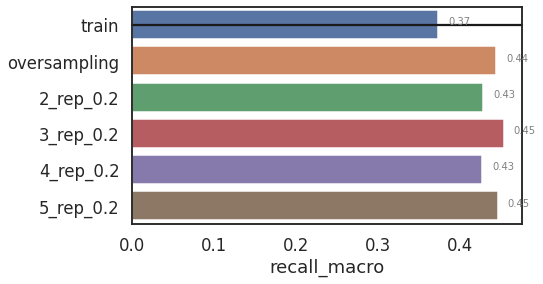

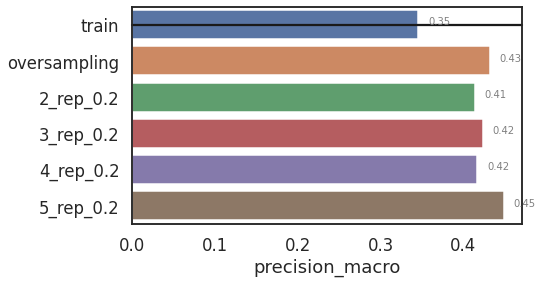

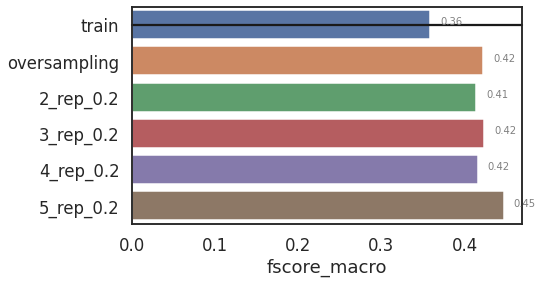

ratio 0.4
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0496, train_acc:0.4862, val Loss: : 1.0510, val_acc: 0.481
[epoch 2] train_loss: 0.9939, train_acc:0.5379, val Loss: : 1.0003, val_acc: 0.517
[epoch 3] train_loss: 0.9326, train_acc:0.5623, val Loss: : 0.9445, val_acc: 0.524
[epoch 4] train_loss: 0.8815, train_acc:0.5720, val Loss: : 0.8976, val_acc: 0.529
[epoch 5] train_loss: 0.8841, train_acc:0.5832, val Loss: : 0.9075, val_acc: 0.531
[epoch 6] train_loss: 0.8547, train_acc:0.5958, val Loss: : 0.8925, val_acc: 0.531
[epoch 7] train_loss: 0.8414, train_acc:0.6061, val Loss: : 0.8916, val_acc: 0.538
[epoch 8] train_loss: 0.8247, train_acc:0.6197, val Loss: : 0.8912, val_acc: 0.543
[epoch 9] train_loss: 0.8077, train_acc:0.6371, val Loss: : 0.8885, val_acc: 0.546


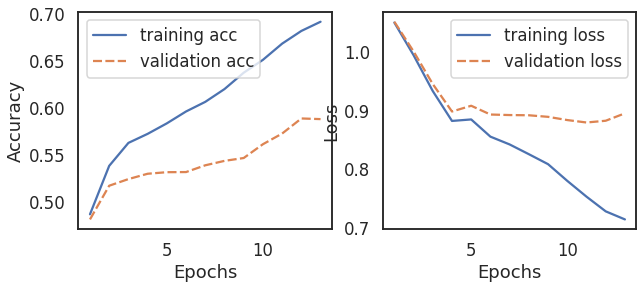

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 4802
[epoch 1] train_loss: 1.0716, train_acc:0.4513, val Loss: : 1.0981, val_acc: 0.354
[epoch 2] train_loss: 1.0365, train_acc:0.5099, val Loss: : 1.0942, val_acc: 0.374
[epoch 3] train_loss: 0.9925, train_acc:0.5484, val Loss: : 1.0831, val_acc: 0.396
[epoch 4] train_loss: 0.9315, train_acc:0.5834, val Loss: : 1.0521, val_acc: 0.433
[epoch 5] train_loss: 0.8581, train_acc:0.6092, val Loss: : 1.0303, val_acc: 0.454
[epoch 6] train_loss: 0.7925, train_acc:0.6371, val Loss: : 0.9448, val_acc: 0.497
[epoch 7] train_loss: 0.7161, train_acc:0.6896, val Loss: : 0.9526, val_acc: 0.496
[epoch 8] train_loss: 0.6723, train_acc:0.7037, val Loss: : 0.9015, val_acc: 0.538
[epoch 9] train_loss: 0.6415, train_acc:0.7116, val Lo

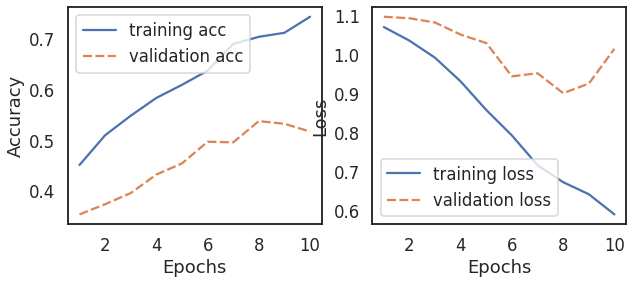

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0700, train_acc:0.4601, val Loss: : 1.0990, val_acc: 0.334
[epoch 2] train_loss: 1.0316, train_acc:0.5204, val Loss: : 1.0835, val_acc: 0.379
[epoch 3] train_loss: 0.9819, train_acc:0.5558, val Loss: : 1.0612, val_acc: 0.408
[epoch 4] train_loss: 0.9066, train_acc:0.5918, val Loss: : 0.9923, val_acc: 0.465
[epoch 5] train_loss: 0.8248, train_acc:0.6196, val Loss: : 1.0213, val_acc: 0.444
[epoch 6] train_loss: 0.7846, train_acc:0.6372, val Loss: : 0.9317, val_acc: 0.498
[epoch 7] train_loss: 0.7157, train_acc:0.6807, val Loss: : 0.9106, val_acc: 0.513
[epoch 8] train_loss: 0.6849, train_acc:0.6956, val Loss: : 1.0213, val_acc: 0.470
[epoch 9] train_loss: 0.6238, train_acc:0.7262, val Loss: : 0.8935, v

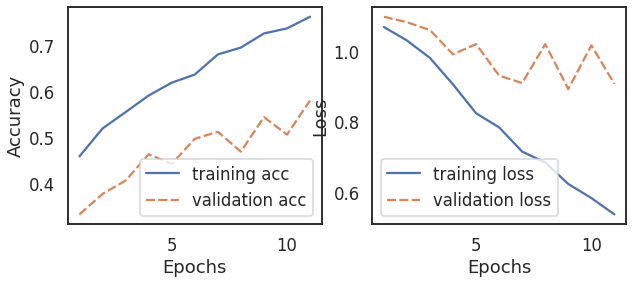

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0700, train_acc:0.4606, val Loss: : 1.1000, val_acc: 0.339
[epoch 2] train_loss: 1.0300, train_acc:0.5154, val Loss: : 1.0799, val_acc: 0.398
[epoch 3] train_loss: 0.9792, train_acc:0.5429, val Loss: : 1.0603, val_acc: 0.420
[epoch 4] train_loss: 0.9060, train_acc:0.5758, val Loss: : 1.0175, val_acc: 0.451
[epoch 5] train_loss: 0.8285, train_acc:0.6116, val Loss: : 1.0363, val_acc: 0.443
[epoch 6] train_loss: 0.7595, train_acc:0.6559, val Loss: : 1.0269, val_acc: 0.454
[epoch 7] train_loss: 0.7065, train_acc:0.6816, val Loss: : 1.0215, val_acc: 0.456


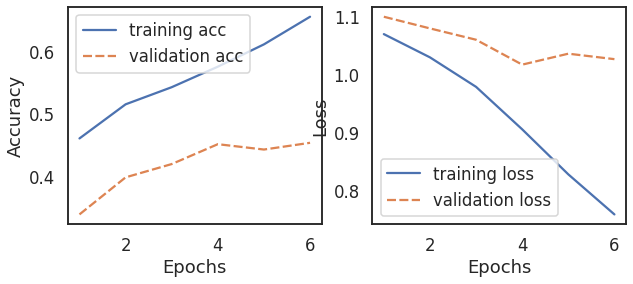

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0692, train_acc:0.4685, val Loss: : 1.0899, val_acc: 0.389
[epoch 2] train_loss: 1.0285, train_acc:0.5308, val Loss: : 1.0771, val_acc: 0.411
[epoch 3] train_loss: 0.9766, train_acc:0.5614, val Loss: : 1.0614, val_acc: 0.425
[epoch 4] train_loss: 0.9037, train_acc:0.5960, val Loss: : 1.0119, val_acc: 0.468
[epoch 5] train_loss: 0.8109, train_acc:0.6275, val Loss: : 0.9948, val_acc: 0.475
[epoch 6] train_loss: 0.7456, train_acc:0.6605, val Loss: : 1.0139, val_acc: 0.477
[epoch 7] train_loss: 0.6673, train_acc:0.7039, val Loss: : 0.9322, val_acc: 0.517
[epoch 8] train_loss: 0.6156, train_acc:0.7278, val Loss: : 0.9450, val_acc: 0.517
[epoch 9] train_loss: 0.5788, train_acc:0.7378, val Loss: : 0.9773, v

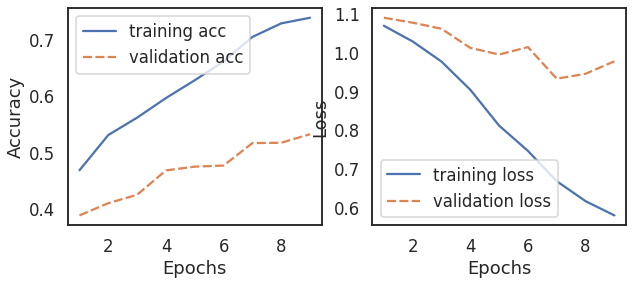

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0734, train_acc:0.4631, val Loss: : 1.0919, val_acc: 0.386
[epoch 2] train_loss: 1.0364, train_acc:0.5153, val Loss: : 1.0820, val_acc: 0.404
[epoch 3] train_loss: 0.9892, train_acc:0.5432, val Loss: : 1.0676, val_acc: 0.419
[epoch 4] train_loss: 0.9223, train_acc:0.5791, val Loss: : 1.0316, val_acc: 0.448
[epoch 5] train_loss: 0.8396, train_acc:0.6082, val Loss: : 0.9947, val_acc: 0.469
[epoch 6] train_loss: 0.7634, train_acc:0.6516, val Loss: : 0.9643, val_acc: 0.495
[epoch 7] train_loss: 0.6966, train_acc:0.6882, val Loss: : 0.9279, val_acc: 0.513
[epoch 8] train_loss: 0.6340, train_acc:0.7182, val Loss: : 0.9059, val_acc: 0.536
[epoch 9] train_loss: 0.5769, train_acc:0.7441, val Loss: : 0.9356, v

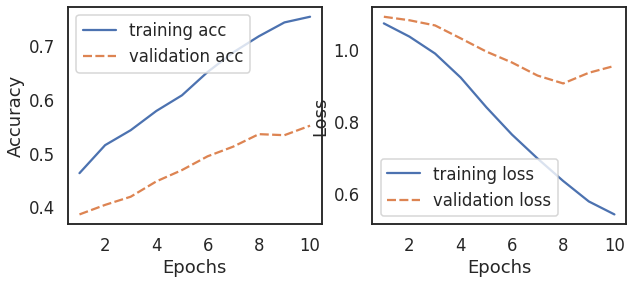

----------------------------------------------------------------------
acc_list [0.5914085914085914, 0.5341325341325341, 0.5285825285825286, 0.47974247974247974, 0.5554445554445554, 0.5514485514485514]
loss_list [0.8903472423553467, 0.9375408887863159, 0.9722042083740234, 0.9898231029510498, 0.9326633810997009, 0.9465120434761047]
precision_list [array([0.33333333, 0.61984237, 0.56587657]), array([0.22025913, 0.59425445, 0.5445061 ]), array([0.16823899, 0.58529689, 0.59089608]), array([0.15914221, 0.56115448, 0.55415282]), array([0.19338677, 0.57773302, 0.64941176]), array([0.18983957, 0.58370776, 0.63836705])]
recall_list [array([0.00585652, 0.6014395 , 0.68298969]), array([0.27379209, 0.48852901, 0.63221649]), array([0.31332357, 0.55870445, 0.53195876]), array([0.41288433, 0.53351327, 0.42989691]), array([0.28257687, 0.70962663, 0.42680412]), array([0.31185944, 0.67206478, 0.45541237])]
fscore_list [array([0.01151079, 0.61050228, 0.61894196]), array([0.24412533, 0.5362301 , 0.5850924

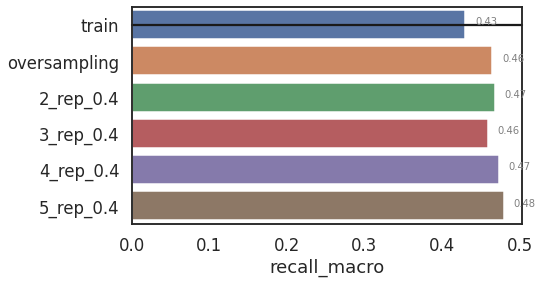

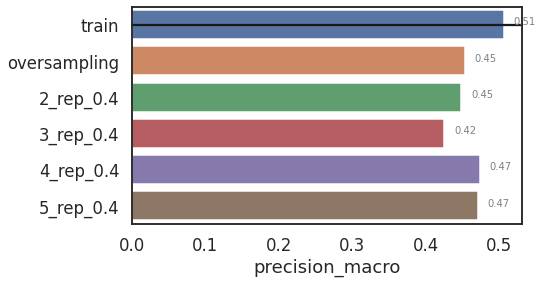

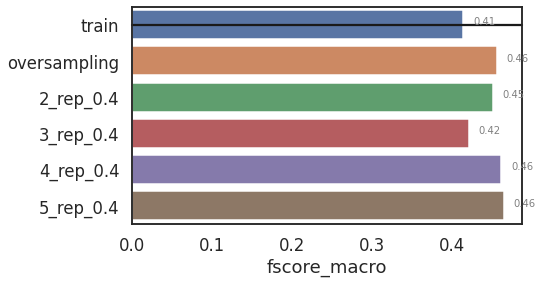

ratio 0.6
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0455, train_acc:0.4975, val Loss: : 1.0488, val_acc: 0.482
[epoch 2] train_loss: 0.9594, train_acc:0.5535, val Loss: : 0.9666, val_acc: 0.515
[epoch 3] train_loss: 0.8917, train_acc:0.5696, val Loss: : 0.9006, val_acc: 0.523
[epoch 4] train_loss: 0.8770, train_acc:0.5791, val Loss: : 0.8960, val_acc: 0.538
[epoch 5] train_loss: 0.8512, train_acc:0.5977, val Loss: : 0.8855, val_acc: 0.542
[epoch 6] train_loss: 0.8318, train_acc:0.6129, val Loss: : 0.8821, val_acc: 0.547
[epoch 7] train_loss: 0.8042, train_acc:0.6348, val Loss: : 0.8737, val_acc: 0.568
[epoch 8] train_loss: 0.7674, train_acc:0.6591, val Loss: : 0.8639, val_acc: 0.587
[epoch 9] train_loss: 0.7391, train_acc:0.6748, val Loss: : 0.8657, val_acc: 0.605


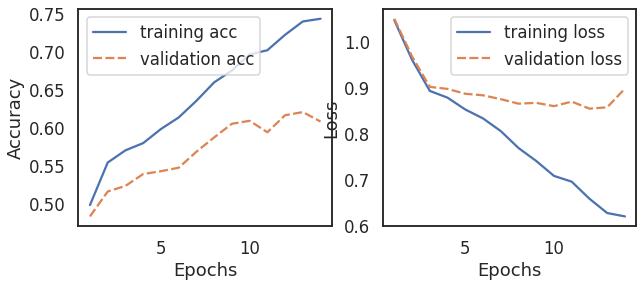

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 7128
[epoch 1] train_loss: 1.0658, train_acc:0.4573, val Loss: : 1.0976, val_acc: 0.344
[epoch 2] train_loss: 1.0154, train_acc:0.5106, val Loss: : 1.0868, val_acc: 0.389
[epoch 3] train_loss: 0.9328, train_acc:0.5606, val Loss: : 1.0611, val_acc: 0.436
[epoch 4] train_loss: 0.8429, train_acc:0.6104, val Loss: : 0.9678, val_acc: 0.494
[epoch 5] train_loss: 0.7589, train_acc:0.6632, val Loss: : 0.9810, val_acc: 0.492
[epoch 6] train_loss: 0.7043, train_acc:0.6789, val Loss: : 0.8834, val_acc: 0.556
[epoch 7] train_loss: 0.6223, train_acc:0.7254, val Loss: : 0.9000, val_acc: 0.558
[epoch 8] train_loss: 0.5603, train_acc:0.7562, val Loss: : 0.8870, val_acc: 0.578
[epoch 9] train_loss: 0.5058, train_acc:0.7929, val Lo

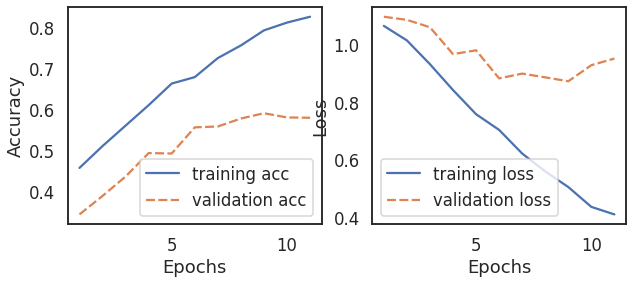

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0628, train_acc:0.4707, val Loss: : 1.0914, val_acc: 0.371
[epoch 2] train_loss: 1.0092, train_acc:0.5227, val Loss: : 1.0657, val_acc: 0.406
[epoch 3] train_loss: 0.9070, train_acc:0.5796, val Loss: : 0.9955, val_acc: 0.464
[epoch 4] train_loss: 0.8137, train_acc:0.6180, val Loss: : 1.0627, val_acc: 0.439
[epoch 5] train_loss: 0.7410, train_acc:0.6697, val Loss: : 0.9808, val_acc: 0.490
[epoch 6] train_loss: 0.6616, train_acc:0.6968, val Loss: : 1.0125, val_acc: 0.506
[epoch 7] train_loss: 0.5986, train_acc:0.7278, val Loss: : 0.9762, val_acc: 0.531
[epoch 8] train_loss: 0.5473, train_acc:0.7645, val Loss: : 0.8997, val_acc: 0.560
[epoch 9] train_loss: 0.4914, train_acc:0.7848, val Loss: : 0.9177, v

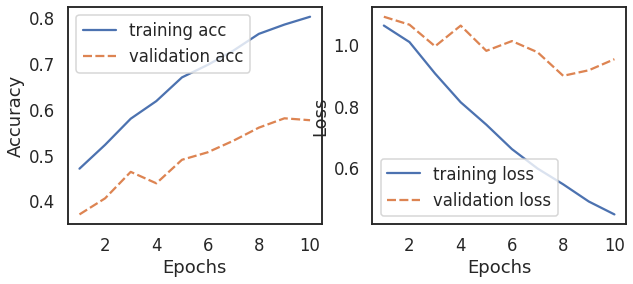

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0588, train_acc:0.4840, val Loss: : 1.0890, val_acc: 0.379
[epoch 2] train_loss: 0.9956, train_acc:0.5309, val Loss: : 1.0750, val_acc: 0.394
[epoch 3] train_loss: 0.8773, train_acc:0.5888, val Loss: : 0.9844, val_acc: 0.471
[epoch 4] train_loss: 0.7617, train_acc:0.6487, val Loss: : 0.9618, val_acc: 0.498
[epoch 5] train_loss: 0.7159, train_acc:0.6795, val Loss: : 0.8963, val_acc: 0.535
[epoch 6] train_loss: 0.6394, train_acc:0.7093, val Loss: : 0.9030, val_acc: 0.558
[epoch 7] train_loss: 0.5925, train_acc:0.7335, val Loss: : 0.8945, val_acc: 0.576
[epoch 8] train_loss: 0.5138, train_acc:0.7706, val Loss: : 0.9262, val_acc: 0.574
[epoch 9] train_loss: 0.4900, train_acc:0.7769, val Loss: : 0.9701, v

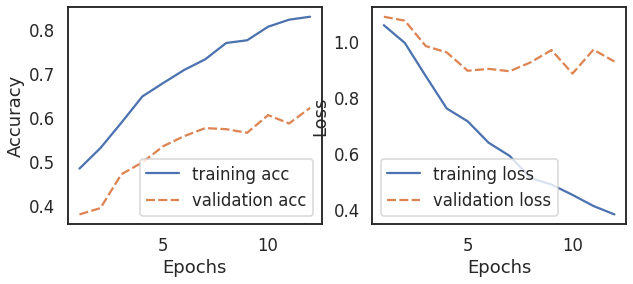

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0597, train_acc:0.4754, val Loss: : 1.0828, val_acc: 0.398
[epoch 2] train_loss: 1.0011, train_acc:0.5254, val Loss: : 1.0775, val_acc: 0.399
[epoch 3] train_loss: 0.9024, train_acc:0.5788, val Loss: : 1.0232, val_acc: 0.456
[epoch 4] train_loss: 0.7941, train_acc:0.6365, val Loss: : 0.9638, val_acc: 0.500
[epoch 5] train_loss: 0.7118, train_acc:0.6819, val Loss: : 0.9620, val_acc: 0.502
[epoch 6] train_loss: 0.6226, train_acc:0.7210, val Loss: : 0.9335, val_acc: 0.541
[epoch 7] train_loss: 0.5622, train_acc:0.7565, val Loss: : 0.8824, val_acc: 0.571
[epoch 8] train_loss: 0.5481, train_acc:0.7539, val Loss: : 0.9814, val_acc: 0.548
[epoch 9] train_loss: 0.4887, train_acc:0.7843, val Loss: : 0.9256, v

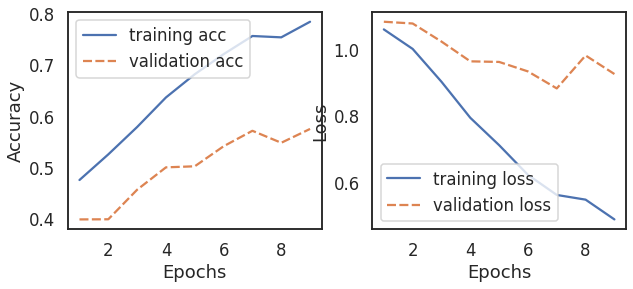

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0626, train_acc:0.4782, val Loss: : 1.0927, val_acc: 0.357
[epoch 2] train_loss: 1.0026, train_acc:0.5285, val Loss: : 1.0664, val_acc: 0.414
[epoch 3] train_loss: 0.8997, train_acc:0.5732, val Loss: : 1.0184, val_acc: 0.453
[epoch 4] train_loss: 0.7946, train_acc:0.6319, val Loss: : 1.0359, val_acc: 0.453
[epoch 5] train_loss: 0.7047, train_acc:0.6803, val Loss: : 0.9487, val_acc: 0.495
[epoch 6] train_loss: 0.6265, train_acc:0.7119, val Loss: : 0.9343, val_acc: 0.531
[epoch 7] train_loss: 0.5782, train_acc:0.7359, val Loss: : 0.9593, val_acc: 0.525
[epoch 8] train_loss: 0.5488, train_acc:0.7475, val Loss: : 0.9857, val_acc: 0.539
[epoch 9] train_loss: 0.4962, train_acc:0.7781, val Loss: : 0.9427, v

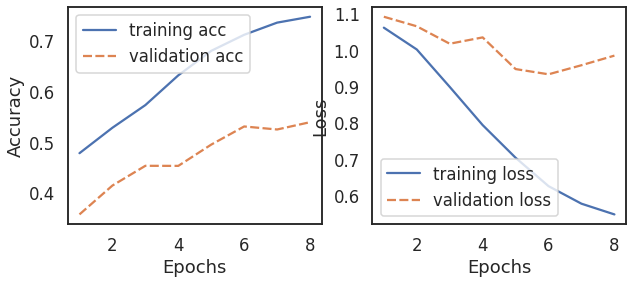

----------------------------------------------------------------------
acc_list [0.6157176157176157, 0.5927405927405928, 0.5770895770895771, 0.5796425796425796, 0.5722055722055722, 0.5567765567765568]
loss_list [0.8678983449935913, 0.9447301030158997, 0.9095486998558044, 0.9534236192703247, 0.9300094246864319, 0.9215447902679443]
precision_list [array([0.27710843, 0.58649326, 0.70007862]), array([0.22139535, 0.6454889 , 0.64027027]), array([0.22819767, 0.61071996, 0.60056151]), array([0.20080645, 0.63343595, 0.64805415]), array([0.2122571 , 0.570021  , 0.69055375]), array([0.25037707, 0.63172124, 0.54753837])]
recall_list [array([0.03367496, 0.84188034, 0.45902062]), array([0.34846266, 0.61470985, 0.61056701]), array([0.22986823, 0.60481332, 0.6064433 ]), array([0.36456808, 0.60166442, 0.59226804]), array([0.2079063 , 0.79374719, 0.38247423]), array([0.24304539, 0.47300945, 0.70798969])]
fscore_list [array([0.06005222, 0.69135574, 0.55448319]), array([0.27076223, 0.6297235 , 0.62506596

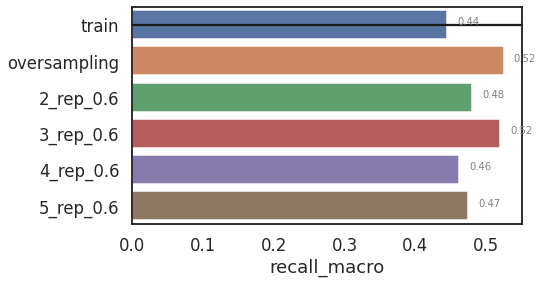

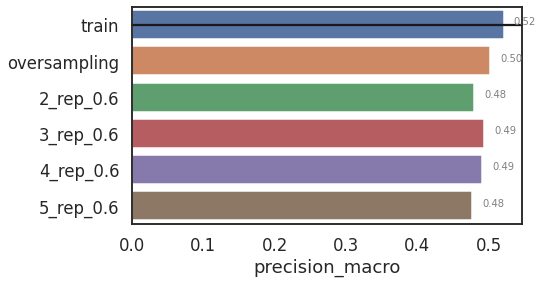

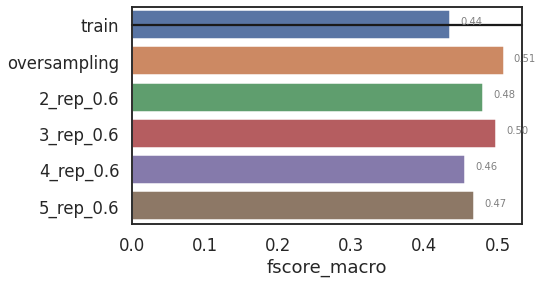

ratio 0.8
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9871, train_acc:0.5094, val Loss: : 0.9894, val_acc: 0.487
[epoch 2] train_loss: 0.9015, train_acc:0.5341, val Loss: : 0.9019, val_acc: 0.526
[epoch 3] train_loss: 0.8819, train_acc:0.5649, val Loss: : 0.8945, val_acc: 0.531
[epoch 4] train_loss: 0.8658, train_acc:0.5760, val Loss: : 0.8921, val_acc: 0.533
[epoch 5] train_loss: 0.8467, train_acc:0.5898, val Loss: : 0.8894, val_acc: 0.538
[epoch 6] train_loss: 0.8223, train_acc:0.6068, val Loss: : 0.8850, val_acc: 0.541
[epoch 7] train_loss: 0.7926, train_acc:0.6322, val Loss: : 0.8791, val_acc: 0.555
[epoch 8] train_loss: 0.7563, train_acc:0.6601, val Loss: : 0.8718, val_acc: 0.575
[epoch 9] train_loss: 0.7179, train_acc:0.6823, val Loss: : 0.8653, val_acc: 0.604


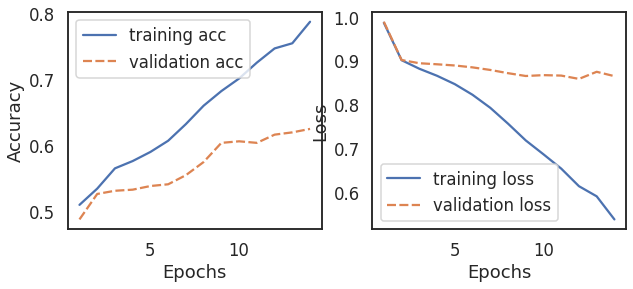

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 9488
[epoch 1] train_loss: 1.0569, train_acc:0.4639, val Loss: : 1.0862, val_acc: 0.391
[epoch 2] train_loss: 0.9930, train_acc:0.5287, val Loss: : 1.0714, val_acc: 0.414
[epoch 3] train_loss: 0.8799, train_acc:0.5887, val Loss: : 0.9854, val_acc: 0.490
[epoch 4] train_loss: 0.7724, train_acc:0.6625, val Loss: : 0.9747, val_acc: 0.508
[epoch 5] train_loss: 0.6816, train_acc:0.6974, val Loss: : 0.9405, val_acc: 0.533
[epoch 6] train_loss: 0.6059, train_acc:0.7342, val Loss: : 0.9518, val_acc: 0.531
[epoch 7] train_loss: 0.5143, train_acc:0.7897, val Loss: : 0.9204, val_acc: 0.577
[epoch 8] train_loss: 0.4443, train_acc:0.8179, val Loss: : 0.8911, val_acc: 0.607
[epoch 9] train_loss: 0.3986, train_acc:0.8367, val Lo

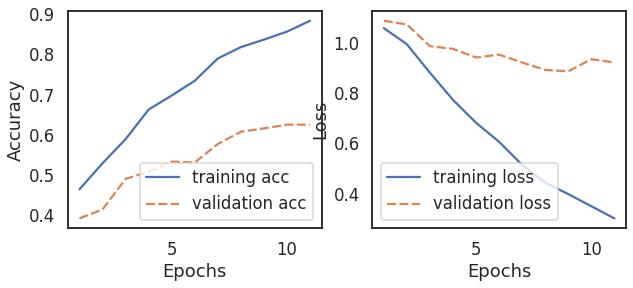

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0504, train_acc:0.4813, val Loss: : 1.0813, val_acc: 0.384
[epoch 2] train_loss: 0.9674, train_acc:0.5332, val Loss: : 1.0643, val_acc: 0.414
[epoch 3] train_loss: 0.8290, train_acc:0.6103, val Loss: : 1.0078, val_acc: 0.463
[epoch 4] train_loss: 0.7551, train_acc:0.6570, val Loss: : 1.0142, val_acc: 0.463
[epoch 5] train_loss: 0.6518, train_acc:0.7011, val Loss: : 0.9105, val_acc: 0.529
[epoch 6] train_loss: 0.6061, train_acc:0.7267, val Loss: : 0.8787, val_acc: 0.570
[epoch 7] train_loss: 0.5527, train_acc:0.7573, val Loss: : 0.8761, val_acc: 0.593
[epoch 8] train_loss: 0.4697, train_acc:0.7906, val Loss: : 0.9127, val_acc: 0.577
[epoch 9] train_loss: 0.4435, train_acc:0.8091, val Loss: : 0.9540, v

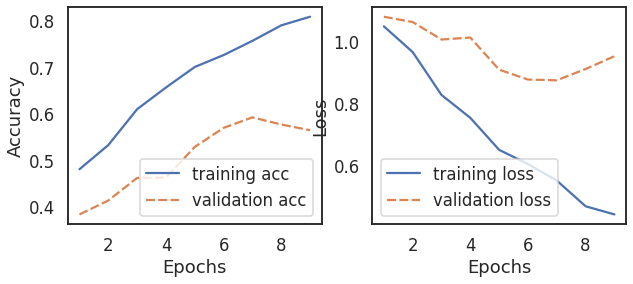

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0510, train_acc:0.4831, val Loss: : 1.0767, val_acc: 0.408
[epoch 2] train_loss: 0.9708, train_acc:0.5359, val Loss: : 1.0528, val_acc: 0.426
[epoch 3] train_loss: 0.8428, train_acc:0.6051, val Loss: : 0.9595, val_acc: 0.497
[epoch 4] train_loss: 0.7293, train_acc:0.6693, val Loss: : 0.9198, val_acc: 0.511
[epoch 5] train_loss: 0.6580, train_acc:0.7009, val Loss: : 0.8876, val_acc: 0.556
[epoch 6] train_loss: 0.5708, train_acc:0.7478, val Loss: : 0.8767, val_acc: 0.583
[epoch 7] train_loss: 0.5206, train_acc:0.7763, val Loss: : 0.8688, val_acc: 0.592
[epoch 8] train_loss: 0.4715, train_acc:0.7952, val Loss: : 0.8989, val_acc: 0.589
[epoch 9] train_loss: 0.4432, train_acc:0.8058, val Loss: : 0.9647, v

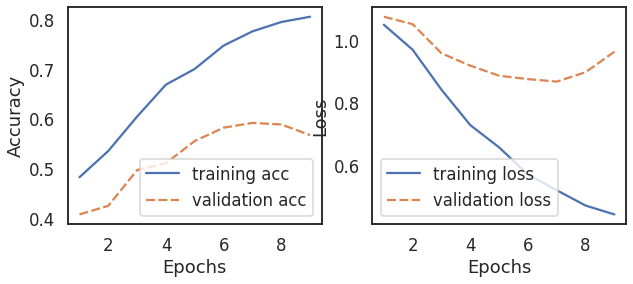

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0488, train_acc:0.4900, val Loss: : 1.0799, val_acc: 0.405
[epoch 2] train_loss: 0.9552, train_acc:0.5507, val Loss: : 1.0555, val_acc: 0.429
[epoch 3] train_loss: 0.8086, train_acc:0.6228, val Loss: : 0.9745, val_acc: 0.493
[epoch 4] train_loss: 0.6967, train_acc:0.6848, val Loss: : 0.8930, val_acc: 0.541
[epoch 5] train_loss: 0.6241, train_acc:0.7125, val Loss: : 0.9053, val_acc: 0.561
[epoch 6] train_loss: 0.5714, train_acc:0.7474, val Loss: : 0.8535, val_acc: 0.600
[epoch 7] train_loss: 0.4959, train_acc:0.7829, val Loss: : 0.8603, val_acc: 0.615
[epoch 8] train_loss: 0.4682, train_acc:0.7872, val Loss: : 0.9220, val_acc: 0.565
[epoch 9] train_loss: 0.4125, train_acc:0.8245, val Loss: : 0.8774, v

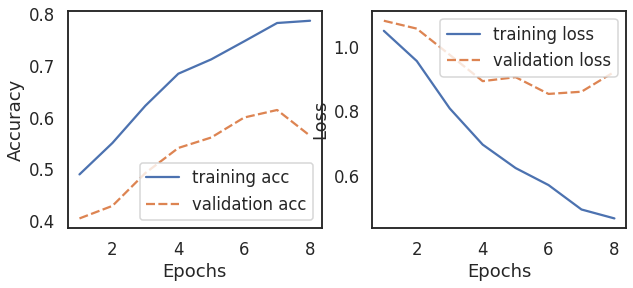

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0482, train_acc:0.4857, val Loss: : 1.0818, val_acc: 0.384
[epoch 2] train_loss: 0.9457, train_acc:0.5543, val Loss: : 1.0361, val_acc: 0.434
[epoch 3] train_loss: 0.7879, train_acc:0.6312, val Loss: : 0.9847, val_acc: 0.479
[epoch 4] train_loss: 0.7115, train_acc:0.6696, val Loss: : 0.9756, val_acc: 0.500
[epoch 5] train_loss: 0.6541, train_acc:0.6925, val Loss: : 0.9976, val_acc: 0.505
[epoch 6] train_loss: 0.5898, train_acc:0.7370, val Loss: : 0.9909, val_acc: 0.535
[epoch 7] train_loss: 0.5072, train_acc:0.7747, val Loss: : 0.8948, val_acc: 0.583
[epoch 8] train_loss: 0.4726, train_acc:0.7902, val Loss: : 0.8809, val_acc: 0.607
[epoch 9] train_loss: 0.4304, train_acc:0.8157, val Loss: : 0.9260, v

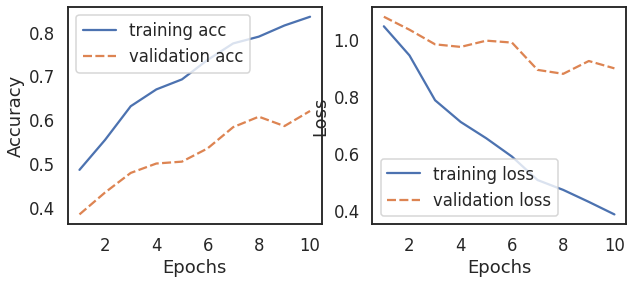

----------------------------------------------------------------------
acc_list [0.6208236208236209, 0.6047286047286047, 0.6079476079476079, 0.5966255966255967, 0.6196026196026196, 0.6085026085026085]
loss_list [0.8795102834701538, 0.9781273603439331, 0.8799241185188293, 0.9045237302780151, 0.862437903881073, 0.9181059002876282]
precision_list [array([0.22051282, 0.63781073, 0.62086093]), array([0.23614663, 0.65087515, 0.67079696]), array([0.30083565, 0.63038198, 0.61004611]), array([0.23449612, 0.60739437, 0.63561077]), array([0.26953125, 0.62570394, 0.66184397]), array([0.24543947, 0.61479742, 0.66515014])]
recall_list [array([0.06295754, 0.65789474, 0.67654639]), array([0.40556369, 0.62730544, 0.61391753]), array([0.15812592, 0.64215025, 0.64793814]), array([0.17715959, 0.69838057, 0.55386598]), array([0.20204978, 0.69973009, 0.60128866]), array([0.21669107, 0.70647773, 0.56520619])]
fscore_list [array([0.09794989, 0.64769708, 0.64750863]), array([0.29849138, 0.63887298, 0.6410981 ]

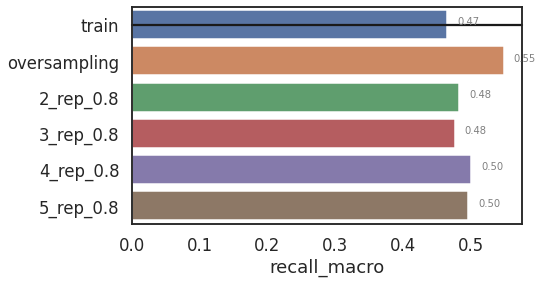

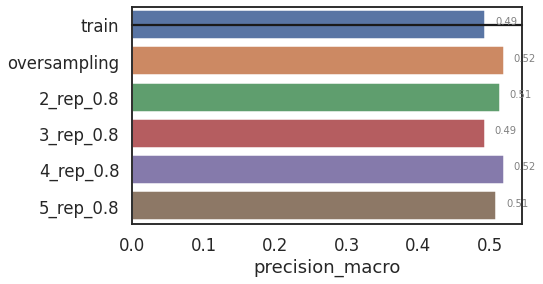

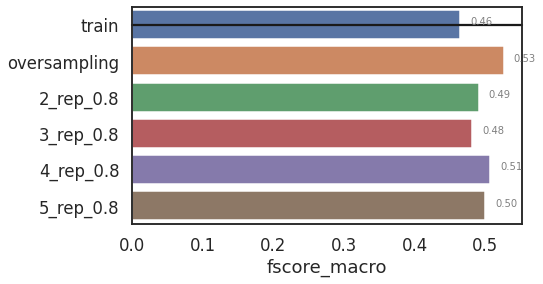

ratio 1
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9832, train_acc:0.5234, val Loss: : 0.9855, val_acc: 0.514
[epoch 2] train_loss: 0.9082, train_acc:0.5529, val Loss: : 0.9097, val_acc: 0.540
[epoch 3] train_loss: 0.8643, train_acc:0.5748, val Loss: : 0.8821, val_acc: 0.556
[epoch 4] train_loss: 0.8358, train_acc:0.6065, val Loss: : 0.8731, val_acc: 0.561
[epoch 5] train_loss: 0.7931, train_acc:0.6389, val Loss: : 0.8575, val_acc: 0.587
[epoch 6] train_loss: 0.7505, train_acc:0.6646, val Loss: : 0.8429, val_acc: 0.623
[epoch 7] train_loss: 0.7087, train_acc:0.6960, val Loss: : 0.8319, val_acc: 0.621
[epoch 8] train_loss: 0.6773, train_acc:0.7124, val Loss: : 0.8429, val_acc: 0.632
[epoch 9] train_loss: 0.6303, train_acc:0.7425, val Loss: : 0.8219, val_acc: 0.636
[e

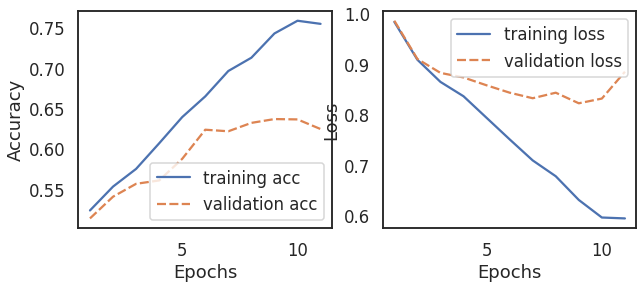

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 11850
[epoch 1] train_loss: 1.0484, train_acc:0.4746, val Loss: : 1.0835, val_acc: 0.391
[epoch 2] train_loss: 0.9424, train_acc:0.5519, val Loss: : 1.0558, val_acc: 0.446
[epoch 3] train_loss: 0.8165, train_acc:0.6311, val Loss: : 0.9947, val_acc: 0.478
[epoch 4] train_loss: 0.7020, train_acc:0.6938, val Loss: : 0.9179, val_acc: 0.550
[epoch 5] train_loss: 0.6100, train_acc:0.7427, val Loss: : 0.9118, val_acc: 0.557
[epoch 6] train_loss: 0.5305, train_acc:0.7745, val Loss: : 0.9347, val_acc: 0.570
[epoch 7] train_loss: 0.4565, train_acc:0.8078, val Loss: : 0.9016, val_acc: 0.608
[epoch 8] train_loss: 0.4246, train_acc:0.8243, val Loss: : 0.9525, val_acc: 0.579
[epoch 9] train_loss: 0.3478, train_acc:0.8569, val L

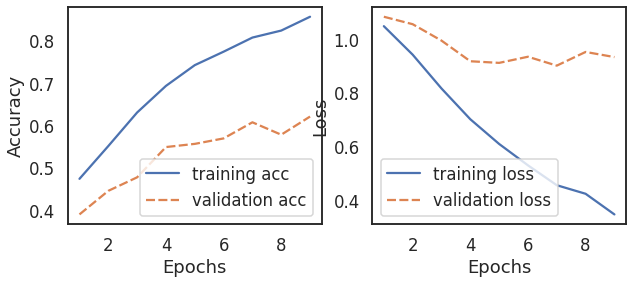

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0419, train_acc:0.4928, val Loss: : 1.0769, val_acc: 0.404
[epoch 2] train_loss: 0.9090, train_acc:0.5691, val Loss: : 0.9958, val_acc: 0.478
[epoch 3] train_loss: 0.7654, train_acc:0.6560, val Loss: : 0.8878, val_acc: 0.553
[epoch 4] train_loss: 0.6628, train_acc:0.7031, val Loss: : 0.8943, val_acc: 0.567
[epoch 5] train_loss: 0.5638, train_acc:0.7552, val Loss: : 0.9137, val_acc: 0.582
[epoch 6] train_loss: 0.5074, train_acc:0.7729, val Loss: : 0.8900, val_acc: 0.603


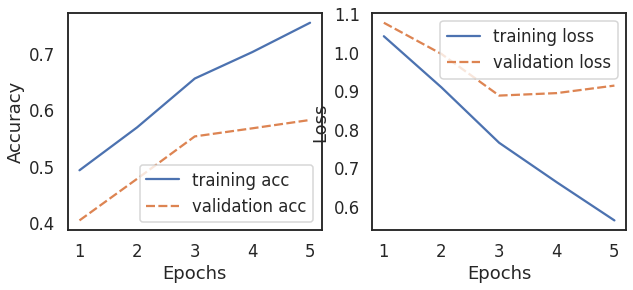

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0360, train_acc:0.4923, val Loss: : 1.0755, val_acc: 0.397
[epoch 2] train_loss: 0.8868, train_acc:0.5826, val Loss: : 1.0045, val_acc: 0.463
[epoch 3] train_loss: 0.7609, train_acc:0.6509, val Loss: : 0.9843, val_acc: 0.477
[epoch 4] train_loss: 0.6427, train_acc:0.7051, val Loss: : 0.9206, val_acc: 0.543
[epoch 5] train_loss: 0.5898, train_acc:0.7339, val Loss: : 0.9573, val_acc: 0.557
[epoch 6] train_loss: 0.5154, train_acc:0.7707, val Loss: : 0.8981, val_acc: 0.580
[epoch 7] train_loss: 0.4550, train_acc:0.7999, val Loss: : 0.8830, val_acc: 0.600
[epoch 8] train_loss: 0.4233, train_acc:0.8182, val Loss: : 0.9213, val_acc: 0.590
[epoch 9] train_loss: 0.3820, train_acc:0.8372, val Loss: : 0.9325, val

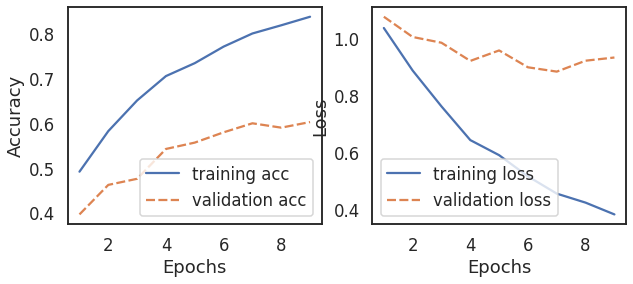

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0413, train_acc:0.4871, val Loss: : 1.0792, val_acc: 0.390
[epoch 2] train_loss: 0.9024, train_acc:0.5735, val Loss: : 0.9947, val_acc: 0.472
[epoch 3] train_loss: 0.7468, train_acc:0.6561, val Loss: : 0.9551, val_acc: 0.497
[epoch 4] train_loss: 0.6329, train_acc:0.7115, val Loss: : 0.9056, val_acc: 0.555
[epoch 5] train_loss: 0.5588, train_acc:0.7499, val Loss: : 0.8980, val_acc: 0.578
[epoch 6] train_loss: 0.5100, train_acc:0.7701, val Loss: : 0.8760, val_acc: 0.598
[epoch 7] train_loss: 0.4412, train_acc:0.8086, val Loss: : 0.8781, val_acc: 0.611
[epoch 8] train_loss: 0.4047, train_acc:0.8275, val Loss: : 0.8678, val_acc: 0.619
[epoch 9] train_loss: 0.3763, train_acc:0.8412, val Loss: : 0.8876, val

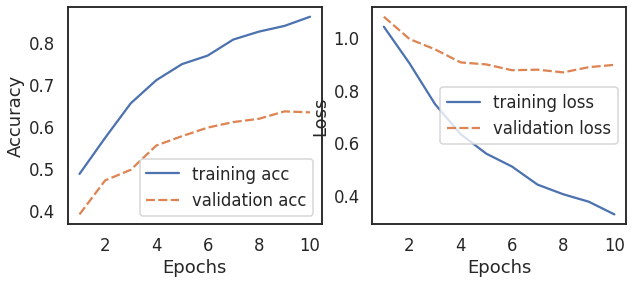

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0387, train_acc:0.4911, val Loss: : 1.0800, val_acc: 0.394
[epoch 2] train_loss: 0.8971, train_acc:0.5716, val Loss: : 1.0259, val_acc: 0.468
[epoch 3] train_loss: 0.7673, train_acc:0.6391, val Loss: : 0.9940, val_acc: 0.466
[epoch 4] train_loss: 0.6438, train_acc:0.7072, val Loss: : 0.9027, val_acc: 0.550
[epoch 5] train_loss: 0.5750, train_acc:0.7370, val Loss: : 0.9330, val_acc: 0.560
[epoch 6] train_loss: 0.5197, train_acc:0.7715, val Loss: : 0.8590, val_acc: 0.600
[epoch 7] train_loss: 0.4514, train_acc:0.8040, val Loss: : 0.8711, val_acc: 0.613
[epoch 8] train_loss: 0.4024, train_acc:0.8277, val Loss: : 0.8770, val_acc: 0.614
[epoch 9] train_loss: 0.3704, train_acc:0.8428, val Loss: : 0.9292, val

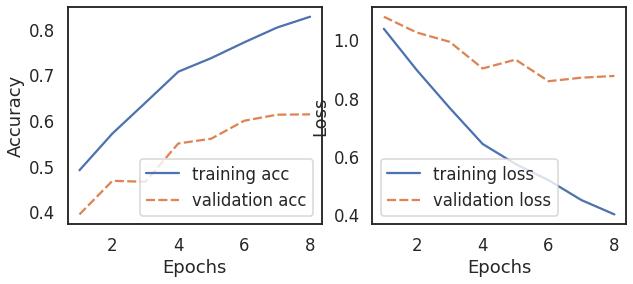

----------------------------------------------------------------------
acc_list [0.6216006216006216, 0.5641025641025641, 0.5865245865245865, 0.5908535908535909, 0.6032856032856033, 0.6023976023976024]
loss_list [0.8557445406913757, 1.0387972593307495, 0.8766647577285767, 0.9359666109085083, 0.9812092185020447, 0.9239172339439392]
precision_list [array([0.23837209, 0.63536977, 0.62200384]), array([0.20098644, 0.68026534, 0.61870997]), array([0.21813285, 0.59466148, 0.74932976]), array([0.18565401, 0.61236377, 0.73701039]), array([0.25952381, 0.64338148, 0.63355297]), array([0.23896104, 0.62767818, 0.64720327])]
recall_list [array([0.06002928, 0.66666667, 0.66881443]), array([0.477306  , 0.46131354, 0.69716495]), array([0.35578331, 0.75663518, 0.43221649]), array([0.32210835, 0.73301844, 0.47525773]), array([0.31918009, 0.61111111, 0.6443299 ]), array([0.26939971, 0.64574899, 0.61134021])]
fscore_list [array([0.09590643, 0.65064208, 0.64456036]), array([0.28286334, 0.54979225, 0.65559864

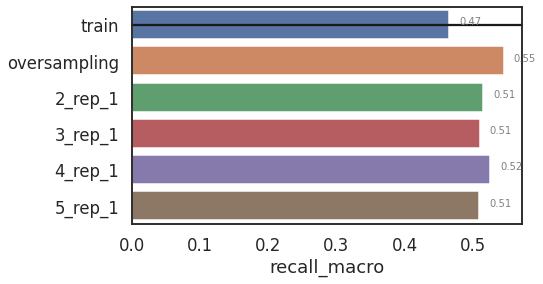

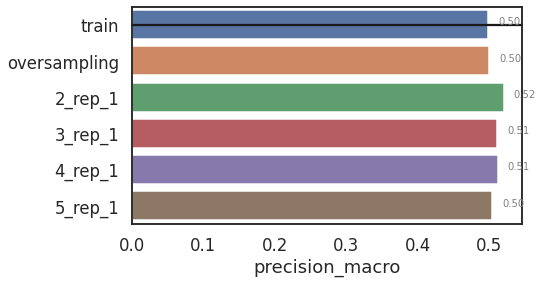

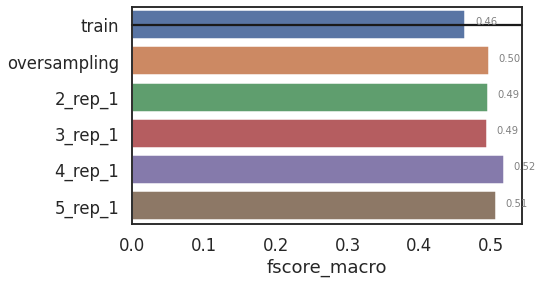

CPU times: user 22min 13s, sys: 26.7 s, total: 22min 40s
Wall time: 22min 40s


In [ ]:
%%time
      
task_name = 'sub_twitter'
tech_name = 'Fasttext_augmentation'
ratios = [0.2, 0.4, 0.6, 0.8, 1]
for ratio in ratios:
  print('ratio', ratio)
  if ratio == 0.2:
    test_list = ['train',
                 'oversampling',
                 '2_rep_0.2',
      '3_rep_0.2',
      '4_rep_0.2',
      '5_rep_0.2']
    print('<'*50)
    # print('ratio', ratio)
  if ratio == 0.4:
    test_list = ['train',
                 'oversampling',
                 '2_rep_0.4',
      '3_rep_0.4',
      '4_rep_0.4',
      '5_rep_0.4']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.6:
    test_list = ['train',
                 'oversampling',
                 '2_rep_0.6',
      '3_rep_0.6',
      '4_rep_0.6',
      '5_rep_0.6']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.8:
    test_list = ['train',
                 'oversampling',
                 '2_rep_0.8',
      '3_rep_0.8',
      '4_rep_0.8',
      '5_rep_0.8']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 1:
    test_list = ['train',
                 'oversampling',
                 '2_rep_1',
      '3_rep_1',
      '4_rep_1',
      '5_rep_1']

    print('<'*50)

  Execute(test_list, task_name, tech_name, ratio)

## Pretrain BERT


### *Pretrain BERT test dataset* (various ratio) (test set)


#### new one

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0907, train_acc:0.3861, val Loss: : 1.0928, val_acc: 0.381
[epoch 2] train_loss: 1.0615, train_acc:0.4763, val Loss: : 1.0672, val_acc: 0.455
[epoch 3] train_loss: 1.0317, train_acc:0.5242, val Loss: : 1.0412, val_acc: 0.486
[epoch 4] train_loss: 1.0004, train_acc:0.5483, val Loss: : 1.0140, val_acc: 0.501
[epoch 5] train_loss: 0.9661, train_acc:0.5613, val Loss: : 0.9850, val_acc: 0.509
[epoch 6] train_loss: 0.9325, train_acc:0.5660, val Loss: : 0.9541, val_acc: 0.513
[epoch 7] train_loss: 0.8983, train_acc:0.5670, val Loss: : 0.9236, val_acc: 0.518
[epoch 8] train_loss: 0.8777, train_acc:0.5653, val Loss: : 0.9034, val_acc: 0.521
[epoch 9] train_loss: 0.8813, train_acc:0.5809, val Loss: : 0.9111, val_acc: 0.522
[epoch 10]

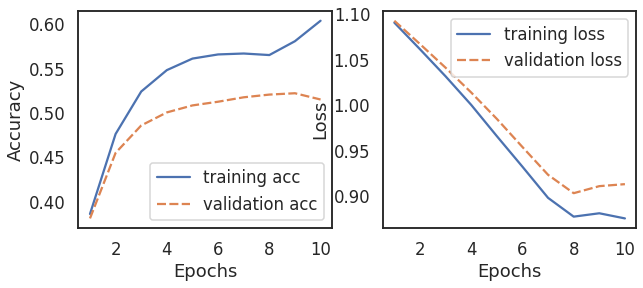

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 2351
[epoch 1] train_loss: 1.0853, train_acc:0.4193, val Loss: : 1.0942, val_acc: 0.373
[epoch 2] train_loss: 1.0646, train_acc:0.5049, val Loss: : 1.0932, val_acc: 0.378
[epoch 3] train_loss: 1.0426, train_acc:0.5320, val Loss: : 1.0897, val_acc: 0.390
[epoch 4] train_loss: 1.0185, train_acc:0.5605, val Loss: : 1.0864, val_acc: 0.393
[epoch 5] train_loss: 0.9913, train_acc:0.5788, val Loss: : 1.0812, val_acc: 0.400
[epoch 6] train_loss: 0.9619, train_acc:0.5914, val Loss: : 1.0751, val_acc: 0.404
[epoch 7] train_loss: 0.9279, train_acc:0.6124, val Loss: : 1.0627, val_acc: 0.419
[epoch 8] train_loss: 0.8911, train_acc:0.6331, val Loss: : 1.0476, val_acc: 0.432
[epoch 9] train_loss: 0.8499, train_acc:0.6482, val Lo

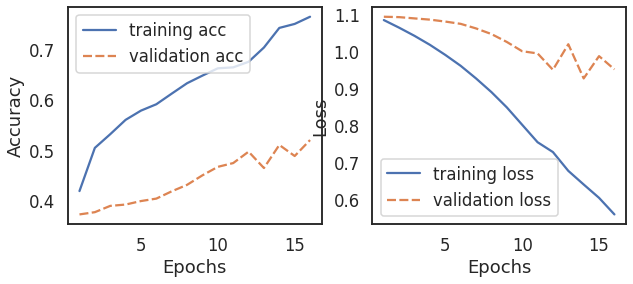

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(unfine)_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0779, train_acc:0.4292, val Loss: : 1.1144, val_acc: 0.268
[epoch 2] train_loss: 1.0540, train_acc:0.4810, val Loss: : 1.1049, val_acc: 0.328
[epoch 3] train_loss: 1.0301, train_acc:0.5282, val Loss: : 1.0952, val_acc: 0.369
[epoch 4] train_loss: 1.0048, train_acc:0.5499, val Loss: : 1.0851, val_acc: 0.393
[epoch 5] train_loss: 0.9777, train_acc:0.5704, val Loss: : 1.0732, val_acc: 0.416
[epoch 6] train_loss: 0.9477, train_acc:0.5940, val Loss: : 1.0605, val_acc: 0.433
[epoch 7] train_loss: 0.9140, train_acc:0.6121, val Loss: : 1.0440, val_acc: 0.443
[epoch 8] train_loss: 0.8757, train_acc:0.6321, val Loss: : 1.0222, val_acc: 0.457
[epoch 9] train_loss: 0.8312, train_acc:0.6554, val Loss: : 

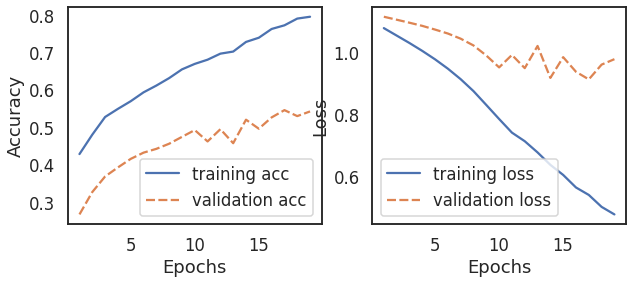

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(unfine)_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0818, train_acc:0.4134, val Loss: : 1.0962, val_acc: 0.350
[epoch 2] train_loss: 1.0543, train_acc:0.5034, val Loss: : 1.0952, val_acc: 0.353
[epoch 3] train_loss: 1.0270, train_acc:0.5393, val Loss: : 1.0941, val_acc: 0.362
[epoch 4] train_loss: 0.9989, train_acc:0.5594, val Loss: : 1.0901, val_acc: 0.373
[epoch 5] train_loss: 0.9683, train_acc:0.5823, val Loss: : 1.0838, val_acc: 0.386
[epoch 6] train_loss: 0.9345, train_acc:0.6015, val Loss: : 1.0718, val_acc: 0.400
[epoch 7] train_loss: 0.8967, train_acc:0.6183, val Loss: : 1.0545, val_acc: 0.416
[epoch 8] train_loss: 0.8551, train_acc:0.6396, val Loss: : 1.0318, val_acc: 0.437
[epoch 9] train_loss: 0.8092, train_acc:0.6527, val Loss: : 

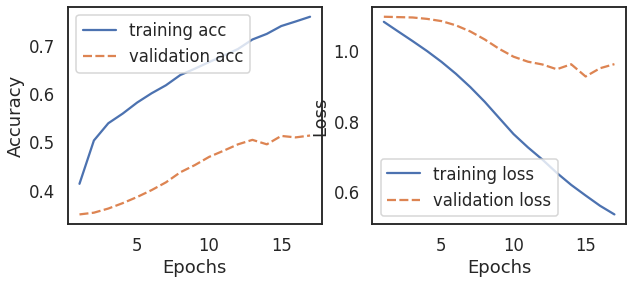

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(unfine)_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0666, train_acc:0.4411, val Loss: : 1.1026, val_acc: 0.319
[epoch 2] train_loss: 1.0320, train_acc:0.4869, val Loss: : 1.0972, val_acc: 0.345
[epoch 3] train_loss: 0.9986, train_acc:0.5186, val Loss: : 1.0897, val_acc: 0.373
[epoch 4] train_loss: 0.9665, train_acc:0.5490, val Loss: : 1.0770, val_acc: 0.399
[epoch 5] train_loss: 0.9342, train_acc:0.5706, val Loss: : 1.0615, val_acc: 0.423
[epoch 6] train_loss: 0.9016, train_acc:0.5928, val Loss: : 1.0427, val_acc: 0.445
[epoch 7] train_loss: 0.8678, train_acc:0.6111, val Loss: : 1.0186, val_acc: 0.467
[epoch 8] train_loss: 0.8335, train_acc:0.6269, val Loss: : 0.9905, val_acc: 0.485
[epoch 9] train_loss: 0.7985, train_acc:0.6392, val Loss: : 

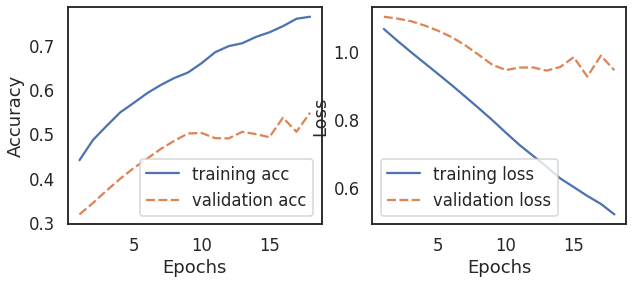

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(unfine)_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0510, train_acc:0.4495, val Loss: : 1.1164, val_acc: 0.272
[epoch 2] train_loss: 1.0073, train_acc:0.4964, val Loss: : 1.1070, val_acc: 0.319
[epoch 3] train_loss: 0.9701, train_acc:0.5371, val Loss: : 1.0945, val_acc: 0.363
[epoch 4] train_loss: 0.9369, train_acc:0.5632, val Loss: : 1.0779, val_acc: 0.401
[epoch 5] train_loss: 0.9053, train_acc:0.5872, val Loss: : 1.0576, val_acc: 0.427
[epoch 6] train_loss: 0.8737, train_acc:0.6052, val Loss: : 1.0329, val_acc: 0.449
[epoch 7] train_loss: 0.8428, train_acc:0.6212, val Loss: : 1.0041, val_acc: 0.472
[epoch 8] train_loss: 0.8137, train_acc:0.6350, val Loss: : 0.9723, val_acc: 0.488
[epoch 9] train_loss: 0.7878, train_acc:0.6466, val Loss: : 

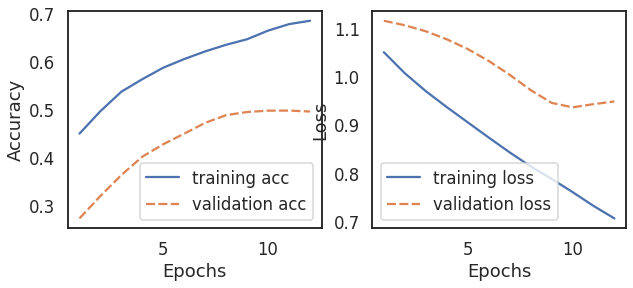

----------------------------------------------------------------------
acc_list [0.4973914973914974, 0.5252525252525253, 0.5604395604395604, 0.5101565101565102, 0.5401265401265402, 0.507048507048507]
loss_list [0.9094799757003784, 0.9330902099609375, 0.946810781955719, 0.9578074812889099, 0.9395248889923096, 0.939174234867096]
precision_list [array([0.        , 0.53737972, 0.46468927]), array([0.19346734, 0.57007073, 0.54188127]), array([0.2144    , 0.61287898, 0.5620305 ]), array([0.18406593, 0.56439024, 0.51375269]), array([0.16129032, 0.60664894, 0.53683301]), array([0.13892529, 0.54492543, 0.53347889])]
recall_list [array([0.        , 0.48987854, 0.5935567 ]), array([0.22547584, 0.58007197, 0.51520619]), array([0.19619327, 0.55015744, 0.63634021]), array([0.19619327, 0.52046784, 0.55360825]), array([0.14641288, 0.51304543, 0.64046392]), array([0.15519766, 0.67386415, 0.37783505])]
fscore_list [array([0.        , 0.51253089, 0.5212766 ]), array([0.20824882, 0.57502787, 0.52820716]),

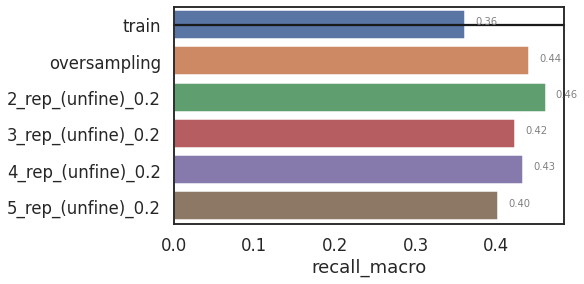

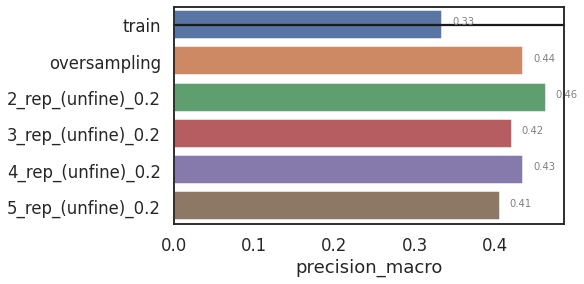

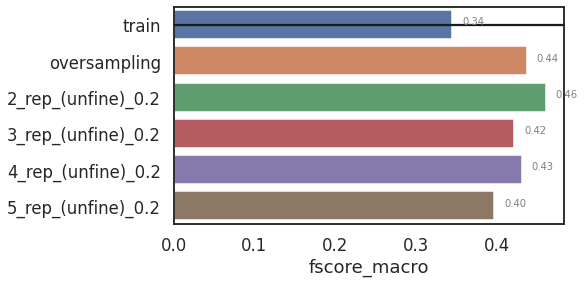

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0675, train_acc:0.4605, val Loss: : 1.0709, val_acc: 0.448
[epoch 2] train_loss: 1.0103, train_acc:0.5322, val Loss: : 1.0180, val_acc: 0.504
[epoch 3] train_loss: 0.9485, train_acc:0.5531, val Loss: : 0.9593, val_acc: 0.517
[epoch 4] train_loss: 0.8912, train_acc:0.5613, val Loss: : 0.9061, val_acc: 0.527
[epoch 5] train_loss: 0.8999, train_acc:0.5778, val Loss: : 0.9181, val_acc: 0.521
[epoch 6] train_loss: 0.8683, train_acc:0.5920, val Loss: : 0.8994, val_acc: 0.525
[epoch 7] train_loss: 0.8499, train_acc:0.5994, val Loss: : 0.8928, val_acc: 0.533
[epoch 8] train_loss: 0.8367, train_acc:0.6150, val Loss: : 0.8913, val_acc: 0.537
[epoch 9] train_loss: 0.8210, train_acc:0.6255, val Loss: : 0.8901, val_acc: 0.538
[epoch 10]

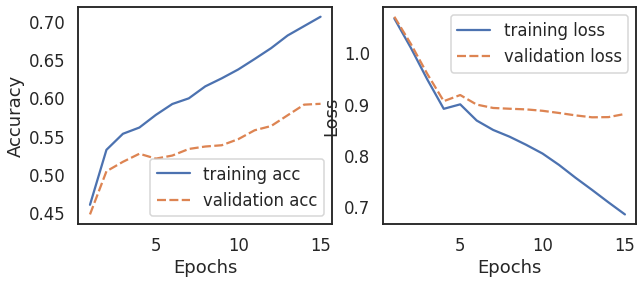

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 4802
[epoch 1] train_loss: 1.0762, train_acc:0.4421, val Loss: : 1.1058, val_acc: 0.307
[epoch 2] train_loss: 1.0419, train_acc:0.5109, val Loss: : 1.0936, val_acc: 0.363
[epoch 3] train_loss: 0.9984, train_acc:0.5468, val Loss: : 1.0755, val_acc: 0.395
[epoch 4] train_loss: 0.9385, train_acc:0.5752, val Loss: : 1.0484, val_acc: 0.428
[epoch 5] train_loss: 0.8640, train_acc:0.6078, val Loss: : 1.0121, val_acc: 0.458
[epoch 6] train_loss: 0.7934, train_acc:0.6464, val Loss: : 1.0002, val_acc: 0.463
[epoch 7] train_loss: 0.7192, train_acc:0.6887, val Loss: : 0.9689, val_acc: 0.487
[epoch 8] train_loss: 0.6517, train_acc:0.7144, val Loss: : 0.9678, val_acc: 0.509
[epoch 9] train_loss: 0.6071, train_acc:0.7325, val Lo

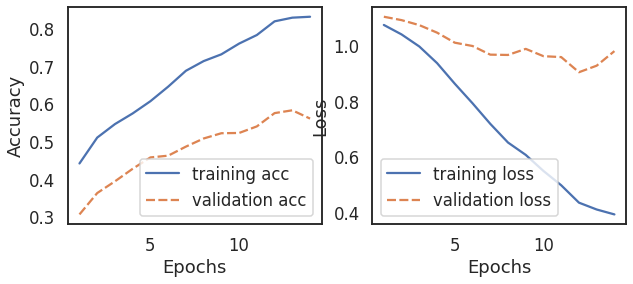

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(unfine)_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0620, train_acc:0.4485, val Loss: : 1.0865, val_acc: 0.409
[epoch 2] train_loss: 1.0244, train_acc:0.5000, val Loss: : 1.0910, val_acc: 0.387
[epoch 3] train_loss: 0.9834, train_acc:0.5376, val Loss: : 1.0867, val_acc: 0.397
[epoch 4] train_loss: 0.9318, train_acc:0.5749, val Loss: : 1.0652, val_acc: 0.425
[epoch 5] train_loss: 0.8668, train_acc:0.6143, val Loss: : 1.0365, val_acc: 0.454
[epoch 6] train_loss: 0.8032, train_acc:0.6455, val Loss: : 0.9896, val_acc: 0.497
[epoch 7] train_loss: 0.7241, train_acc:0.6859, val Loss: : 0.9326, val_acc: 0.529
[epoch 8] train_loss: 0.6630, train_acc:0.7139, val Loss: : 0.8977, val_acc: 0.560
[epoch 9] train_loss: 0.6064, train_acc:0.7419, val Loss: : 

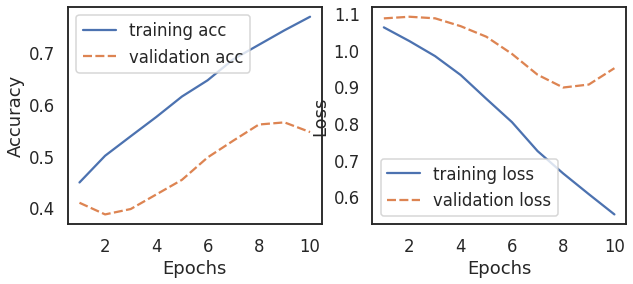

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(unfine)_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0565, train_acc:0.4593, val Loss: : 1.0988, val_acc: 0.339
[epoch 2] train_loss: 1.0151, train_acc:0.5078, val Loss: : 1.0878, val_acc: 0.374
[epoch 3] train_loss: 0.9706, train_acc:0.5438, val Loss: : 1.0734, val_acc: 0.403
[epoch 4] train_loss: 0.9167, train_acc:0.5825, val Loss: : 1.0467, val_acc: 0.437
[epoch 5] train_loss: 0.8475, train_acc:0.6151, val Loss: : 1.0029, val_acc: 0.471
[epoch 6] train_loss: 0.7879, train_acc:0.6428, val Loss: : 1.0140, val_acc: 0.476
[epoch 7] train_loss: 0.7137, train_acc:0.6886, val Loss: : 0.9617, val_acc: 0.499
[epoch 8] train_loss: 0.6549, train_acc:0.7146, val Loss: : 0.9426, val_acc: 0.515
[epoch 9] train_loss: 0.6071, train_acc:0.7307, val Loss: : 

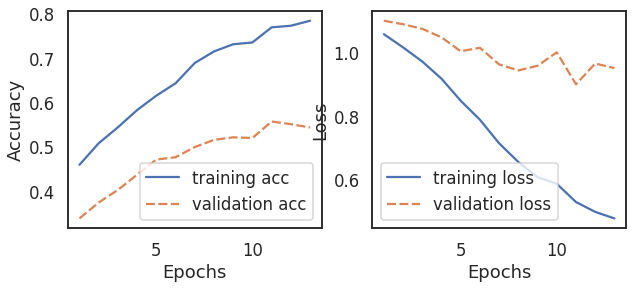

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(unfine)_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0387, train_acc:0.4933, val Loss: : 1.0859, val_acc: 0.382
[epoch 2] train_loss: 0.9821, train_acc:0.5328, val Loss: : 1.0810, val_acc: 0.391
[epoch 3] train_loss: 0.9278, train_acc:0.5644, val Loss: : 1.0662, val_acc: 0.414
[epoch 4] train_loss: 0.8700, train_acc:0.5914, val Loss: : 1.0349, val_acc: 0.444
[epoch 5] train_loss: 0.8072, train_acc:0.6189, val Loss: : 0.9799, val_acc: 0.481
[epoch 6] train_loss: 0.7487, train_acc:0.6454, val Loss: : 0.9708, val_acc: 0.493
[epoch 7] train_loss: 0.7002, train_acc:0.6771, val Loss: : 0.9472, val_acc: 0.511
[epoch 8] train_loss: 0.6501, train_acc:0.7034, val Loss: : 0.9357, val_acc: 0.513
[epoch 9] train_loss: 0.6071, train_acc:0.7235, val Loss: : 

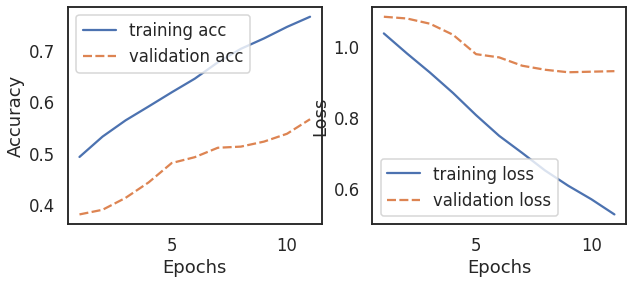

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(unfine)_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0269, train_acc:0.4875, val Loss: : 1.1029, val_acc: 0.329
[epoch 2] train_loss: 0.9606, train_acc:0.5400, val Loss: : 1.0870, val_acc: 0.383
[epoch 3] train_loss: 0.9019, train_acc:0.5758, val Loss: : 1.0558, val_acc: 0.436
[epoch 4] train_loss: 0.8444, train_acc:0.6103, val Loss: : 1.0097, val_acc: 0.469
[epoch 5] train_loss: 0.7822, train_acc:0.6394, val Loss: : 0.9423, val_acc: 0.512
[epoch 6] train_loss: 0.7224, train_acc:0.6633, val Loss: : 0.9525, val_acc: 0.493
[epoch 7] train_loss: 0.6892, train_acc:0.6790, val Loss: : 0.9745, val_acc: 0.497
[epoch 8] train_loss: 0.6397, train_acc:0.7040, val Loss: : 0.9385, val_acc: 0.522
[epoch 9] train_loss: 0.6030, train_acc:0.7278, val Loss: : 

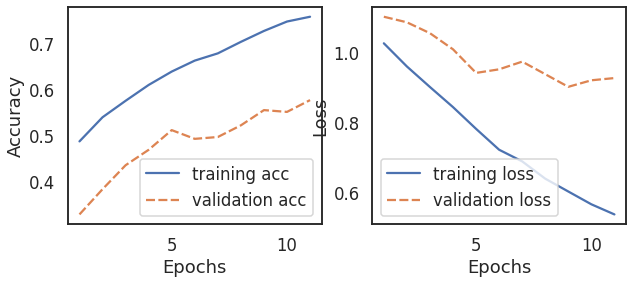

----------------------------------------------------------------------
acc_list [0.5934065934065934, 0.5698745698745699, 0.5583305583305583, 0.5766455766455767, 0.5670995670995671, 0.5542235542235542]
loss_list [0.8949906826019287, 0.9555999636650085, 0.9424669146537781, 0.9244999885559082, 0.9346931576728821, 0.9440996050834656]
precision_list [array([0.23809524, 0.58407234, 0.61229534]), array([0.22024367, 0.63919214, 0.59770921]), array([0.17485429, 0.59216998, 0.66422018]), array([0.20087336, 0.58197291, 0.66536661]), array([0.18870056, 0.59358821, 0.63217279]), array([0.15258856, 0.59546589, 0.63290323])]
recall_list [array([0.00732064, 0.75551057, 0.51082474]), array([0.34407028, 0.52676563, 0.65902062]), array([0.30746706, 0.67701305, 0.46649485]), array([0.20204978, 0.7537112 , 0.43969072]), array([0.24450952, 0.67049033, 0.50541237]), array([0.24597365, 0.64394962, 0.5056701 ])]
fscore_list [array([0.01420455, 0.65882122, 0.55697625]), array([0.26857143, 0.57755857, 0.62686933

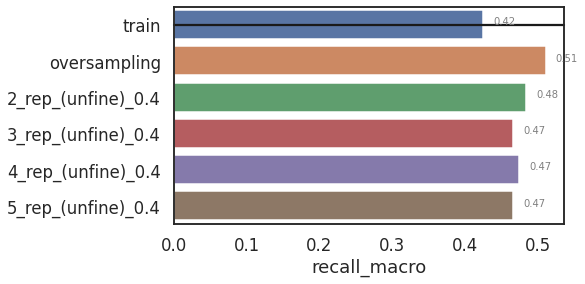

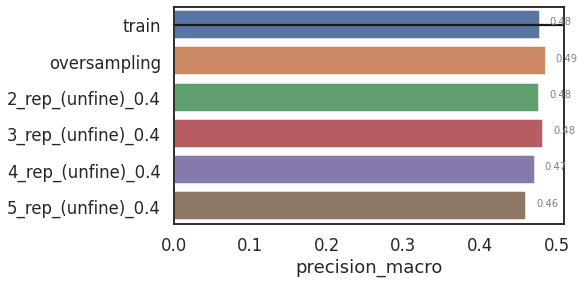

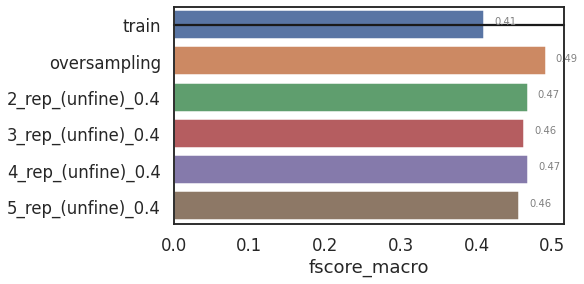

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0554, train_acc:0.4822, val Loss: : 1.0585, val_acc: 0.456
[epoch 2] train_loss: 0.9709, train_acc:0.5483, val Loss: : 0.9773, val_acc: 0.520
[epoch 3] train_loss: 0.8916, train_acc:0.5553, val Loss: : 0.8996, val_acc: 0.530
[epoch 4] train_loss: 0.8866, train_acc:0.5724, val Loss: : 0.9036, val_acc: 0.531
[epoch 5] train_loss: 0.8548, train_acc:0.5932, val Loss: : 0.8878, val_acc: 0.552
[epoch 6] train_loss: 0.8340, train_acc:0.6102, val Loss: : 0.8846, val_acc: 0.559
[epoch 7] train_loss: 0.8081, train_acc:0.6305, val Loss: : 0.8782, val_acc: 0.566
[epoch 8] train_loss: 0.7731, train_acc:0.6535, val Loss: : 0.8680, val_acc: 0.586
[epoch 9] train_loss: 0.7421, train_acc:0.6740, val Loss: : 0.8655, val_acc: 0.602
[epoch 10]

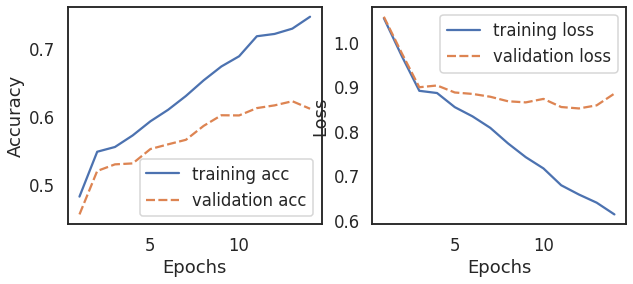

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 7128
[epoch 1] train_loss: 1.0639, train_acc:0.4687, val Loss: : 1.0925, val_acc: 0.364
[epoch 2] train_loss: 1.0096, train_acc:0.5128, val Loss: : 1.0828, val_acc: 0.389
[epoch 3] train_loss: 0.9182, train_acc:0.5680, val Loss: : 1.0436, val_acc: 0.442
[epoch 4] train_loss: 0.8368, train_acc:0.6207, val Loss: : 0.9529, val_acc: 0.489
[epoch 5] train_loss: 0.7576, train_acc:0.6592, val Loss: : 0.9303, val_acc: 0.511
[epoch 6] train_loss: 0.6906, train_acc:0.6892, val Loss: : 0.8933, val_acc: 0.543
[epoch 7] train_loss: 0.6375, train_acc:0.7182, val Loss: : 0.8954, val_acc: 0.556
[epoch 8] train_loss: 0.5500, train_acc:0.7602, val Loss: : 0.9165, val_acc: 0.562
[epoch 9] train_loss: 0.5272, train_acc:0.7688, val Lo

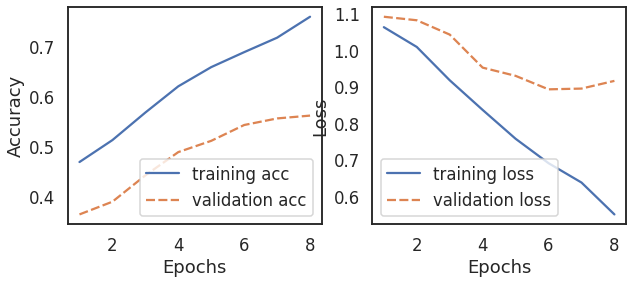

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(unfine)_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0476, train_acc:0.4600, val Loss: : 1.0986, val_acc: 0.341
[epoch 2] train_loss: 0.9936, train_acc:0.5239, val Loss: : 1.0742, val_acc: 0.404
[epoch 3] train_loss: 0.9085, train_acc:0.5779, val Loss: : 1.0317, val_acc: 0.458
[epoch 4] train_loss: 0.8198, train_acc:0.6225, val Loss: : 1.0258, val_acc: 0.471
[epoch 5] train_loss: 0.7317, train_acc:0.6757, val Loss: : 0.9221, val_acc: 0.514
[epoch 6] train_loss: 0.6749, train_acc:0.6914, val Loss: : 0.9845, val_acc: 0.509
[epoch 7] train_loss: 0.5917, train_acc:0.7415, val Loss: : 0.9102, val_acc: 0.550
[epoch 8] train_loss: 0.5367, train_acc:0.7680, val Loss: : 0.9010, val_acc: 0.572
[epoch 9] train_loss: 0.5316, train_acc:0.7634, val Loss: : 

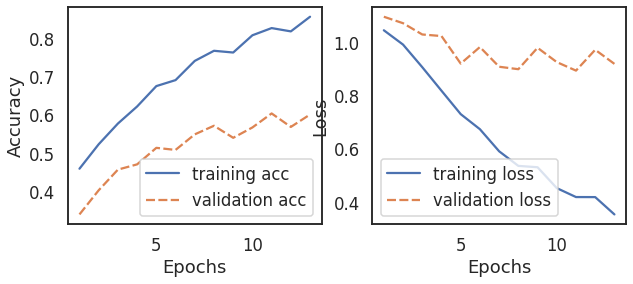

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(unfine)_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0395, train_acc:0.4713, val Loss: : 1.0982, val_acc: 0.345
[epoch 2] train_loss: 0.9841, train_acc:0.5264, val Loss: : 1.0718, val_acc: 0.405
[epoch 3] train_loss: 0.9008, train_acc:0.5723, val Loss: : 1.0471, val_acc: 0.432
[epoch 4] train_loss: 0.8137, train_acc:0.6206, val Loss: : 0.9982, val_acc: 0.483
[epoch 5] train_loss: 0.7323, train_acc:0.6614, val Loss: : 0.9703, val_acc: 0.486
[epoch 6] train_loss: 0.6604, train_acc:0.6934, val Loss: : 0.9302, val_acc: 0.521
[epoch 7] train_loss: 0.5962, train_acc:0.7316, val Loss: : 0.9091, val_acc: 0.546
[epoch 8] train_loss: 0.5366, train_acc:0.7631, val Loss: : 0.9324, val_acc: 0.560
[epoch 9] train_loss: 0.4926, train_acc:0.7868, val Loss: : 

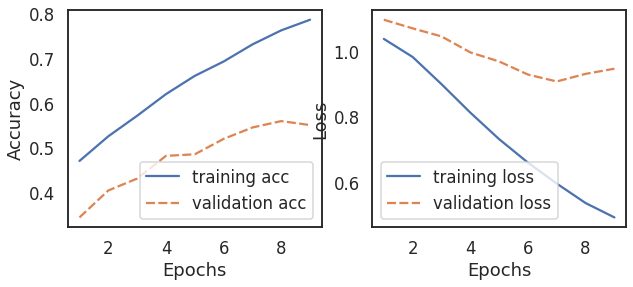

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(unfine)_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0201, train_acc:0.4909, val Loss: : 1.0928, val_acc: 0.367
[epoch 2] train_loss: 0.9474, train_acc:0.5480, val Loss: : 1.0556, val_acc: 0.424
[epoch 3] train_loss: 0.8460, train_acc:0.5965, val Loss: : 0.9916, val_acc: 0.477
[epoch 4] train_loss: 0.7769, train_acc:0.6367, val Loss: : 0.9974, val_acc: 0.484
[epoch 5] train_loss: 0.7130, train_acc:0.6686, val Loss: : 0.9633, val_acc: 0.489
[epoch 6] train_loss: 0.6617, train_acc:0.6943, val Loss: : 0.9740, val_acc: 0.497
[epoch 7] train_loss: 0.6073, train_acc:0.7234, val Loss: : 0.9604, val_acc: 0.519
[epoch 8] train_loss: 0.5503, train_acc:0.7566, val Loss: : 0.9011, val_acc: 0.562
[epoch 9] train_loss: 0.5131, train_acc:0.7717, val Loss: : 

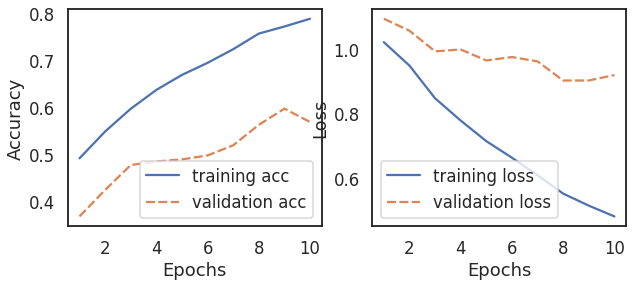

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(unfine)_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0001, train_acc:0.5126, val Loss: : 1.0796, val_acc: 0.401
[epoch 2] train_loss: 0.9176, train_acc:0.5541, val Loss: : 1.0580, val_acc: 0.423
[epoch 3] train_loss: 0.8302, train_acc:0.5892, val Loss: : 0.9873, val_acc: 0.471
[epoch 4] train_loss: 0.7616, train_acc:0.6270, val Loss: : 0.9634, val_acc: 0.495
[epoch 5] train_loss: 0.7002, train_acc:0.6637, val Loss: : 0.9630, val_acc: 0.498
[epoch 6] train_loss: 0.6525, train_acc:0.6915, val Loss: : 0.9256, val_acc: 0.516
[epoch 7] train_loss: 0.6109, train_acc:0.7099, val Loss: : 0.9122, val_acc: 0.536
[epoch 8] train_loss: 0.5735, train_acc:0.7319, val Loss: : 0.8979, val_acc: 0.553
[epoch 9] train_loss: 0.5249, train_acc:0.7590, val Loss: : 

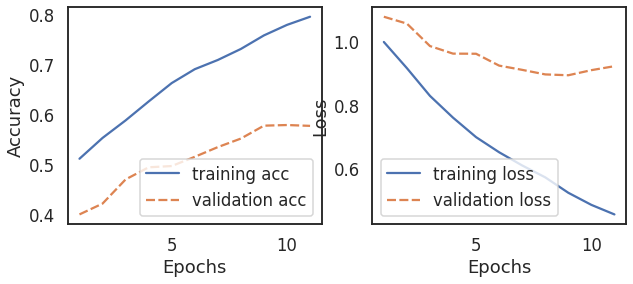

----------------------------------------------------------------------
acc_list [0.6249306249306249, 0.5048285048285048, 0.5527805527805528, 0.5288045288045288, 0.5718725718725719, 0.5907425907425907]
loss_list [0.8585523366928101, 1.0051319599151611, 1.0508278608322144, 0.9888263940811157, 0.9272088408470154, 0.9021304845809937]
precision_list [array([0.2       , 0.60597685, 0.67070064]), array([0.16271793, 0.58457493, 0.6865942 ]), array([0.16799544, 0.62753319, 0.67263514]), array([0.17483757, 0.65218855, 0.5823746 ]), array([0.2195122 , 0.57758768, 0.67295597]), array([0.23443223, 0.59839132, 0.6400385 ])]
recall_list [array([0.02342606, 0.78902384, 0.54278351]), array([0.5329429 , 0.60008997, 0.39072165]), array([0.43191801, 0.60593792, 0.51314433]), array([0.43338214, 0.43567251, 0.65231959]), array([0.25036603, 0.75933423, 0.41365979]), array([0.18740849, 0.71952317, 0.51417526])]
fscore_list [array([0.04193971, 0.68549096, 0.6       ]), array([0.24931507, 0.59223085, 0.49802891

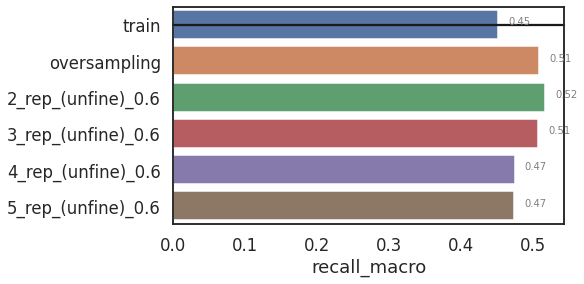

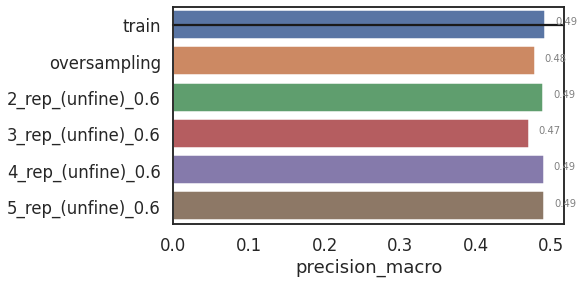

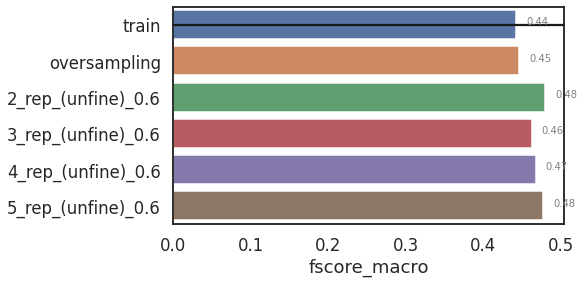

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9933, train_acc:0.5198, val Loss: : 0.9969, val_acc: 0.508
[epoch 2] train_loss: 0.8957, train_acc:0.5552, val Loss: : 0.9030, val_acc: 0.532
[epoch 3] train_loss: 0.8785, train_acc:0.5685, val Loss: : 0.8969, val_acc: 0.536
[epoch 4] train_loss: 0.8532, train_acc:0.5883, val Loss: : 0.8866, val_acc: 0.549
[epoch 5] train_loss: 0.8261, train_acc:0.6134, val Loss: : 0.8777, val_acc: 0.556
[epoch 6] train_loss: 0.7862, train_acc:0.6401, val Loss: : 0.8623, val_acc: 0.585
[epoch 7] train_loss: 0.7495, train_acc:0.6661, val Loss: : 0.8596, val_acc: 0.608
[epoch 8] train_loss: 0.7177, train_acc:0.6863, val Loss: : 0.8516, val_acc: 0.608
[epoch 9] train_loss: 0.6906, train_acc:0.7027, val Loss: : 0.8490, val_acc: 0.610
[epoch 10]

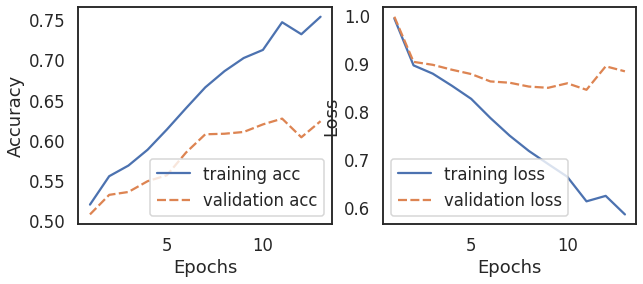

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 9488
[epoch 1] train_loss: 1.0597, train_acc:0.4614, val Loss: : 1.0964, val_acc: 0.357
[epoch 2] train_loss: 0.9855, train_acc:0.5234, val Loss: : 1.0611, val_acc: 0.422
[epoch 3] train_loss: 0.8756, train_acc:0.5849, val Loss: : 1.0143, val_acc: 0.455
[epoch 4] train_loss: 0.7613, train_acc:0.6560, val Loss: : 0.9426, val_acc: 0.506
[epoch 5] train_loss: 0.6997, train_acc:0.6902, val Loss: : 1.0170, val_acc: 0.497
[epoch 6] train_loss: 0.6002, train_acc:0.7396, val Loss: : 0.9332, val_acc: 0.544
[epoch 7] train_loss: 0.5559, train_acc:0.7541, val Loss: : 0.9256, val_acc: 0.550
[epoch 8] train_loss: 0.4745, train_acc:0.8019, val Loss: : 0.8788, val_acc: 0.594
[epoch 9] train_loss: 0.4267, train_acc:0.8261, val Lo

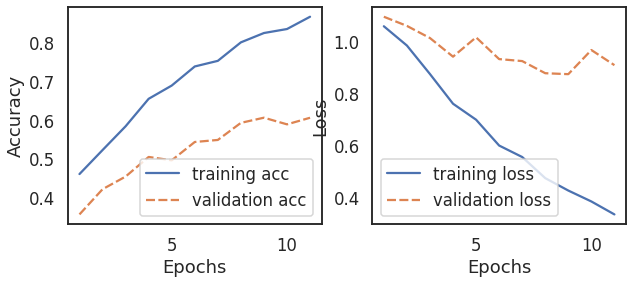

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(unfine)_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0399, train_acc:0.4688, val Loss: : 1.0830, val_acc: 0.396
[epoch 2] train_loss: 0.9613, train_acc:0.5352, val Loss: : 1.0412, val_acc: 0.446
[epoch 3] train_loss: 0.8561, train_acc:0.5958, val Loss: : 1.0504, val_acc: 0.449
[epoch 4] train_loss: 0.7599, train_acc:0.6599, val Loss: : 0.9707, val_acc: 0.498
[epoch 5] train_loss: 0.6899, train_acc:0.6913, val Loss: : 0.8977, val_acc: 0.559
[epoch 6] train_loss: 0.6204, train_acc:0.7281, val Loss: : 0.8891, val_acc: 0.564
[epoch 7] train_loss: 0.5547, train_acc:0.7607, val Loss: : 0.8946, val_acc: 0.582
[epoch 8] train_loss: 0.4980, train_acc:0.7909, val Loss: : 0.8672, val_acc: 0.597
[epoch 9] train_loss: 0.4390, train_acc:0.8183, val Loss: : 

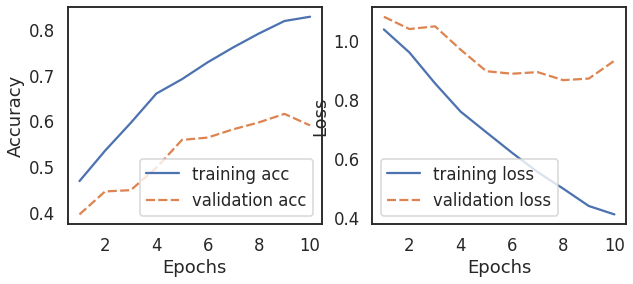

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(unfine)_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0299, train_acc:0.4818, val Loss: : 1.0829, val_acc: 0.393
[epoch 2] train_loss: 0.9504, train_acc:0.5422, val Loss: : 1.0490, val_acc: 0.425
[epoch 3] train_loss: 0.8425, train_acc:0.6020, val Loss: : 1.0075, val_acc: 0.471
[epoch 4] train_loss: 0.7435, train_acc:0.6553, val Loss: : 0.9674, val_acc: 0.490
[epoch 5] train_loss: 0.6589, train_acc:0.6997, val Loss: : 0.8965, val_acc: 0.549
[epoch 6] train_loss: 0.5906, train_acc:0.7303, val Loss: : 0.9365, val_acc: 0.557
[epoch 7] train_loss: 0.5410, train_acc:0.7583, val Loss: : 0.8608, val_acc: 0.592
[epoch 8] train_loss: 0.4788, train_acc:0.7850, val Loss: : 0.8910, val_acc: 0.596
[epoch 9] train_loss: 0.4288, train_acc:0.8179, val Loss: : 

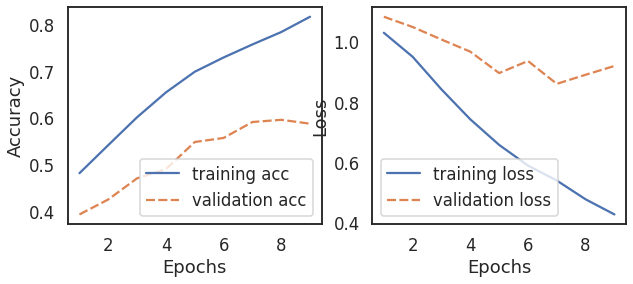

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(unfine)_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0132, train_acc:0.4949, val Loss: : 1.0832, val_acc: 0.392
[epoch 2] train_loss: 0.9227, train_acc:0.5648, val Loss: : 1.0145, val_acc: 0.475
[epoch 3] train_loss: 0.7976, train_acc:0.6212, val Loss: : 0.9524, val_acc: 0.506
[epoch 4] train_loss: 0.7205, train_acc:0.6675, val Loss: : 0.9468, val_acc: 0.516
[epoch 5] train_loss: 0.6490, train_acc:0.7045, val Loss: : 0.9617, val_acc: 0.541
[epoch 6] train_loss: 0.5920, train_acc:0.7366, val Loss: : 0.9315, val_acc: 0.554
[epoch 7] train_loss: 0.5219, train_acc:0.7752, val Loss: : 0.8587, val_acc: 0.602
[epoch 8] train_loss: 0.4959, train_acc:0.7901, val Loss: : 0.8524, val_acc: 0.626
[epoch 9] train_loss: 0.4572, train_acc:0.8049, val Loss: : 

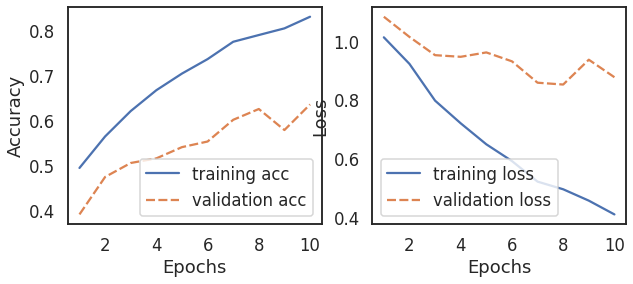

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(unfine)_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9875, train_acc:0.5090, val Loss: : 1.0837, val_acc: 0.388
[epoch 2] train_loss: 0.8909, train_acc:0.5756, val Loss: : 1.0125, val_acc: 0.478
[epoch 3] train_loss: 0.7790, train_acc:0.6242, val Loss: : 0.9619, val_acc: 0.493
[epoch 4] train_loss: 0.6993, train_acc:0.6699, val Loss: : 0.9433, val_acc: 0.528
[epoch 5] train_loss: 0.6343, train_acc:0.7106, val Loss: : 0.9185, val_acc: 0.559
[epoch 6] train_loss: 0.5771, train_acc:0.7411, val Loss: : 0.9075, val_acc: 0.584
[epoch 7] train_loss: 0.5230, train_acc:0.7744, val Loss: : 0.8791, val_acc: 0.593
[epoch 8] train_loss: 0.4820, train_acc:0.7922, val Loss: : 0.9015, val_acc: 0.593
[epoch 9] train_loss: 0.4333, train_acc:0.8200, val Loss: : 

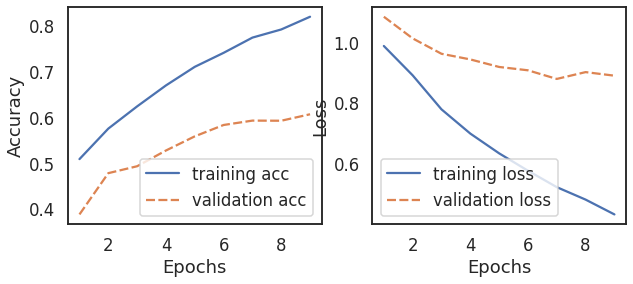

----------------------------------------------------------------------
acc_list [0.6220446220446221, 0.6209346209346209, 0.5955155955155955, 0.5807525807525807, 0.606948606948607, 0.6122766122766122]
loss_list [0.8808857202529907, 0.9502353072166443, 0.951434314250946, 0.9706487059593201, 0.9226068258285522, 0.8901919722557068]
precision_list [array([0.27333333, 0.6158502 , 0.64585666]), array([0.26890756, 0.60923623, 0.71982759]), array([0.23142251, 0.62670015, 0.65450122]), array([0.21949153, 0.62698225, 0.64483907]), array([0.22065728, 0.65060241, 0.64373089]), array([0.22844175, 0.60663256, 0.71892497])]
recall_list [array([0.06002928, 0.73234368, 0.59458763]), array([0.23426061, 0.77147998, 0.51649485]), array([0.31918009, 0.67363923, 0.55463918]), array([0.37920937, 0.59581646, 0.59896907]), array([0.27525622, 0.6194332 , 0.65103093]), array([0.22108346, 0.77350427, 0.49639175])]
fscore_list [array([0.09843938, 0.66906401, 0.61916264]), array([0.25039124, 0.68082572, 0.60144058])

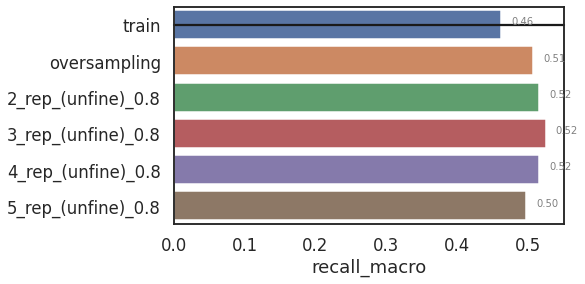

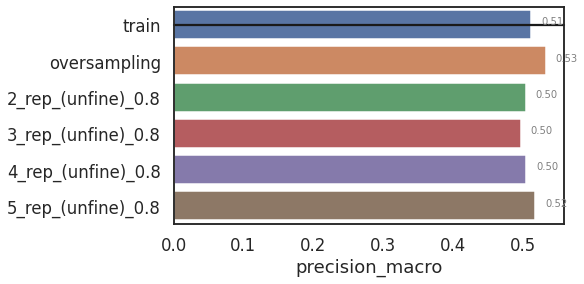

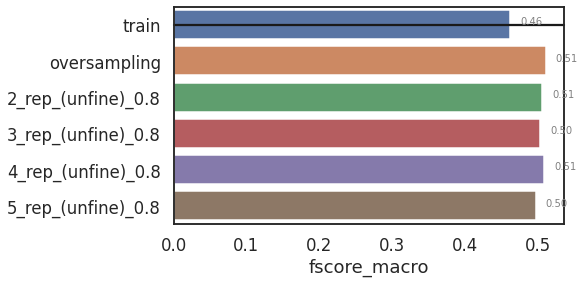

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9653, train_acc:0.5287, val Loss: : 0.9687, val_acc: 0.512
[epoch 2] train_loss: 0.9089, train_acc:0.5542, val Loss: : 0.9138, val_acc: 0.528
[epoch 3] train_loss: 0.8675, train_acc:0.5734, val Loss: : 0.8887, val_acc: 0.537
[epoch 4] train_loss: 0.8420, train_acc:0.6002, val Loss: : 0.8808, val_acc: 0.551
[epoch 5] train_loss: 0.7986, train_acc:0.6320, val Loss: : 0.8605, val_acc: 0.580
[epoch 6] train_loss: 0.7545, train_acc:0.6648, val Loss: : 0.8488, val_acc: 0.611
[epoch 7] train_loss: 0.7156, train_acc:0.6860, val Loss: : 0.8284, val_acc: 0.622
[epoch 8] train_loss: 0.6807, train_acc:0.7072, val Loss: : 0.8235, val_acc: 0.631
[epoch 9] train_loss: 0.6337, train_acc:0.7365, val Loss: : 0.8215, val_acc: 0.642
[epoch 10]

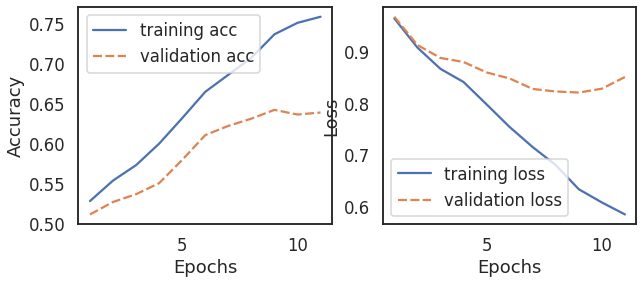

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 11850
[epoch 1] train_loss: 1.0456, train_acc:0.4796, val Loss: : 1.0762, val_acc: 0.401
[epoch 2] train_loss: 0.9268, train_acc:0.5590, val Loss: : 1.0110, val_acc: 0.446
[epoch 3] train_loss: 0.8455, train_acc:0.6103, val Loss: : 0.9340, val_acc: 0.522
[epoch 4] train_loss: 0.7265, train_acc:0.6742, val Loss: : 0.9769, val_acc: 0.529
[epoch 5] train_loss: 0.6380, train_acc:0.7292, val Loss: : 0.8451, val_acc: 0.588
[epoch 6] train_loss: 0.5409, train_acc:0.7756, val Loss: : 0.8569, val_acc: 0.600
[epoch 7] train_loss: 0.4774, train_acc:0.7987, val Loss: : 0.8784, val_acc: 0.605
[epoch 8] train_loss: 0.4130, train_acc:0.8336, val Loss: : 0.8607, val_acc: 0.624


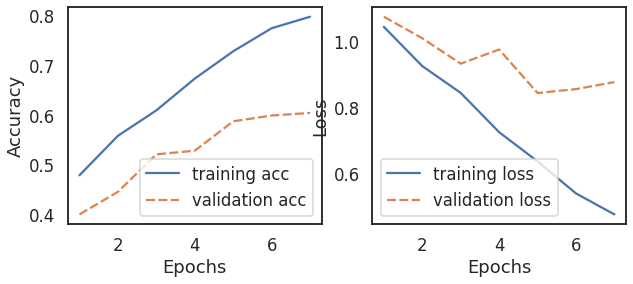

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(unfine)_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0265, train_acc:0.4838, val Loss: : 1.0800, val_acc: 0.395
[epoch 2] train_loss: 0.9083, train_acc:0.5644, val Loss: : 1.0214, val_acc: 0.470
[epoch 3] train_loss: 0.7814, train_acc:0.6385, val Loss: : 0.9562, val_acc: 0.500
[epoch 4] train_loss: 0.7009, train_acc:0.6812, val Loss: : 0.9853, val_acc: 0.515
[epoch 5] train_loss: 0.6265, train_acc:0.7253, val Loss: : 0.8470, val_acc: 0.606
[epoch 6] train_loss: 0.5231, train_acc:0.7765, val Loss: : 0.8486, val_acc: 0.608
[epoch 7] train_loss: 0.4643, train_acc:0.8031, val Loss: : 0.8696, val_acc: 0.604
[epoch 8] train_loss: 0.4219, train_acc:0.8252, val Loss: : 0.8636, val_acc: 0.622


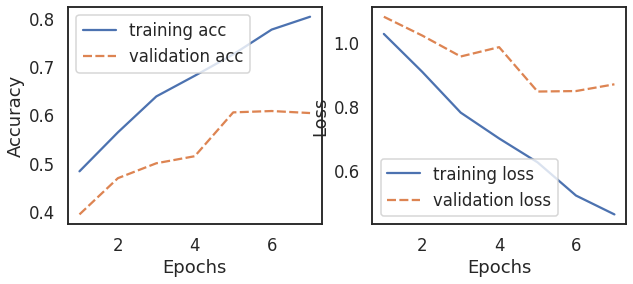

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(unfine)_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0249, train_acc:0.4824, val Loss: : 1.0801, val_acc: 0.398
[epoch 2] train_loss: 0.9218, train_acc:0.5571, val Loss: : 1.0327, val_acc: 0.449
[epoch 3] train_loss: 0.7979, train_acc:0.6303, val Loss: : 0.9187, val_acc: 0.516
[epoch 4] train_loss: 0.6844, train_acc:0.6891, val Loss: : 0.9163, val_acc: 0.532
[epoch 5] train_loss: 0.5959, train_acc:0.7375, val Loss: : 0.9130, val_acc: 0.572
[epoch 6] train_loss: 0.5270, train_acc:0.7725, val Loss: : 0.8911, val_acc: 0.586
[epoch 7] train_loss: 0.4735, train_acc:0.7980, val Loss: : 0.8627, val_acc: 0.623
[epoch 8] train_loss: 0.4086, train_acc:0.8294, val Loss: : 0.8744, val_acc: 0.628
[epoch 9] train_loss: 0.3621, train_acc:0.8527, val Loss: : 0.

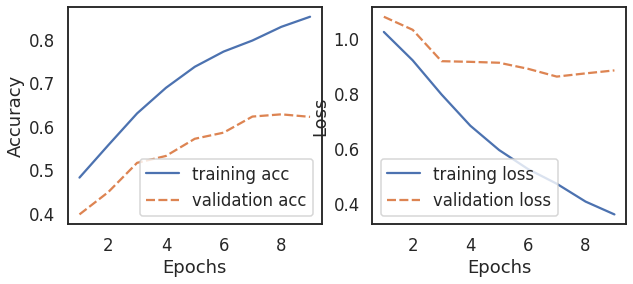

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(unfine)_1
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9949, train_acc:0.4957, val Loss: : 1.0803, val_acc: 0.392
[epoch 2] train_loss: 0.8720, train_acc:0.5691, val Loss: : 0.9878, val_acc: 0.475
[epoch 3] train_loss: 0.7594, train_acc:0.6403, val Loss: : 0.9348, val_acc: 0.505
[epoch 4] train_loss: 0.6609, train_acc:0.6922, val Loss: : 0.9032, val_acc: 0.544
[epoch 5] train_loss: 0.5847, train_acc:0.7358, val Loss: : 0.8742, val_acc: 0.591
[epoch 6] train_loss: 0.5314, train_acc:0.7657, val Loss: : 0.9227, val_acc: 0.574
[epoch 7] train_loss: 0.4627, train_acc:0.7984, val Loss: : 0.8515, val_acc: 0.626
[epoch 8] train_loss: 0.4296, train_acc:0.8118, val Loss: : 0.8629, val_acc: 0.632
[epoch 9] train_loss: 0.3945, train_acc:0.8299, val Loss: : 0.

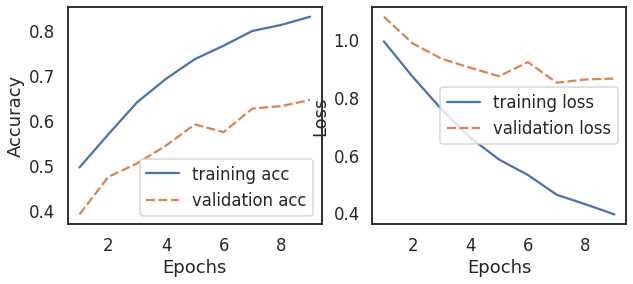

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(unfine)_1
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9724, train_acc:0.5167, val Loss: : 1.0778, val_acc: 0.404
[epoch 2] train_loss: 0.8235, train_acc:0.5945, val Loss: : 0.9390, val_acc: 0.505
[epoch 3] train_loss: 0.7203, train_acc:0.6534, val Loss: : 0.9081, val_acc: 0.518
[epoch 4] train_loss: 0.6590, train_acc:0.6889, val Loss: : 0.9524, val_acc: 0.528
[epoch 5] train_loss: 0.5951, train_acc:0.7253, val Loss: : 0.8825, val_acc: 0.568
[epoch 6] train_loss: 0.5281, train_acc:0.7650, val Loss: : 0.8844, val_acc: 0.582
[epoch 7] train_loss: 0.4843, train_acc:0.7875, val Loss: : 0.8964, val_acc: 0.581
[epoch 8] train_loss: 0.4363, train_acc:0.8126, val Loss: : 0.8957, val_acc: 0.604


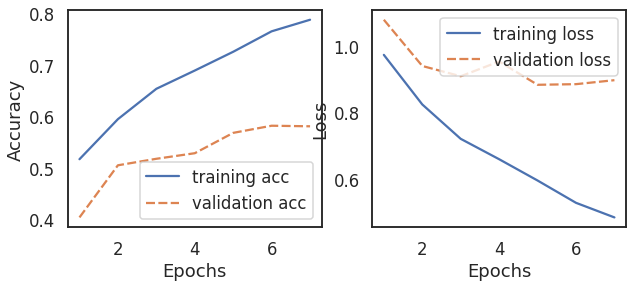

----------------------------------------------------------------------
acc_list [0.6352536352536352, 0.5867465867465868, 0.593961593961594, 0.63003663003663, 0.6446886446886447, 0.5996225996225997]
loss_list [0.8598532676696777, 0.8985615968704224, 0.8870396614074707, 0.8937989473342896, 0.8864426016807556, 0.8858773708343506]
precision_list [array([0.20520231, 0.62450522, 0.70241546]), array([0.20718954, 0.64526634, 0.69025157]), array([0.20717489, 0.62604167, 0.68358112]), array([0.2893617 , 0.65911744, 0.63839286]), array([0.2877907 , 0.644546  , 0.67868943]), array([0.23972603, 0.6320356 , 0.66323024])]
recall_list [array([0.10395315, 0.78070175, 0.5621134 ]), array([0.46412884, 0.62393162, 0.56572165]), array([0.33821376, 0.67588844, 0.54510309]), array([0.19912152, 0.63495277, 0.70025773]), array([0.14494876, 0.72964462, 0.63530928]), array([0.35871157, 0.63900135, 0.59690722])]
fscore_list [array([0.13799806, 0.69392243, 0.62448103]), array([0.28648893, 0.63441967, 0.62181303]),

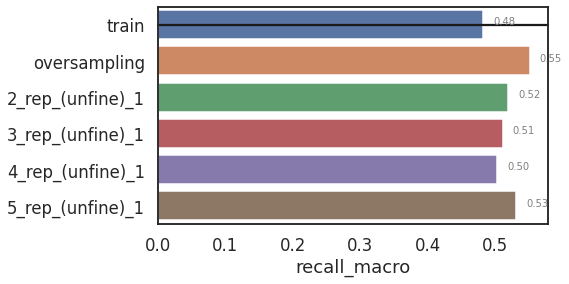

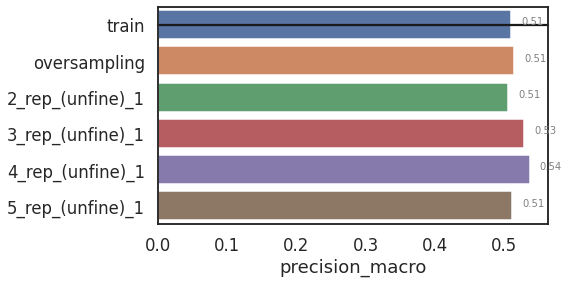

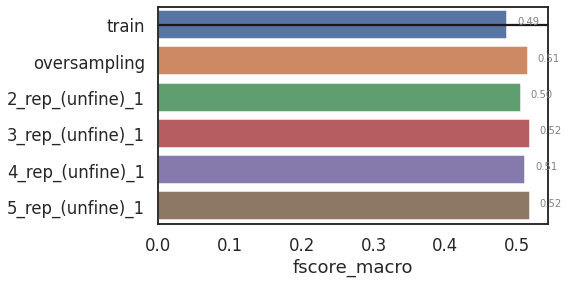

CPU times: user 23min 4s, sys: 27.5 s, total: 23min 31s
Wall time: 23min 27s


In [ ]:
%%time
      
task_name = 'sub_twitter'
tech_name = 'Bert_ data augmentation-master'
ratios = [0.2, 0.4, 0.6, 0.8, 1]
for ratio in ratios:
  if ratio == 0.2:
    test_list = ['train',
                 'oversampling',
                 '2_rep_(unfine)_0.2',
      '3_rep_(unfine)_0.2',
      '4_rep_(unfine)_0.2',
      '5_rep_(unfine)_0.2']
    print('<'*50)
    # print('ratio', ratio)
  if ratio == 0.4:
    test_list = ['train',
                 'oversampling',
                 '2_rep_(unfine)_0.4',
      '3_rep_(unfine)_0.4',
      '4_rep_(unfine)_0.4',
      '5_rep_(unfine)_0.4']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.6:
    test_list = ['train',
                 'oversampling',
                 '2_rep_(unfine)_0.6',
      '3_rep_(unfine)_0.6',
      '4_rep_(unfine)_0.6',
      '5_rep_(unfine)_0.6']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.8:
    test_list = ['train',
                 'oversampling',
                 '2_rep_(unfine)_0.8',
      '3_rep_(unfine)_0.8',
      '4_rep_(unfine)_0.8',
      '5_rep_(unfine)_0.8']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 1:
    test_list = ['train',
                 'oversampling',
                 '2_rep_(unfine)_1',
      '3_rep_(unfine)_1',
      '4_rep_(unfine)_1',
      '5_rep_(unfine)_1']

    print('<'*50)

  Execute(test_list, task_name, tech_name, ratio)

## Pretrain BERT

### fine tuned BERT(various ratio) (test set)


#### new one

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0882, train_acc:0.3844, val Loss: : 1.0907, val_acc: 0.380
[epoch 2] train_loss: 1.0604, train_acc:0.4704, val Loss: : 1.0665, val_acc: 0.445
[epoch 3] train_loss: 1.0318, train_acc:0.5197, val Loss: : 1.0421, val_acc: 0.484
[epoch 4] train_loss: 1.0029, train_acc:0.5474, val Loss: : 1.0165, val_acc: 0.502
[epoch 5] train_loss: 0.9702, train_acc:0.5589, val Loss: : 0.9892, val_acc: 0.509
[epoch 6] train_loss: 0.9390, train_acc:0.5688, val Loss: : 0.9597, val_acc: 0.511
[epoch 7] train_loss: 0.9065, train_acc:0.5724, val Loss: : 0.9290, val_acc: 0.514
[epoch 8] train_loss: 0.8792, train_acc:0.5700, val Loss: : 0.9059, val_acc: 0.515
[epoch 9] train_loss: 0.8813, train_acc:0.5787, val Loss: : 0.9097, val_acc: 0.520
[epoch 10]

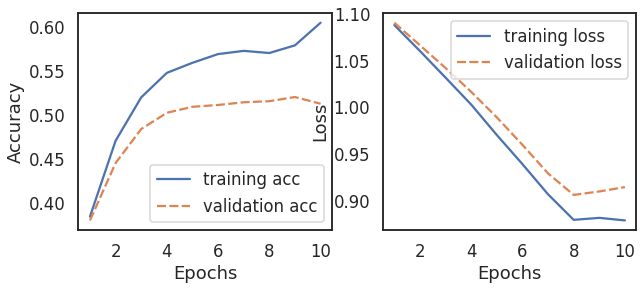

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 2351
[epoch 1] train_loss: 1.0860, train_acc:0.4071, val Loss: : 1.1049, val_acc: 0.314
[epoch 2] train_loss: 1.0655, train_acc:0.4786, val Loss: : 1.0981, val_acc: 0.348
[epoch 3] train_loss: 1.0434, train_acc:0.5244, val Loss: : 1.0910, val_acc: 0.377
[epoch 4] train_loss: 1.0191, train_acc:0.5511, val Loss: : 1.0835, val_acc: 0.395
[epoch 5] train_loss: 0.9922, train_acc:0.5670, val Loss: : 1.0725, val_acc: 0.412
[epoch 6] train_loss: 0.9627, train_acc:0.5863, val Loss: : 1.0607, val_acc: 0.428
[epoch 7] train_loss: 0.9298, train_acc:0.5976, val Loss: : 1.0458, val_acc: 0.444
[epoch 8] train_loss: 0.8920, train_acc:0.6192, val Loss: : 1.0253, val_acc: 0.456
[epoch 9] train_loss: 0.8502, train_acc:0.6406, val Lo

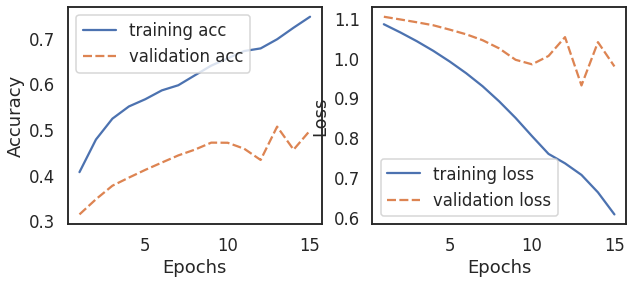

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(tuned)_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0850, train_acc:0.4235, val Loss: : 1.1005, val_acc: 0.339
[epoch 2] train_loss: 1.0625, train_acc:0.4967, val Loss: : 1.0975, val_acc: 0.354
[epoch 3] train_loss: 1.0384, train_acc:0.5308, val Loss: : 1.0933, val_acc: 0.367
[epoch 4] train_loss: 1.0119, train_acc:0.5556, val Loss: : 1.0886, val_acc: 0.379
[epoch 5] train_loss: 0.9821, train_acc:0.5837, val Loss: : 1.0789, val_acc: 0.400
[epoch 6] train_loss: 0.9488, train_acc:0.6023, val Loss: : 1.0658, val_acc: 0.422
[epoch 7] train_loss: 0.9116, train_acc:0.6198, val Loss: : 1.0462, val_acc: 0.443
[epoch 8] train_loss: 0.8704, train_acc:0.6332, val Loss: : 1.0202, val_acc: 0.459
[epoch 9] train_loss: 0.8277, train_acc:0.6424, val Loss: : 0

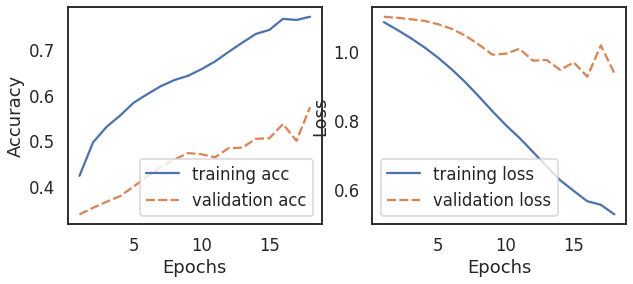

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(tuned)_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0813, train_acc:0.4218, val Loss: : 1.0912, val_acc: 0.398
[epoch 2] train_loss: 1.0585, train_acc:0.4979, val Loss: : 1.0918, val_acc: 0.382
[epoch 3] train_loss: 1.0340, train_acc:0.5413, val Loss: : 1.0917, val_acc: 0.375
[epoch 4] train_loss: 1.0070, train_acc:0.5536, val Loss: : 1.0903, val_acc: 0.370
[epoch 5] train_loss: 0.9775, train_acc:0.5646, val Loss: : 1.0871, val_acc: 0.379
[epoch 6] train_loss: 0.9455, train_acc:0.5806, val Loss: : 1.0795, val_acc: 0.388
[epoch 7] train_loss: 0.9114, train_acc:0.6040, val Loss: : 1.0661, val_acc: 0.410
[epoch 8] train_loss: 0.8750, train_acc:0.6153, val Loss: : 1.0449, val_acc: 0.432
[epoch 9] train_loss: 0.8363, train_acc:0.6332, val Loss: : 1

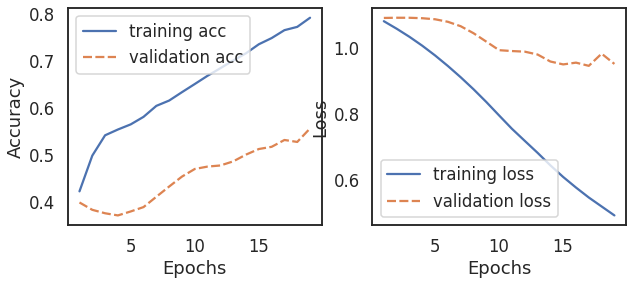

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(tuned)_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0784, train_acc:0.4320, val Loss: : 1.0813, val_acc: 0.413
[epoch 2] train_loss: 1.0463, train_acc:0.4963, val Loss: : 1.0830, val_acc: 0.404
[epoch 3] train_loss: 1.0157, train_acc:0.5261, val Loss: : 1.0828, val_acc: 0.399
[epoch 4] train_loss: 0.9854, train_acc:0.5506, val Loss: : 1.0800, val_acc: 0.397
[epoch 5] train_loss: 0.9547, train_acc:0.5672, val Loss: : 1.0729, val_acc: 0.402
[epoch 6] train_loss: 0.9227, train_acc:0.5828, val Loss: : 1.0589, val_acc: 0.419
[epoch 7] train_loss: 0.8894, train_acc:0.5972, val Loss: : 1.0398, val_acc: 0.440
[epoch 8] train_loss: 0.8563, train_acc:0.6122, val Loss: : 1.0153, val_acc: 0.457
[epoch 9] train_loss: 0.8247, train_acc:0.6274, val Loss: : 0

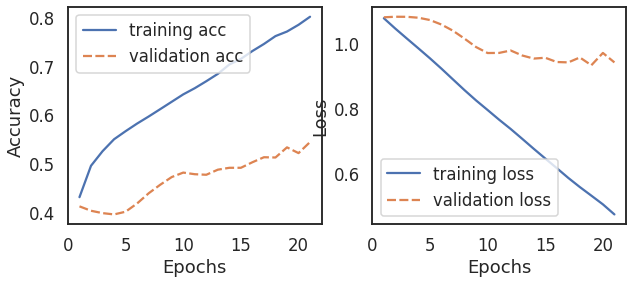

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(tuned)_0.2
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0617, train_acc:0.4258, val Loss: : 1.1056, val_acc: 0.311
[epoch 2] train_loss: 1.0248, train_acc:0.4844, val Loss: : 1.0987, val_acc: 0.347
[epoch 3] train_loss: 0.9913, train_acc:0.5189, val Loss: : 1.0885, val_acc: 0.376
[epoch 4] train_loss: 0.9594, train_acc:0.5485, val Loss: : 1.0750, val_acc: 0.398
[epoch 5] train_loss: 0.9274, train_acc:0.5688, val Loss: : 1.0580, val_acc: 0.422
[epoch 6] train_loss: 0.8950, train_acc:0.5895, val Loss: : 1.0370, val_acc: 0.446
[epoch 7] train_loss: 0.8622, train_acc:0.6095, val Loss: : 1.0116, val_acc: 0.465
[epoch 8] train_loss: 0.8319, train_acc:0.6216, val Loss: : 0.9828, val_acc: 0.480
[epoch 9] train_loss: 0.8055, train_acc:0.6300, val Loss: : 0

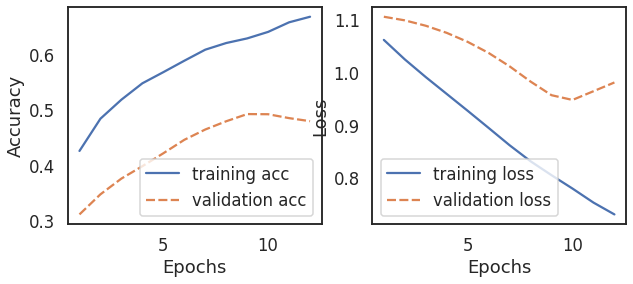

----------------------------------------------------------------------
acc_list [0.4993894993894994, 0.5323565323565324, 0.5232545232545233, 0.5272505272505272, 0.5538905538905539, 0.5002775002775003]
loss_list [0.9133044481277466, 0.9208174347877502, 0.9970502853393555, 1.0008362531661987, 0.9563985466957092, 0.9441804885864258]
precision_list [array([0.        , 0.53304952, 0.46634404]), array([0.18867925, 0.57766452, 0.53601036]), array([0.15232722, 0.58604336, 0.60164401]), array([0.15061728, 0.56858962, 0.62045193]), array([0.16588419, 0.57960438, 0.58994625]), array([0.12376934, 0.55467197, 0.50596659])]
recall_list [array([0.        , 0.53508772, 0.54639175]), array([0.17569546, 0.58636977, 0.53324742]), array([0.31625183, 0.58367072, 0.49046392]), array([0.26793558, 0.662843  , 0.41752577]), array([0.15519766, 0.67881242, 0.48092784]), array([0.12884334, 0.56477733, 0.49175258])]
fscore_list [array([0.        , 0.53406667, 0.50320437]), array([0.18195603, 0.5819846 , 0.53462532

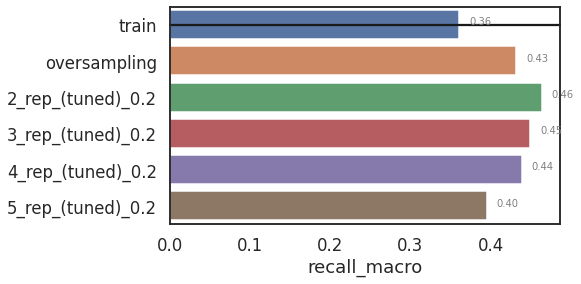

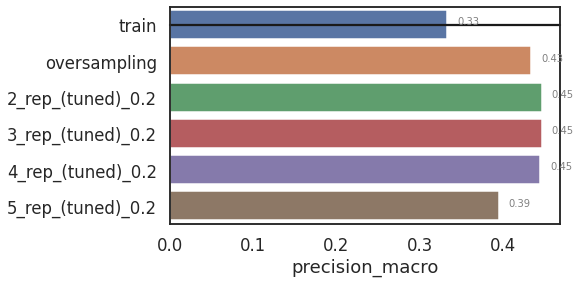

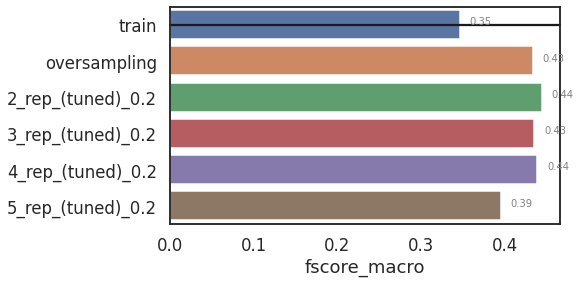

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0527, train_acc:0.4961, val Loss: : 1.0564, val_acc: 0.473
[epoch 2] train_loss: 0.9968, train_acc:0.5432, val Loss: : 1.0053, val_acc: 0.500
[epoch 3] train_loss: 0.9370, train_acc:0.5619, val Loss: : 0.9491, val_acc: 0.503
[epoch 4] train_loss: 0.8867, train_acc:0.5742, val Loss: : 0.9016, val_acc: 0.510
[epoch 5] train_loss: 0.8905, train_acc:0.5826, val Loss: : 0.9137, val_acc: 0.520
[epoch 6] train_loss: 0.8612, train_acc:0.5947, val Loss: : 0.8991, val_acc: 0.515
[epoch 7] train_loss: 0.8442, train_acc:0.6050, val Loss: : 0.8965, val_acc: 0.521
[epoch 8] train_loss: 0.8329, train_acc:0.6136, val Loss: : 0.8976, val_acc: 0.527
[epoch 9] train_loss: 0.8188, train_acc:0.6266, val Loss: : 0.8975, val_acc: 0.533
[epoch 10]

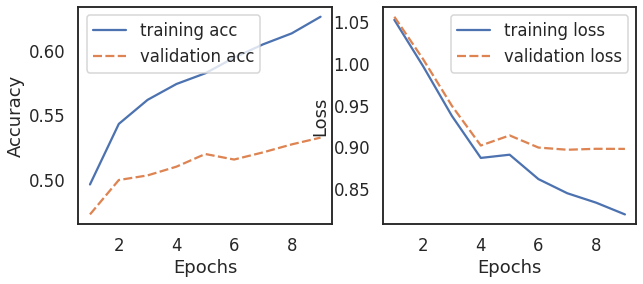

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 4802
[epoch 1] train_loss: 1.0733, train_acc:0.4532, val Loss: : 1.0956, val_acc: 0.362
[epoch 2] train_loss: 1.0396, train_acc:0.5008, val Loss: : 1.0869, val_acc: 0.381
[epoch 3] train_loss: 0.9973, train_acc:0.5387, val Loss: : 1.0752, val_acc: 0.396
[epoch 4] train_loss: 0.9397, train_acc:0.5752, val Loss: : 1.0394, val_acc: 0.435
[epoch 5] train_loss: 0.8644, train_acc:0.6053, val Loss: : 1.0391, val_acc: 0.430
[epoch 6] train_loss: 0.8117, train_acc:0.6268, val Loss: : 0.9476, val_acc: 0.491
[epoch 7] train_loss: 0.7440, train_acc:0.6748, val Loss: : 0.9409, val_acc: 0.499
[epoch 8] train_loss: 0.6813, train_acc:0.6960, val Loss: : 1.0107, val_acc: 0.482
[epoch 9] train_loss: 0.6485, train_acc:0.7083, val Lo

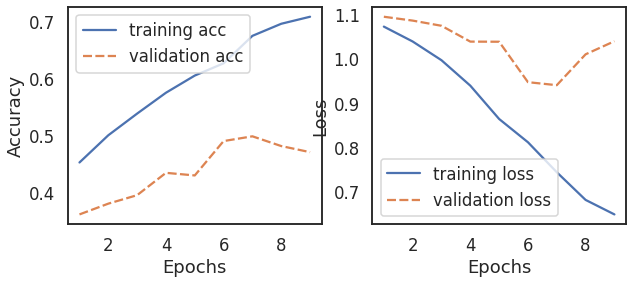

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(tuned)_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0771, train_acc:0.4443, val Loss: : 1.0918, val_acc: 0.381
[epoch 2] train_loss: 1.0416, train_acc:0.5021, val Loss: : 1.0857, val_acc: 0.390
[epoch 3] train_loss: 0.9976, train_acc:0.5264, val Loss: : 1.0832, val_acc: 0.394
[epoch 4] train_loss: 0.9396, train_acc:0.5588, val Loss: : 1.0644, val_acc: 0.418
[epoch 5] train_loss: 0.8775, train_acc:0.5889, val Loss: : 1.0190, val_acc: 0.458
[epoch 6] train_loss: 0.8115, train_acc:0.6366, val Loss: : 0.9787, val_acc: 0.487
[epoch 7] train_loss: 0.7486, train_acc:0.6762, val Loss: : 0.9664, val_acc: 0.491
[epoch 8] train_loss: 0.6932, train_acc:0.6935, val Loss: : 1.0002, val_acc: 0.477
[epoch 9] train_loss: 0.6497, train_acc:0.7143, val Loss: : 1

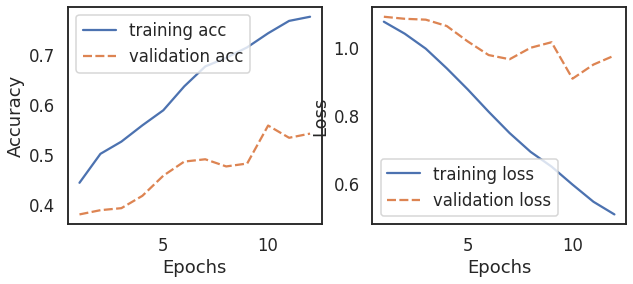

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(tuned)_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0733, train_acc:0.4568, val Loss: : 1.0937, val_acc: 0.360
[epoch 2] train_loss: 1.0346, train_acc:0.5144, val Loss: : 1.0913, val_acc: 0.369
[epoch 3] train_loss: 0.9887, train_acc:0.5338, val Loss: : 1.0876, val_acc: 0.384
[epoch 4] train_loss: 0.9324, train_acc:0.5650, val Loss: : 1.0729, val_acc: 0.406
[epoch 5] train_loss: 0.8647, train_acc:0.5963, val Loss: : 1.0122, val_acc: 0.461
[epoch 6] train_loss: 0.8049, train_acc:0.6365, val Loss: : 1.0040, val_acc: 0.475
[epoch 7] train_loss: 0.7433, train_acc:0.6699, val Loss: : 1.0079, val_acc: 0.473
[epoch 8] train_loss: 0.6858, train_acc:0.6865, val Loss: : 1.0108, val_acc: 0.481
[epoch 9] train_loss: 0.6276, train_acc:0.7229, val Loss: : 0

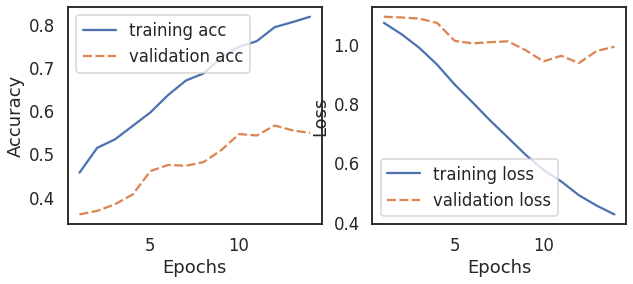

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(tuned)_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0582, train_acc:0.4777, val Loss: : 1.0907, val_acc: 0.376
[epoch 2] train_loss: 1.0088, train_acc:0.5243, val Loss: : 1.0894, val_acc: 0.380
[epoch 3] train_loss: 0.9553, train_acc:0.5496, val Loss: : 1.0770, val_acc: 0.410
[epoch 4] train_loss: 0.8956, train_acc:0.5694, val Loss: : 1.0444, val_acc: 0.439
[epoch 5] train_loss: 0.8419, train_acc:0.5917, val Loss: : 0.9856, val_acc: 0.482
[epoch 6] train_loss: 0.7948, train_acc:0.6231, val Loss: : 0.9941, val_acc: 0.483
[epoch 7] train_loss: 0.7445, train_acc:0.6589, val Loss: : 0.9790, val_acc: 0.486
[epoch 8] train_loss: 0.6937, train_acc:0.6822, val Loss: : 0.9461, val_acc: 0.511
[epoch 9] train_loss: 0.6522, train_acc:0.7061, val Loss: : 0

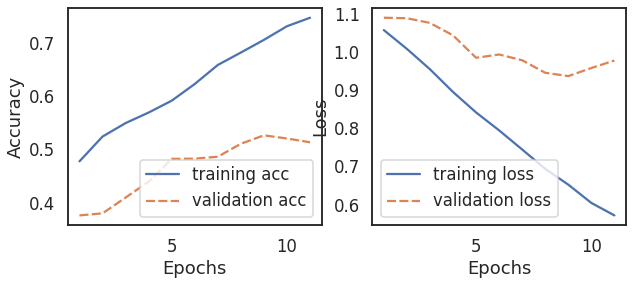

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(tuned)_0.4
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0355, train_acc:0.4894, val Loss: : 1.0952, val_acc: 0.367
[epoch 2] train_loss: 0.9767, train_acc:0.5352, val Loss: : 1.0809, val_acc: 0.399
[epoch 3] train_loss: 0.9194, train_acc:0.5673, val Loss: : 1.0512, val_acc: 0.433
[epoch 4] train_loss: 0.8641, train_acc:0.5907, val Loss: : 1.0105, val_acc: 0.457
[epoch 5] train_loss: 0.8155, train_acc:0.6184, val Loss: : 0.9708, val_acc: 0.478
[epoch 6] train_loss: 0.7700, train_acc:0.6408, val Loss: : 0.9673, val_acc: 0.481
[epoch 7] train_loss: 0.7287, train_acc:0.6664, val Loss: : 0.9644, val_acc: 0.488
[epoch 8] train_loss: 0.6879, train_acc:0.6854, val Loss: : 0.9678, val_acc: 0.507
[epoch 9] train_loss: 0.6413, train_acc:0.7123, val Loss: : 0

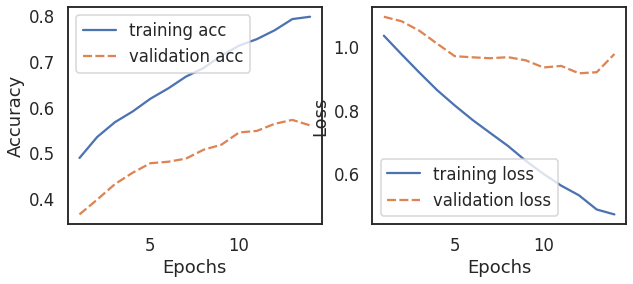

----------------------------------------------------------------------
acc_list [0.5485625485625486, 0.5377955377955378, 0.5451215451215451, 0.5931845931845932, 0.5574425574425574, 0.5843045843045843]
loss_list [0.8896761536598206, 0.9459875822067261, 0.9466862082481384, 0.9458664059638977, 0.9502231478691101, 0.9294925928115845]
precision_list [array([1.        , 0.56347693, 0.52751928]), array([0.19461338, 0.55677839, 0.68887695]), array([0.19783198, 0.61514603, 0.57327052]), array([0.24516129, 0.59688116, 0.66263345]), array([0.17257143, 0.57445343, 0.65978495]), array([0.24025974, 0.64463907, 0.58097297])]
recall_list [array([0.00292826, 0.6648673 , 0.51134021]), array([0.32796486, 0.75101215, 0.33041237]), array([0.32064422, 0.53531264, 0.59587629]), array([0.22254758, 0.74898785, 0.47989691]), array([0.22108346, 0.7505623 , 0.39536082]), array([0.21669107, 0.54633378, 0.69252577])]
fscore_list [array([0.00583942, 0.60998762, 0.51930376]), array([0.24427481, 0.63947142, 0.44661209

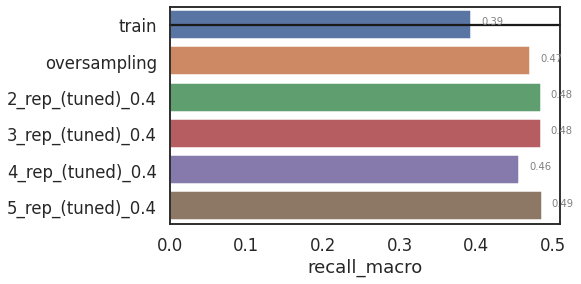

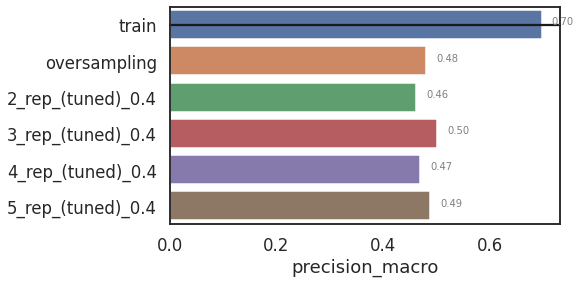

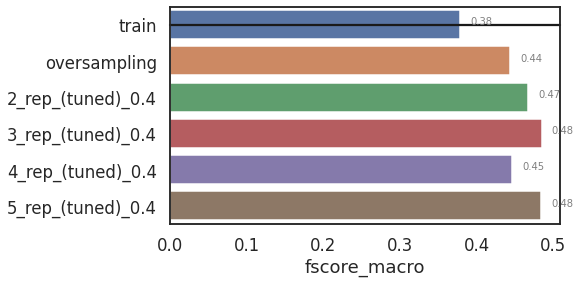

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0303, train_acc:0.5194, val Loss: : 1.0341, val_acc: 0.504
[epoch 2] train_loss: 0.9530, train_acc:0.5493, val Loss: : 0.9623, val_acc: 0.522
[epoch 3] train_loss: 0.8880, train_acc:0.5545, val Loss: : 0.8989, val_acc: 0.526
[epoch 4] train_loss: 0.8745, train_acc:0.5723, val Loss: : 0.8987, val_acc: 0.524
[epoch 5] train_loss: 0.8479, train_acc:0.5927, val Loss: : 0.8894, val_acc: 0.543
[epoch 6] train_loss: 0.8249, train_acc:0.6134, val Loss: : 0.8828, val_acc: 0.550
[epoch 7] train_loss: 0.7939, train_acc:0.6351, val Loss: : 0.8728, val_acc: 0.572
[epoch 8] train_loss: 0.7662, train_acc:0.6562, val Loss: : 0.8661, val_acc: 0.601
[epoch 9] train_loss: 0.7324, train_acc:0.6785, val Loss: : 0.8584, val_acc: 0.605
[epoch 10]

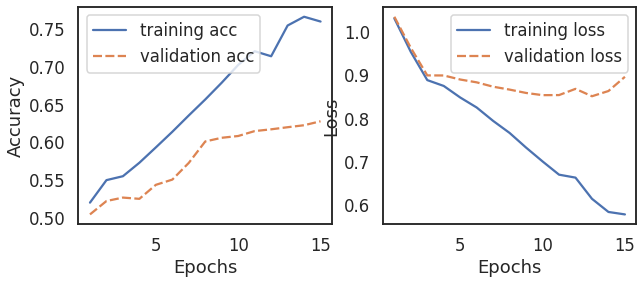

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 7128
[epoch 1] train_loss: 1.0678, train_acc:0.4605, val Loss: : 1.0827, val_acc: 0.409
[epoch 2] train_loss: 1.0227, train_acc:0.5107, val Loss: : 1.0937, val_acc: 0.376
[epoch 3] train_loss: 0.9563, train_acc:0.5481, val Loss: : 1.0855, val_acc: 0.408
[epoch 4] train_loss: 0.8682, train_acc:0.6025, val Loss: : 1.0210, val_acc: 0.481
[epoch 5] train_loss: 0.7759, train_acc:0.6523, val Loss: : 0.9619, val_acc: 0.498
[epoch 6] train_loss: 0.7026, train_acc:0.6887, val Loss: : 0.8944, val_acc: 0.546
[epoch 7] train_loss: 0.6172, train_acc:0.7315, val Loss: : 0.8956, val_acc: 0.568
[epoch 8] train_loss: 0.5612, train_acc:0.7564, val Loss: : 0.8820, val_acc: 0.584
[epoch 9] train_loss: 0.5139, train_acc:0.7810, val Lo

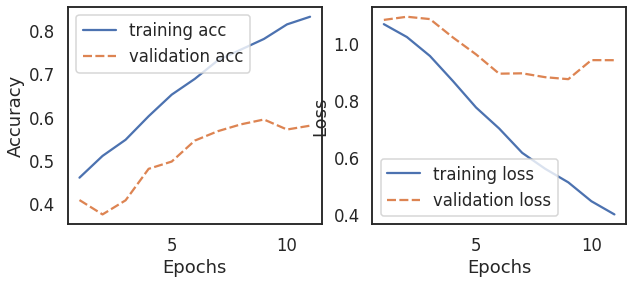

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(tuned)_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0630, train_acc:0.4740, val Loss: : 1.0879, val_acc: 0.386
[epoch 2] train_loss: 1.0112, train_acc:0.5142, val Loss: : 1.0883, val_acc: 0.382
[epoch 3] train_loss: 0.9310, train_acc:0.5629, val Loss: : 1.0426, val_acc: 0.443
[epoch 4] train_loss: 0.8394, train_acc:0.6094, val Loss: : 1.0273, val_acc: 0.461
[epoch 5] train_loss: 0.7600, train_acc:0.6581, val Loss: : 0.9758, val_acc: 0.492
[epoch 6] train_loss: 0.6807, train_acc:0.6999, val Loss: : 0.9123, val_acc: 0.538
[epoch 7] train_loss: 0.6325, train_acc:0.7273, val Loss: : 0.9623, val_acc: 0.530
[epoch 8] train_loss: 0.5824, train_acc:0.7528, val Loss: : 0.9986, val_acc: 0.535
[epoch 9] train_loss: 0.5391, train_acc:0.7616, val Loss: : 0

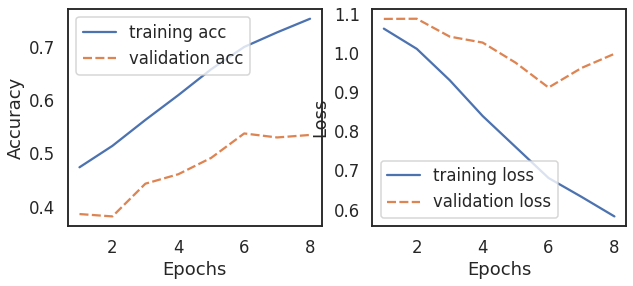

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(tuned)_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0602, train_acc:0.4737, val Loss: : 1.0932, val_acc: 0.361
[epoch 2] train_loss: 1.0037, train_acc:0.5131, val Loss: : 1.0822, val_acc: 0.387
[epoch 3] train_loss: 0.9186, train_acc:0.5612, val Loss: : 1.0153, val_acc: 0.456
[epoch 4] train_loss: 0.8362, train_acc:0.6136, val Loss: : 1.0056, val_acc: 0.460
[epoch 5] train_loss: 0.7633, train_acc:0.6530, val Loss: : 0.9958, val_acc: 0.469
[epoch 6] train_loss: 0.6929, train_acc:0.6883, val Loss: : 0.9215, val_acc: 0.526
[epoch 7] train_loss: 0.6315, train_acc:0.7170, val Loss: : 0.9271, val_acc: 0.545
[epoch 8] train_loss: 0.5770, train_acc:0.7466, val Loss: : 0.9462, val_acc: 0.542
[epoch 9] train_loss: 0.5467, train_acc:0.7624, val Loss: : 1

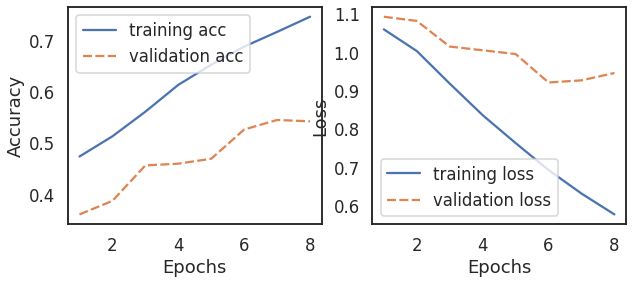

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(tuned)_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0515, train_acc:0.4915, val Loss: : 1.0839, val_acc: 0.398
[epoch 2] train_loss: 0.9925, train_acc:0.5219, val Loss: : 1.0808, val_acc: 0.392
[epoch 3] train_loss: 0.9202, train_acc:0.5656, val Loss: : 1.0424, val_acc: 0.439
[epoch 4] train_loss: 0.8336, train_acc:0.6118, val Loss: : 0.9968, val_acc: 0.485
[epoch 5] train_loss: 0.7572, train_acc:0.6538, val Loss: : 0.9781, val_acc: 0.496
[epoch 6] train_loss: 0.6890, train_acc:0.6882, val Loss: : 0.9540, val_acc: 0.528
[epoch 7] train_loss: 0.6198, train_acc:0.7243, val Loss: : 0.9165, val_acc: 0.560
[epoch 8] train_loss: 0.5653, train_acc:0.7560, val Loss: : 0.8994, val_acc: 0.568
[epoch 9] train_loss: 0.5158, train_acc:0.7742, val Loss: : 0

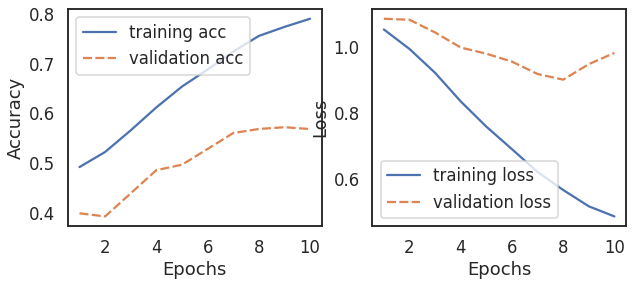

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(tuned)_0.6
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0251, train_acc:0.4933, val Loss: : 1.0893, val_acc: 0.370
[epoch 2] train_loss: 0.9522, train_acc:0.5397, val Loss: : 1.0579, val_acc: 0.426
[epoch 3] train_loss: 0.8727, train_acc:0.5809, val Loss: : 0.9835, val_acc: 0.477
[epoch 4] train_loss: 0.8062, train_acc:0.6198, val Loss: : 0.9801, val_acc: 0.484
[epoch 5] train_loss: 0.7525, train_acc:0.6506, val Loss: : 0.9232, val_acc: 0.519
[epoch 6] train_loss: 0.6997, train_acc:0.6758, val Loss: : 0.9018, val_acc: 0.539
[epoch 7] train_loss: 0.6300, train_acc:0.7141, val Loss: : 0.9334, val_acc: 0.544
[epoch 8] train_loss: 0.5833, train_acc:0.7411, val Loss: : 0.9432, val_acc: 0.551
[epoch 9] train_loss: 0.5314, train_acc:0.7706, val Loss: : 0

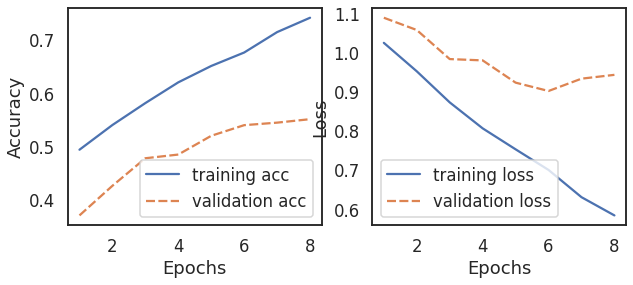

----------------------------------------------------------------------
acc_list [0.6032856032856033, 0.6177156177156177, 0.5583305583305583, 0.5249195249195249, 0.5503385503385504, 0.5766455766455767]
loss_list [0.9006479382514954, 0.8988921046257019, 0.9188416600227356, 0.9959434866905212, 0.9915952086448669, 0.8970301747322083]
precision_list [array([0.28037383, 0.63219741, 0.5842479 ]), array([0.28082192, 0.63113188, 0.63956499]), array([0.2028754 , 0.58449809, 0.69217082]), array([0.16629588, 0.6039114 , 0.62925514]), array([0.17388652, 0.60797685, 0.6839194 ]), array([0.19395203, 0.62031493, 0.62468229])]
recall_list [array([0.04392387, 0.60503824, 0.69974227]), array([0.18008785, 0.66846604, 0.63659794]), array([0.37188873, 0.72424651, 0.40103093]), array([0.43777452, 0.57647323, 0.48118557]), array([0.41727672, 0.6617184 , 0.44613402]), array([0.27232796, 0.62910481, 0.57010309])]
fscore_list [array([0.07594937, 0.61831973, 0.63680075]), array([0.21944692, 0.6492627 , 0.63807802

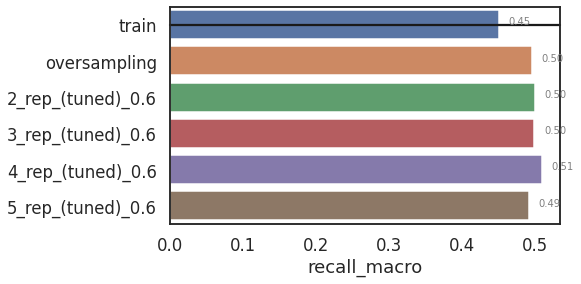

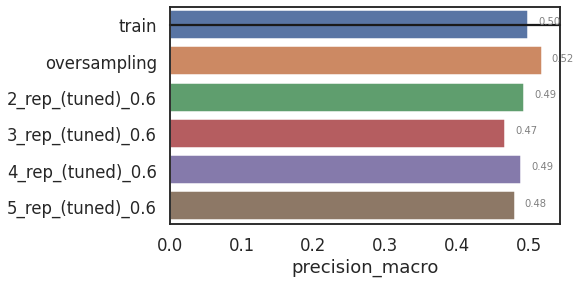

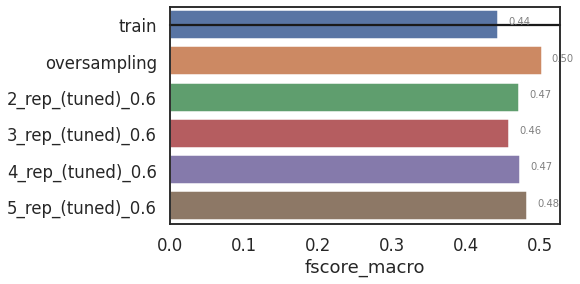

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0110, train_acc:0.5091, val Loss: : 1.0142, val_acc: 0.484
[epoch 2] train_loss: 0.9018, train_acc:0.5459, val Loss: : 0.9065, val_acc: 0.520
[epoch 3] train_loss: 0.8802, train_acc:0.5719, val Loss: : 0.8958, val_acc: 0.531
[epoch 4] train_loss: 0.8540, train_acc:0.5891, val Loss: : 0.8857, val_acc: 0.545
[epoch 5] train_loss: 0.8297, train_acc:0.6105, val Loss: : 0.8797, val_acc: 0.557
[epoch 6] train_loss: 0.7955, train_acc:0.6358, val Loss: : 0.8684, val_acc: 0.577
[epoch 7] train_loss: 0.7597, train_acc:0.6612, val Loss: : 0.8645, val_acc: 0.592
[epoch 8] train_loss: 0.7273, train_acc:0.6822, val Loss: : 0.8582, val_acc: 0.612
[epoch 9] train_loss: 0.7032, train_acc:0.6968, val Loss: : 0.8532, val_acc: 0.614
[epoch 10]

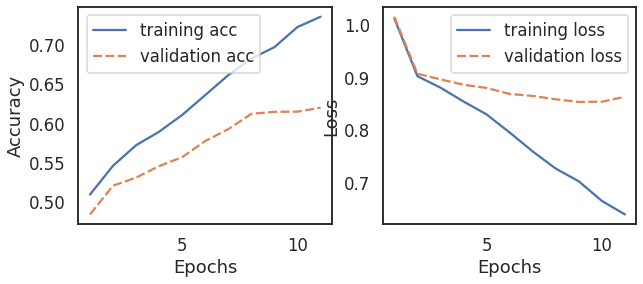

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 9488
[epoch 1] train_loss: 1.0542, train_acc:0.4608, val Loss: : 1.0901, val_acc: 0.377
[epoch 2] train_loss: 0.9805, train_acc:0.5276, val Loss: : 1.0619, val_acc: 0.429
[epoch 3] train_loss: 0.8681, train_acc:0.5979, val Loss: : 1.0000, val_acc: 0.474
[epoch 4] train_loss: 0.7737, train_acc:0.6557, val Loss: : 0.9931, val_acc: 0.483
[epoch 5] train_loss: 0.6693, train_acc:0.7087, val Loss: : 0.9541, val_acc: 0.534
[epoch 6] train_loss: 0.6230, train_acc:0.7293, val Loss: : 1.0210, val_acc: 0.519
[epoch 7] train_loss: 0.5539, train_acc:0.7659, val Loss: : 0.9764, val_acc: 0.536
[epoch 8] train_loss: 0.5064, train_acc:0.7834, val Loss: : 1.0111, val_acc: 0.553


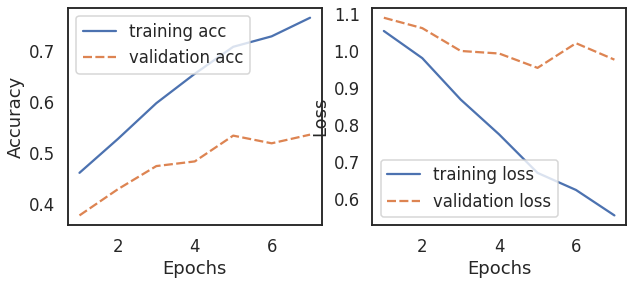

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(tuned)_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0525, train_acc:0.4756, val Loss: : 1.0879, val_acc: 0.388
[epoch 2] train_loss: 0.9729, train_acc:0.5338, val Loss: : 1.0562, val_acc: 0.427
[epoch 3] train_loss: 0.8679, train_acc:0.5945, val Loss: : 1.0248, val_acc: 0.459
[epoch 4] train_loss: 0.7652, train_acc:0.6569, val Loss: : 0.9261, val_acc: 0.527
[epoch 5] train_loss: 0.7118, train_acc:0.6714, val Loss: : 0.9539, val_acc: 0.520
[epoch 6] train_loss: 0.6313, train_acc:0.7304, val Loss: : 0.9872, val_acc: 0.521
[epoch 7] train_loss: 0.5549, train_acc:0.7579, val Loss: : 0.8993, val_acc: 0.577
[epoch 8] train_loss: 0.4985, train_acc:0.7917, val Loss: : 0.9196, val_acc: 0.585
[epoch 9] train_loss: 0.4447, train_acc:0.8124, val Loss: : 0

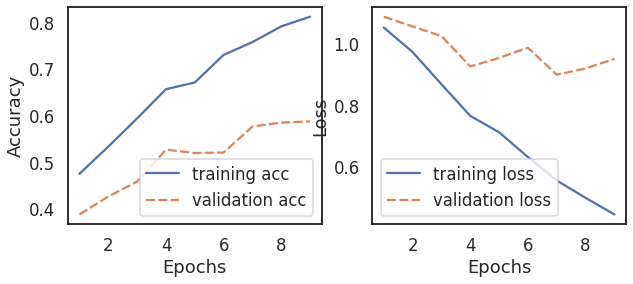

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(tuned)_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0530, train_acc:0.4852, val Loss: : 1.0823, val_acc: 0.398
[epoch 2] train_loss: 0.9824, train_acc:0.5292, val Loss: : 1.0752, val_acc: 0.407
[epoch 3] train_loss: 0.8788, train_acc:0.5913, val Loss: : 1.0137, val_acc: 0.478
[epoch 4] train_loss: 0.7687, train_acc:0.6575, val Loss: : 0.9133, val_acc: 0.550
[epoch 5] train_loss: 0.6856, train_acc:0.7017, val Loss: : 0.9482, val_acc: 0.542
[epoch 6] train_loss: 0.6264, train_acc:0.7249, val Loss: : 0.9091, val_acc: 0.562
[epoch 7] train_loss: 0.5641, train_acc:0.7586, val Loss: : 0.9524, val_acc: 0.569
[epoch 8] train_loss: 0.4999, train_acc:0.7896, val Loss: : 0.8973, val_acc: 0.587
[epoch 9] train_loss: 0.4586, train_acc:0.8028, val Loss: : 0

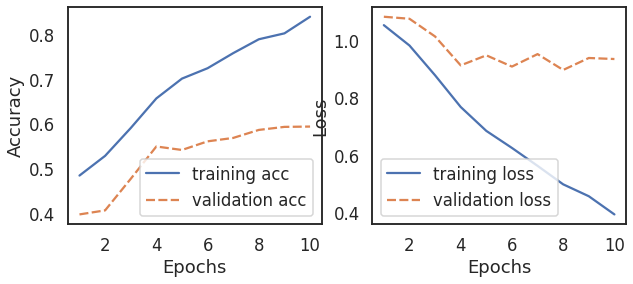

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(tuned)_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0390, train_acc:0.4890, val Loss: : 1.0819, val_acc: 0.387
[epoch 2] train_loss: 0.9487, train_acc:0.5407, val Loss: : 1.0291, val_acc: 0.440
[epoch 3] train_loss: 0.8543, train_acc:0.6008, val Loss: : 0.9685, val_acc: 0.491
[epoch 4] train_loss: 0.7756, train_acc:0.6407, val Loss: : 0.9981, val_acc: 0.483
[epoch 5] train_loss: 0.6897, train_acc:0.6896, val Loss: : 0.9616, val_acc: 0.532
[epoch 6] train_loss: 0.6195, train_acc:0.7337, val Loss: : 0.9321, val_acc: 0.552
[epoch 7] train_loss: 0.5568, train_acc:0.7630, val Loss: : 0.9419, val_acc: 0.566
[epoch 8] train_loss: 0.5060, train_acc:0.7883, val Loss: : 0.9497, val_acc: 0.557
[epoch 9] train_loss: 0.4441, train_acc:0.8166, val Loss: : 0

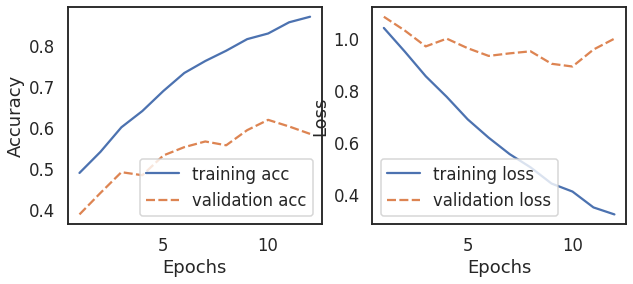

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(tuned)_0.8
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0182, train_acc:0.5007, val Loss: : 1.0921, val_acc: 0.373
[epoch 2] train_loss: 0.9215, train_acc:0.5619, val Loss: : 1.0175, val_acc: 0.467
[epoch 3] train_loss: 0.8270, train_acc:0.6019, val Loss: : 1.0172, val_acc: 0.468
[epoch 4] train_loss: 0.7504, train_acc:0.6474, val Loss: : 0.9646, val_acc: 0.497
[epoch 5] train_loss: 0.6808, train_acc:0.6831, val Loss: : 0.9753, val_acc: 0.511
[epoch 6] train_loss: 0.6353, train_acc:0.7047, val Loss: : 0.9249, val_acc: 0.536
[epoch 7] train_loss: 0.5697, train_acc:0.7477, val Loss: : 0.8938, val_acc: 0.570
[epoch 8] train_loss: 0.5178, train_acc:0.7728, val Loss: : 0.8796, val_acc: 0.603
[epoch 9] train_loss: 0.4582, train_acc:0.8049, val Loss: : 0

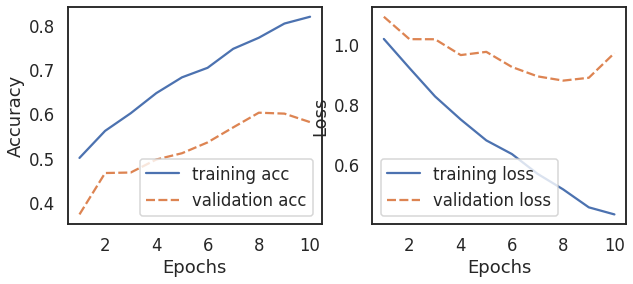

----------------------------------------------------------------------
acc_list [0.6114996114996115, 0.521922521922522, 0.5772005772005772, 0.5946275946275946, 0.6021756021756022, 0.5890775890775891]
loss_list [0.8649662733078003, 1.0189722776412964, 0.9261953234672546, 0.9429303407669067, 0.9728148579597473, 0.9225793480873108]
precision_list [array([0.25833333, 0.60105448, 0.64332604]), array([0.17116358, 0.65487316, 0.64103268]), array([0.21893004, 0.61039224, 0.67240169]), array([0.22641509, 0.64405953, 0.64919673]), array([0.23264781, 0.64860267, 0.62560739]), array([0.20980926, 0.61561206, 0.68888889])]
recall_list [array([0.04538799, 0.76923077, 0.53041237]), array([0.59443631, 0.44129555, 0.60154639]), array([0.38945827, 0.67903734, 0.4935567 ]), array([0.36896047, 0.59379217, 0.63530928]), array([0.26500732, 0.60031489, 0.66365979]), array([0.33821376, 0.70242915, 0.50335052])]
fscore_list [array([0.07721046, 0.67482242, 0.58143806]), array([0.26579378, 0.52727761, 0.62066215]

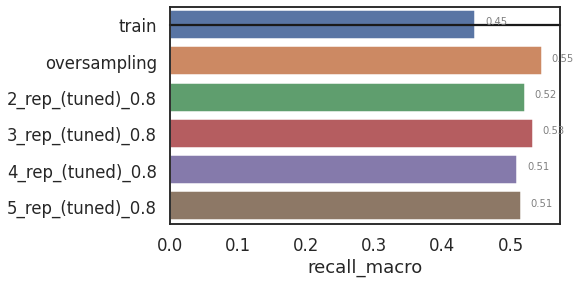

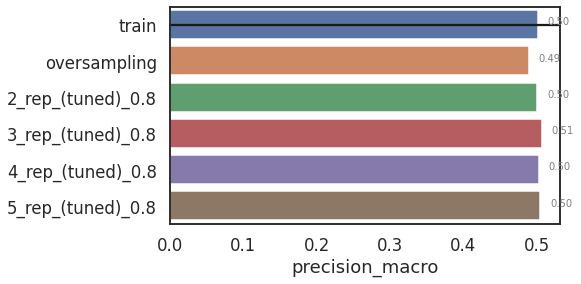

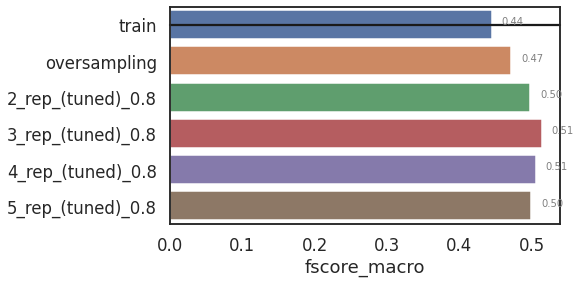

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9846, train_acc:0.5301, val Loss: : 0.9866, val_acc: 0.526
[epoch 2] train_loss: 0.9083, train_acc:0.5547, val Loss: : 0.9111, val_acc: 0.537
[epoch 3] train_loss: 0.8629, train_acc:0.5816, val Loss: : 0.8841, val_acc: 0.551
[epoch 4] train_loss: 0.8320, train_acc:0.6114, val Loss: : 0.8736, val_acc: 0.563
[epoch 5] train_loss: 0.7851, train_acc:0.6439, val Loss: : 0.8546, val_acc: 0.602
[epoch 6] train_loss: 0.7490, train_acc:0.6741, val Loss: : 0.8527, val_acc: 0.611
[epoch 7] train_loss: 0.7178, train_acc:0.6909, val Loss: : 0.8497, val_acc: 0.612
[epoch 8] train_loss: 0.6713, train_acc:0.7188, val Loss: : 0.8397, val_acc: 0.627
[epoch 9] train_loss: 0.6343, train_acc:0.7387, val Loss: : 0.8383, val_acc: 0.628
[epoch 10]

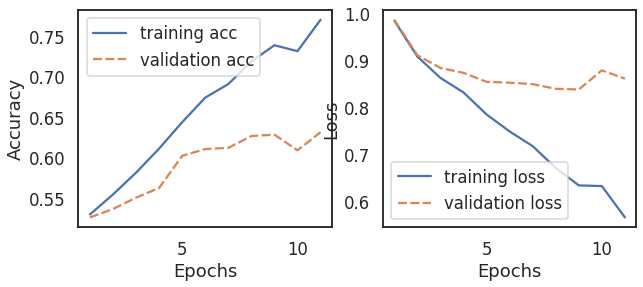

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
num_DA 11850
[epoch 1] train_loss: 1.0485, train_acc:0.4718, val Loss: : 1.0862, val_acc: 0.386
[epoch 2] train_loss: 0.9427, train_acc:0.5504, val Loss: : 1.0170, val_acc: 0.464
[epoch 3] train_loss: 0.8212, train_acc:0.6285, val Loss: : 0.9999, val_acc: 0.475
[epoch 4] train_loss: 0.7115, train_acc:0.6765, val Loss: : 0.9700, val_acc: 0.517
[epoch 5] train_loss: 0.5943, train_acc:0.7437, val Loss: : 0.8719, val_acc: 0.588
[epoch 6] train_loss: 0.5326, train_acc:0.7662, val Loss: : 0.9254, val_acc: 0.578
[epoch 7] train_loss: 0.4645, train_acc:0.8002, val Loss: : 0.9101, val_acc: 0.590
[epoch 8] train_loss: 0.4103, train_acc:0.8258, val Loss: : 0.9169, val_acc: 0.603


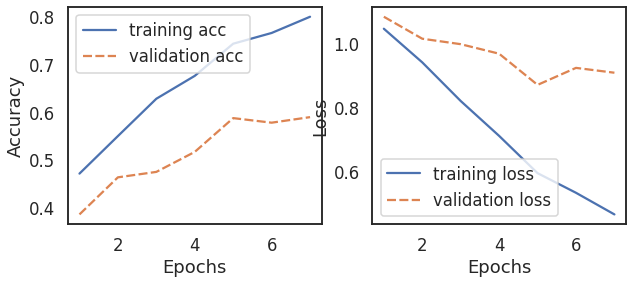

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(tuned)_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0462, train_acc:0.4795, val Loss: : 1.0896, val_acc: 0.376
[epoch 2] train_loss: 0.9372, train_acc:0.5529, val Loss: : 1.0114, val_acc: 0.466
[epoch 3] train_loss: 0.8116, train_acc:0.6319, val Loss: : 0.9812, val_acc: 0.488
[epoch 4] train_loss: 0.7128, train_acc:0.6850, val Loss: : 0.9840, val_acc: 0.519
[epoch 5] train_loss: 0.6269, train_acc:0.7288, val Loss: : 0.9446, val_acc: 0.547
[epoch 6] train_loss: 0.5291, train_acc:0.7795, val Loss: : 0.8900, val_acc: 0.589
[epoch 7] train_loss: 0.4780, train_acc:0.7962, val Loss: : 0.9418, val_acc: 0.597
[epoch 8] train_loss: 0.4080, train_acc:0.8339, val Loss: : 0.9016, val_acc: 0.615
[epoch 9] train_loss: 0.3603, train_acc:0.8591, val Loss: : 0.9

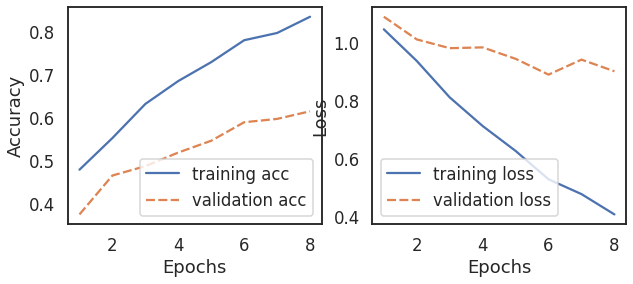

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(tuned)_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0410, train_acc:0.4823, val Loss: : 1.0958, val_acc: 0.370
[epoch 2] train_loss: 0.9392, train_acc:0.5493, val Loss: : 1.0575, val_acc: 0.440
[epoch 3] train_loss: 0.8180, train_acc:0.6198, val Loss: : 0.9910, val_acc: 0.479
[epoch 4] train_loss: 0.7287, train_acc:0.6738, val Loss: : 0.9252, val_acc: 0.532
[epoch 5] train_loss: 0.6437, train_acc:0.7150, val Loss: : 0.9661, val_acc: 0.529
[epoch 6] train_loss: 0.5678, train_acc:0.7552, val Loss: : 0.8931, val_acc: 0.582
[epoch 7] train_loss: 0.4888, train_acc:0.7944, val Loss: : 0.8997, val_acc: 0.580
[epoch 8] train_loss: 0.4551, train_acc:0.8085, val Loss: : 0.9729, val_acc: 0.570
[epoch 9] train_loss: 0.3997, train_acc:0.8323, val Loss: : 0.9

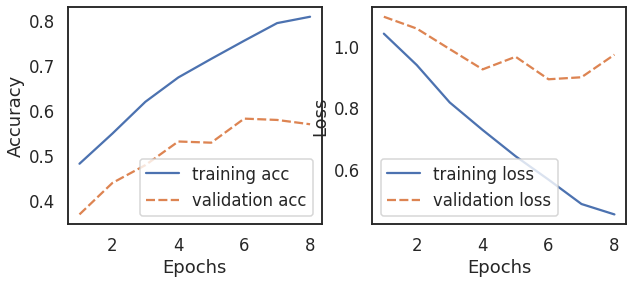

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(tuned)_1
----------------------------------------------------------------------
[epoch 1] train_loss: 1.0267, train_acc:0.4873, val Loss: : 1.0853, val_acc: 0.375
[epoch 2] train_loss: 0.9071, train_acc:0.5565, val Loss: : 0.9932, val_acc: 0.468
[epoch 3] train_loss: 0.8082, train_acc:0.6166, val Loss: : 0.9746, val_acc: 0.478
[epoch 4] train_loss: 0.7099, train_acc:0.6749, val Loss: : 0.9398, val_acc: 0.523
[epoch 5] train_loss: 0.6492, train_acc:0.7106, val Loss: : 0.9905, val_acc: 0.527
[epoch 6] train_loss: 0.5913, train_acc:0.7453, val Loss: : 0.8609, val_acc: 0.602
[epoch 7] train_loss: 0.4902, train_acc:0.7915, val Loss: : 0.8717, val_acc: 0.610
[epoch 8] train_loss: 0.4411, train_acc:0.8180, val Loss: : 0.8664, val_acc: 0.612
[epoch 9] train_loss: 0.4063, train_acc:0.8314, val Loss: : 0.8

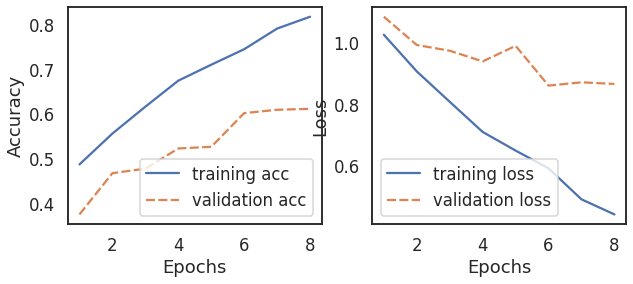

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(tuned)_1
----------------------------------------------------------------------
[epoch 1] train_loss: 0.9924, train_acc:0.5168, val Loss: : 1.0646, val_acc: 0.407
[epoch 2] train_loss: 0.8659, train_acc:0.5725, val Loss: : 0.9913, val_acc: 0.459
[epoch 3] train_loss: 0.7859, train_acc:0.6213, val Loss: : 1.0032, val_acc: 0.468
[epoch 4] train_loss: 0.7104, train_acc:0.6671, val Loss: : 0.9122, val_acc: 0.532
[epoch 5] train_loss: 0.6397, train_acc:0.7054, val Loss: : 0.9634, val_acc: 0.529
[epoch 6] train_loss: 0.5617, train_acc:0.7486, val Loss: : 0.9083, val_acc: 0.582
[epoch 7] train_loss: 0.5111, train_acc:0.7746, val Loss: : 0.8799, val_acc: 0.598
[epoch 8] train_loss: 0.4624, train_acc:0.8008, val Loss: : 0.8878, val_acc: 0.620
[epoch 9] train_loss: 0.4102, train_acc:0.8294, val Loss: : 0.8

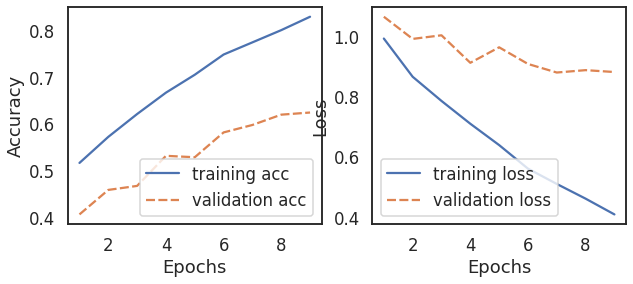

----------------------------------------------------------------------
acc_list [0.6151626151626152, 0.5736485736485737, 0.5599955599955599, 0.5796425796425796, 0.627039627039627, 0.6178266178266179]
loss_list [0.8811085820198059, 0.9406324028968811, 1.002925157546997, 0.9640265107154846, 0.8878252506256104, 0.8837127089500427]
precision_list [array([0.30120482, 0.60553571, 0.64785692]), array([0.20150188, 0.67232143, 0.63860775]), array([0.16883117, 0.6386174 , 0.67926388]), array([0.21919585, 0.66340509, 0.64550129]), array([0.25285714, 0.63541461, 0.69492574]), array([0.2633015 , 0.66165778, 0.63686747])]
recall_list [array([0.07320644, 0.76270805, 0.54149485]), array([0.47144949, 0.50809717, 0.66675258]), array([0.43777452, 0.6025641 , 0.53273196]), array([0.49487555, 0.53373819, 0.64716495]), array([0.25915081, 0.72559604, 0.57886598]), array([0.28257687, 0.61403509, 0.68118557])]
fscore_list [array([0.11778563, 0.67509457, 0.58991998]), array([0.28233231, 0.57878555, 0.65237675])

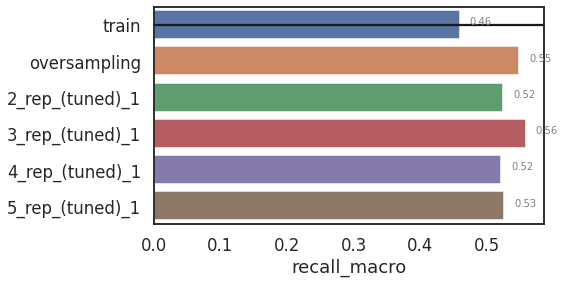

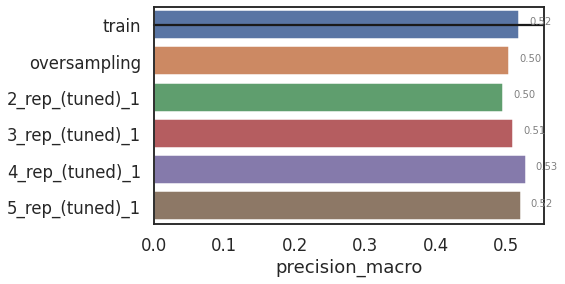

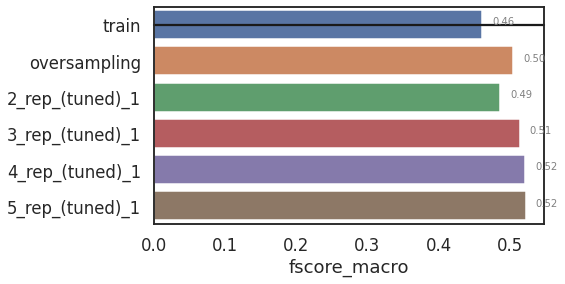

CPU times: user 22min 40s, sys: 27.6 s, total: 23min 7s
Wall time: 23min 4s


In [ ]:
%%time
      
task_name = 'sub_twitter'
tech_name = 'Bert_ data augmentation-master'
ratios = [0.2, 0.4, 0.6, 0.8, 1]
for ratio in ratios:
  if ratio == 0.2:
    test_list = ['train',
                 'oversampling',
                 '2_rep_(tuned)_0.2',
      '3_rep_(tuned)_0.2',
      '4_rep_(tuned)_0.2',
      '5_rep_(tuned)_0.2']
    print('<'*50)
    # print('ratio', ratio)
  if ratio == 0.4:
    test_list = ['train',
                 'oversampling',
                 '2_rep_(tuned)_0.4',
      '3_rep_(tuned)_0.4',
      '4_rep_(tuned)_0.4',
      '5_rep_(tuned)_0.4']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.6:
    test_list = ['train',
                 'oversampling',
                 '2_rep_(tuned)_0.6',
      '3_rep_(tuned)_0.6',
      '4_rep_(tuned)_0.6',
      '5_rep_(tuned)_0.6']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.8:
    test_list = ['train',
                 'oversampling',
                 '2_rep_(tuned)_0.8',
      '3_rep_(tuned)_0.8',
      '4_rep_(tuned)_0.8',
      '5_rep_(tuned)_0.8']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 1:
    test_list = ['train',
                 'oversampling',
                 '2_rep_(tuned)_1',
      '3_rep_(tuned)_1',
      '4_rep_(tuned)_1',
      '5_rep_(tuned)_1']

    print('<'*50)

  Execute(test_list, task_name, tech_name, ratio)

## Pretrain BERT